In [7]:
%reload_ext mocodo

In [8]:
from IPython import display
from pathlib import Path
import re
import os
if os.path.basename(os.getcwd()) != "mocodo_notebook":
    os.chdir("mocodo_notebook")

![](https://cdn.rawgit.com/laowantong/mocodo/master/logos/banner.svg)

# Introduction

Mocodo est un logiciel d'aide à l'enseignement et à la conception des [bases de données relationnelles](https://fr.wikipedia.org/wiki/Base_de_données_relationnelle).

- En entrée, il prend une description textuelle des entités et associations du modèle conceptuel de données ([MCD](https://fr.wikipedia.org/wiki/Modèle_entité-association)).
- En sortie, il trace un diagramme entité-association qu'il peut arranger automatiquement de façon esthétique.
- À la demande, il le convertit en relationnel ([MLD](https://fr.wikipedia.org/wiki/Merise_(informatique)#MLD_:_modèle_logique_des_données)), en requêtes de création ([DDL](https://fr.wikipedia.org/wiki/Langage_de_définition_de_données)), en [diagramme de classes UML](https://fr.wikipedia.org/wiki/Diagramme_de_classes), etc.
- Il permet de transformer rapidement un MCD en un autre par application de diverses opérations de réécriture.

## Tracé du modèle conceptuel

Ci-dessous, un exemple d'utilisation sous [Jupyter Notebook](https://jupyter.org). L'appel du programme est en première ligne, sur un texte d'entrée donné lignes suivantes dans un langage dédié, également appelé Mocodo. En sortie, le diagramme conceptuel (MCD), agrémenté ici avec l'option `--colors` :

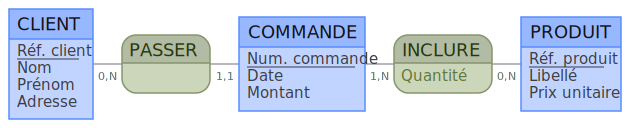

In [5]:
%%mocodo --colors ocean
CLIENT: Réf. client [VARCHAR(8)], Nom [VARCHAR(255)], Prénom [VARCHAR(255)], Adresse [VARCHAR(255)]
PASSER, 0N CLIENT, 11 COMMANDE
COMMANDE: Num. commande [VARCHAR(8)], Date [DATE], Montant [DECIMAL(10,2)]
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantité [INTEGER]
PRODUIT: Réf. produit [VARCHAR(8)], Libellé [VARCHAR(50)], Prix unitaire [DECIMAL(10,2)]

## Opérations de conversion

L'appel précédent a automatiquement enregistré le texte-source dans le répertoire courant sous le nom de `sandbox.mcd`. On peut récupérer celui-ci (`--input`) pour lui appliquer diverses opérations, par exemple le convertir (`--convert`) en dictionnaire des données (`data_dict`). Par défaut, le résultat est un tableau Markdown à trois colonnes :

In [6]:
%mocodo --input sandbox --convert data_dict

| Entité ou association | Libellé de l'attribut | Type |
|:---|:---|:---|
| CLIENT | Adresse | VARCHAR(255) |
| " | Nom | VARCHAR(255) |
| " | Prénom | VARCHAR(255) |
| " | Réf. client | VARCHAR(8) |
| COMMANDE | Date | DATE |
| " | Montant | DECIMAL(10,2) |
| " | Num. commande | VARCHAR(8) |
| INCLURE | Quantité | INTEGER |
| PRODUIT | Libellé | VARCHAR(50) |
| " | Prix unitaire | DECIMAL(10,2) |
| " | Réf. produit | VARCHAR(8) |


Avec le sous-argument `rel`, on génère le schéma relationnel :

In [15]:
%mocodo --input sandbox --convert rel

**CLIENT** (<ins>Réf. client</ins>, Nom, Prénom, Adresse)<br>
**COMMANDE** (<ins>Num. commande</ins>, Date, Montant, _#Réf. client_)<br>
**INCLURE** (<ins>_#Num. commande_</ins>, <ins>_#Réf. produit_</ins>, Quantité)<br>
**PRODUIT** (<ins>Réf. produit</ins>, Libellé, Prix unitaire)


Le sous-argument `rel:diagram` permet de visualiser le diagramme correspondant :

In [8]:
%mocodo --input sandbox --convert rel:diagram --colors desert

Et bien sûr, on peut aller jusqu'au niveau SQL :

In [9]:
%mocodo --input sandbox --convert rel:sqlite --title="VPC"

```sql
.open "VPC";

CREATE TABLE "CLIENT" (
  "réf_client" VARCHAR(8),
  "nom" VARCHAR(255),
  "prénom" VARCHAR(255),
  "adresse" VARCHAR(255),
  PRIMARY KEY ("réf_client")
);

CREATE TABLE "COMMANDE" (
  "num_commande" VARCHAR(8),
  "date" DATE,
  "montant" DECIMAL(10,2),
  "réf_client" VARCHAR(8),
  PRIMARY KEY ("num_commande"),
  FOREIGN KEY ("réf_client") REFERENCES "CLIENT" ("réf_client")
);

CREATE TABLE "INCLURE" (
  "num_commande" VARCHAR(8),
  "réf_produit" VARCHAR(8),
  "quantité" INTEGER,
  PRIMARY KEY ("num_commande", "réf_produit"),
  FOREIGN KEY ("num_commande") REFERENCES "COMMANDE" ("num_commande"),
  FOREIGN KEY ("réf_produit") REFERENCES "PRODUIT" ("réf_produit")
);

CREATE TABLE "PRODUIT" (
  "réf_produit" VARCHAR(8),
  "libellé" VARCHAR(50),
  "prix_unitaire" DECIMAL(10,2),
  PRIMARY KEY ("réf_produit")
);

```

Notre MCD peut être transcrit dans d'autres formalismes, par exemple _crow's foot_ (`crow`) pour [Mermaid](http://mermaid.js.org) (`mmd`) :

In [10]:
%mocodo --input sandbox --convert crow:mmd

```mmd
erDiagram
  CLIENT {
    VARCHAR(8) ref_client PK
    VARCHAR(255) nom
    VARCHAR(255) prenom
    VARCHAR(255) adresse
  }
  COMMANDE {
    VARCHAR(8) num_commande PK
    DATE date
    DECIMAL(10-2) montant
  }
  INCLURE {
    INTEGER quantite
  }
  PRODUIT {
    VARCHAR(8) ref_produit PK
    VARCHAR(50) libelle
    DECIMAL(10-2) prix_unitaire
  }
  CLIENT ||--o{ COMMANDE: PASSER
  INCLURE }|..|| COMMANDE: IN
  INCLURE }o..|| PRODUIT: IN

```

Le rendu des diagrammes codés en Mermaid ou dans d'autres formats tiers n'est pas directement pris en charge, mais peut être délégué (`defer`) de façon transparente à un service web approprié, simplement en précisant le format d'image attendu (`svg`) :

In [11]:
%mocodo --input sandbox --convert crow:mmd defer:svg

## Opérations de réécriture

À partir d'un MCD Mocodo, une réécriture (`--rewrite`) produit un autre MCD Mocodo (par opposition à une conversion, qui résulte en un tout autre animal). Par défaut, son exécution affiche, au-dessous du diagramme, le code-source résultant : cela permet de le copier-coller dans une autre cellule pour continuer à travailler dessus.

Mettons par exemple les noms des entités et associations (`boxes`) en majuscules, et tous les libellés (`labels`) en ASCII et _snake case_ :

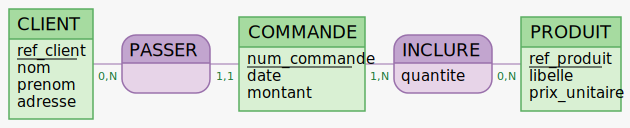

%%mocodo
CLIENT: ref_client [VARCHAR(8)], nom [VARCHAR(255)], prenom [VARCHAR(255)], adresse [VARCHAR(255)]
PASSER, 0N CLIENT, 11 COMMANDE
COMMANDE: num_commande [VARCHAR(8)], date [DATE], montant [DECIMAL(10,2)]
INCLURE, 1N COMMANDE, 0N PRODUIT: quantite [INTEGER]
PRODUIT: ref_produit [VARCHAR(8)], libelle [VARCHAR(50)], prix_unitaire [DECIMAL(10,2)]


In [12]:
%mocodo --input sandbox --rewrite boxes:upper labels:ascii,snake --colors brewer+3

Quelques possibilités de réécriture sémantique sont offertes. Par exemple, on peut décomposer un MCD quelconque en un MCD équivalent, mais n'employant que des dépendances fonctionnelles et des entités faibles :

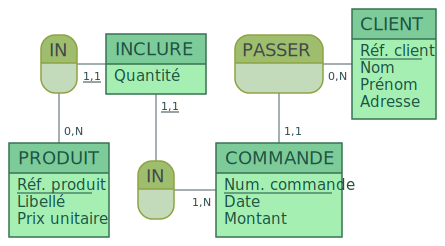

%%mocodo
IN2, _11 INCLURE, 0N PRODUIT
INCLURE: _Quantité [INTEGER]
PASSER, 0N CLIENT, 11 COMMANDE
CLIENT: Réf. client [VARCHAR(8)], Nom [VARCHAR(255)], Prénom [VARCHAR(255)], Adresse [VARCHAR(255)]

PRODUIT: Réf. produit [VARCHAR(8)], Libellé [VARCHAR(50)], Prix unitaire [DECIMAL(10,2)]
IN1, _11 INCLURE, 1N COMMANDE
COMMANDE: Num. commande [VARCHAR(8)], Date [DATE], Montant [DECIMAL(10,2)]
:


In [13]:
%mocodo --input sandbox --rewrite explode:weak,arity=2 arrange --seed=3 --colors pond

La sous-option `arrange` a procédé à une réorganisation des boîtes, ce que la création de deux nouvelles associations de dépendance fonctionnelles avait rendu nécessaire. Notez que, pour obtenir le même résultat à chaque exécution, nous avons fixé le germe du générateur pseudo-aléatoire (`--seed=3`).

**Remarque.** Mocodo met en œuvre une technique de réarrangement originale : en contraignant la position des boîtes aux intersections d'une grille invisible, il transforme un classique [problème de plongement](https://en.wikipedia.org/wiki/Graph_embedding) en un [problème d'affectation](https://fr.wikipedia.org/wiki/Problème_d%27affectation), ce qui permet de satisfaire de façon efficace à un certain nombre de contraintes esthétiques pertinentes (planarité, compacité, etc.).

Le réarrangement peut se faire automatiquement sur un nombre de rangées et de colonnes au rapport « équilibré » (i.e., proche du [nombre d'or](https://fr.wikipedia.org/wiki/Nombre_d%27or)), ou au contraire spécifié par l'utilisateur. Ici, on constate que le MCD résultant consiste en un « chapelet » d'entités et d'associations. On peut donc demander à l'arranger sur une seule ligne (`arrange:grid=7x1`) :

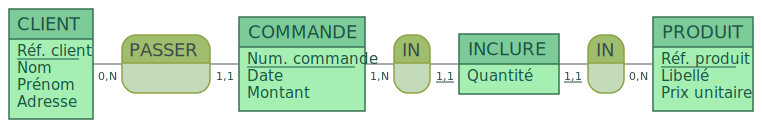

%%mocodo
CLIENT: Réf. client [VARCHAR(8)], Nom [VARCHAR(255)], Prénom [VARCHAR(255)], Adresse [VARCHAR(255)]
PASSER, 0N CLIENT, 11 COMMANDE
COMMANDE: Num. commande [VARCHAR(8)], Date [DATE], Montant [DECIMAL(10,2)]
IN1, _11 INCLURE, 1N COMMANDE
INCLURE: _Quantité [INTEGER]
IN2, _11 INCLURE, 0N PRODUIT
PRODUIT: Réf. produit [VARCHAR(8)], Libellé [VARCHAR(50)], Prix unitaire [DECIMAL(10,2)]


In [14]:
%mocodo --input sandbox --rewrite explode:weak,arity=2 arrange:grid=7x1 --seed=3 --colors pond

Après cet aperçu de quelques-unes des fonctionnalités de Mocodo, passons aux choses sérieuses !

# Installation du programme

## Installation complète (recommandé)

- Installez la [distribution Anaconda](https://www.anaconda.com/products/distribution), qui contient Python 3, Jupyter Notebook et bien plus encore.
- Exécutez ensuite sous un terminal la ligne suivante pour installer Mocodo ainsi que sa « commande magique » (utilisable sous [Jupyter notebook](https://jupyter.org)) :

        python -m pip install mocodo

- Si vous souhaitez générer des figures en PDF ou en PNG :

        python -m pip install cairosvg

## Vérification

Toujours sous un terminal, tapez:

    mocodo

Si votre système se plaint que cette commande n'existe pas, localisez le fichier `mocodo` et ajoutez à votre `PATH` le chemin du répertoire contenant:
- [sous Linux ou macOS](http://www.commentcamarche.net/faq/3585-bash-la-variable-d-environnement-path#v-ajouter-un-repertoire-a-la-variable-path);
- [sous Windows](http://sametmax.com/ajouter-un-chemin-a-la-variable-denvironnement-path-sous-windows/).

Pour mettre la « commande magique » `mocodo` à disposition d'un _notebook_ donné, évaluez dans celui-ci la cellule suivante:

    %reload_ext mocodo

Techniquement, `%load_ext mocodo` suffit, mais cette forme vous épargnera un message d'erreur si vous réévaluez ultérieurement la cellule.

Pour tester, évaluez une cellule avec:

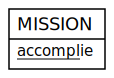

In [23]:
%%mocodo
MISSION: accomplie

Pour charger automatiquement `mocodo` à chaque ouverture d'un notebook (ce qui dispense d'évaluer `%load_ext mocodo`) :

- exécuter sous un terminal :

			ipython profile create
	
- éditer le fichier créé (p. ex.: `~/.ipython/profile_default/ipython_config.py`) pour remplacer les lignes suivantes :

			## A list of dotted module names of IPython extensions to load.
			#c.InteractiveShellApp.extensions = []

  par celles-ci :

			## A list of dotted module names of IPython extensions to load.
			c.InteractiveShellApp.extensions = [
			    "mocodo",
			]

## Installation minimale

- Si vous êtes sous macOS ou Linux, vous avez déjà Python 3. Dans le cas contraire, vous devrez probablement [l'installer](https://www.python.org/downloads/).
- Une fois Python installé, tapez sous un terminal:

      python -m pip install mocodo

Vous ne bénéficierez pas de Jupyter Notebook, mais vous pourrez utiliser Mocodo en ligne de commande.

# Utilisation

Vous pouvez utiliser Mocodo :

- à distance, sans rien installer, avec [Mocodo _online_](https://www.mocodo.net);
- en local, comme n'importe quel programme Python;
- dans un document Jupyter Notebook (à l'instar de cette documentation).

## Utiliser Mocodo _online_

Faites pointer votre navigateur sur www.mocodo.net : vous pouvez commencer à taper votre MCD. Appuyez à tout moment sur le bouton de génération pour visualiser le diagramme conceptuel et en déduire les relations. Une fois que le résultat vous convient, appuyez sur le bouton de téléchargement pour récupérer une archive ZIP contenant tous les fichiers d'entrée et de sortie spécifiés.

Mocodo _online_ est conçu pour une utilisation occasionnelle et/ou interactive, et son interface vise avant tout à la simplicité. Vous n'avez donc accès qu'aux options essentielles du programme. Si vous en voulez davantage, tant en termes de paramétrage que de calcul ou de fonctionnalités, installez Mocodo sur votre machine.

## Utiliser Mocodo en ligne de commande

### Au plus simple

Tout a été fait pour faciliter au maximum la prise en main. Ainsi, pour peu que vous sachiez lancer une console (`cmd` sous Windows, Terminal sous macOS), il vous suffit d'y entrer:

```
mocodo
```

Invoqué sous cette forme, le script récupère le texte d'entrée du MCD dans le répertoire courant sous le nom de `sandbox.mcd`. Si ce fichier n'existe pas, il y sera automatiquement créé avec un MCD d'exemple. Par la suite, vous n'aurez qu'à le garder ouvert sous un éditeur de texte, afin de le modifier selon vos besoins avant de relancer la commande.

### Dissection de la commande `mocodo`

L'API de Mocodo a été revue de façon radicale pour la version 4.0. Le nombre d'options de premier niveau a été réduit ; en contrepartie, celles-ci sont devenues de véritables mini-commandes, avec leur propre liste de sous-options, et une syntaxe et un comportement uniformes.

Introduisons, sur un exemple fictif, un vocabulaire que nous avons essayé d'employer le plus rigoureusement possible tout au long de cette documentation (et dans le code lui-même) :

```
mocodo    --hide_notes    --rewrite  drain  arrange:grid  explode:weak,arity=2.5
```

- La **commande** `mocodo` est invoquée avec les **options** `--hide_notes` et `--rewrite`.
- On passe à la seconde trois **arguments** de complexité croissante, `drain`, `arrange:grid` et `explode:weak,arity=2.5`. Notez que le séparateur des arguments est l'espace. Par conséquent, un argument ne peut lui-même contenir d'espaces (sauf entre guillemets).
- Chacun des arguments consiste en un nom de **sous-option** (`drain`, `arrange` ou `explode`), suivi éventuellement d'un deux-points (`:`), suivi d'une liste de **sous-arguments** séparés par des virgules (`,`).
- Chacun des sous-arguments consiste en un nom de **sous-sous-option**, suivi éventuellement d'un signe égal (`=`), suivi d'un **sous-sous-argument** (éventuellement entre guillemets).

On n'ira pas plus loin et, heureusement, la plupart des commandes réelles n'atteignent pas ce degré d'imbrication. La décomposition suivante fixera peut-être les idées, ou pourra du moins servir de référence en cas de doute :

$$
\underbrace{\texttt{mocodo}}_{\text{command}}
\qquad
\texttt{-}\,\texttt{-}
\underbrace{\texttt{hide_notes}}_{\text{option}}
\qquad
\texttt{-}\,\texttt{-}
\underbrace{\texttt{rewrite}}_{\text{option}}
\qquad
\underbrace{
    \underbrace{
        \texttt{drain}
    }_{\text{sub-option}}
}_{\text{argument}}
\qquad
\underbrace{
    \underbrace{
        \texttt{arrange}
    }_{\text{sub-option}}
    \texttt{:}
    \underbrace{
        \underbrace{
            \texttt{grid}
        }_{\text{sub-sub-opt}}
    }_{\text{sub-arg}}
}_{\text{argument}}
\qquad
\underbrace{
    \underbrace{
        \texttt{explode}
    }_{\text{sub-option}}
    \texttt{:}
    \underbrace{
        \underbrace{
            \texttt{weak}
        }_{\text{sub-sub-opt}}
    }_{\text{sub-arg}}
    \texttt{,}
    \underbrace{
        \underbrace{
            \texttt{arity}
        }_{\text{sub-sub-opt}}
        \texttt{=}
        \underbrace{
            \texttt{2.5}
        }_{\text{sub-sub-arg}}
    }_{\text{sub-argument}}
}_{\text{argument}}
$$ 

L'intérêt de cette structuration en arborescence est double. Elle permet :
- de créer des pipelines d'opérations : le résultat de l'application du premier argument est fourni en entrée au second, etc ;
- de regrouper les opérations interdépendantes. Par exemple, avant la version 4.0, l'argument `explode:weak,arity=2.5` aurait dû être mis à plat : `--explode --weak_explosion --explosion_arity=2.5`. Un tel « tas » d'options est non seulement plus long, mais leur confère indûment le même statut, masquant le fait que les deux dernières n'ont de sens qu'en présence de la première.

### Liste des options

TODO :
- compléter le traitement des clés alternatives dans les sorties autres que Markdown et MySQL. Deux items à ajouter dans chacun.
- Mettre à jour explode pour traiter (ou ignorer) les clusters.
- Créer des transformations inverses : implode, join (ou unsplit)
- Rendre -R idempotent.
- Imposer une cardinalité *1 autour d'une DF.
- Interdire la protection (+) des DF (lever un message d'erreur).
- Ajouter automatiquement des flèches sur les patte opposées à la patte 11 des DF.
- Renommer "naturalized_" en "ex_".

In [13]:
%mocodo --help

usage: mocodo [--language CODE] [--params_path PATH] [--input PATH] [--help]
              [--version] [--restore] [--output_dir PATH]
              [--encodings [STR ...]] [--svg_to {png,pdf} [{png,pdf} ...]]
              [--print_params] [--reuse_geo] [--uid_suffix INT] [--no_mcd]
              [--mld] [--rewrite [STR ...]] [--convert STR [STR ...]]
              [--seed FLOAT] [--disambiguation {numbers_only,notes}]
              [--title STR] [--df STR] [--card_format [STR]]
              [--strengthen_card [STR]] [--flex FLOAT] [--colors STEM_OR_PATH]
              [--shapes STEM_OR_PATH] [--scale RATE] [--adjust_width RATE]
              [--hide_notes] [--detect_overlaps] [--gutters STR [STR ...]]

NAME:
  Mocodo - An Entity-Relation Diagram Generator.

DESCRIPTION:
  Mocodo is an open-source tool for designing and teaching relational databases.
  It takes as an input a textual description of both entities and associations
  of an entity-relationship diagram (ERD). It outputs a 

La commande `mocodo` admet de nombreux arguments optionnels. Voici la traduction en français de la liste affichée par l'argument `--help`. Destinée à servir de référence, elle peut être [sautée](#Description-d'un-MCD) sans inconvénient à la première lecture. Nous avons ajouté des liens vers des exemples d'utilisation dans ce document ; notez cependant que les `%%` ou `%` qui préfixent la « commande magique » `mocodo` doivent être omis de la ligne de commande.

#### Options sur Mocodo lui-même

- **`--help`**.
  Affiche un message d'aide, puis termine.
- **`--version`**.
  Affiche le numéro de version, puis termine.
- **`--language CODE`**.
  Outrepasse la localisation automatique des messages avec le code de langage donné (p. ex., `fr`, `en`, ...) (défaut: langue du système).
- **`--restore`**.
  Recrée une version originelle des fichiers `sandbox.mcd` et `params.json` dans le répertoire d'entrée, puis termine (défaut: `False`).

#### Entrée-sortie

- **`--params_path PATH`**.
  Le chemin du fichier de paramètres. S'il est omis, utilise `params.json` dans le répertoire d'entrée. Si ce fichier n'existe pas, utilise les paramètres par défaut (défaut: `params.json`).
- **`--input PATH`**.
  Le chemin du fichier d'entrée. Les fichiers de sortie seront par défaut générés dans le même répertoire (défaut: `sandbox.mcd`). 
- **`--output_dir PATH`**.
  Le répertoire où générer les fichiers de sortie (défaut: le répertoire où se trouve le fichier d'entrée). 
- **`--encodings [STR [STR ...]]`**.
  Un ou plusieurs encodages à essayer successivement pour lire le fichier d'entrée (défaut: `utf8`, puis encodage historique de la plateforme).
- [**`--pdf`**](Conversion-dans-d'autres-formats-graphiques).
  Génère une version PDF de la sortie graphique (requiert CairoSVG).
- [**`--png`**](Conversion-dans-d'autres-formats-graphiques).
  Génère une version PNG de la sortie graphique (requiert CairoSVG).
- **`--print_params`**.
  Affiche le contenu du fichier de paramètres, puis termine (défaut: `False`).
- [**`--reuse_geo`**](#Par-modification-du-fichier--de-g%C3%A9om%C3%A9trie).
  Utilise le fichier de géométrie généré lors de la précédente exécution.
- [**`--uid_suffix`**](#Éviter-qu'une-interaction-sur-un-SVG-ne-s'applique-à-un-autre)
  Permet de distinguer les éléments interactifs entre plusieurs SVG d'un même diagramme.

#### Aspect de la sortie graphique

- [**`--df STR`**](#Symbole-de-d%C3%A9pendance-fonctionnelle).
  Acronyme à encercler dans une dépendance fonctionnelle (défaut: `DF`).
- [**`--card_format STR`**](#Format-des-cardinalit%C3%A9s).
  Chaîne de format pour les cardinalités minimale et maximale (défaut: `{min_card},{max_card}`).
- [**`--strengthen_card STR`**](#Entit%C3%A9s-faibles-(identification-relative)).
  Chaîne pour les cardinalités relatives (défaut: `_1,1_`).
- [**`--flex FLOAT`**](#Basculement-des-cardinalit%C3%A9s-et-inflexion-des-pattes-rectilignes).
  Infléchit les pattes rectilignes dont les cardinalités sont susceptibles de collision (défaut: `0.75`).
- [**`--colors PATH`**](#Introduction).
  Palette de couleurs à utiliser lors de la génération du dessin. Nom (sans extension) d'un fichier du répertoire `colors`, ou chemin vers un fichier personnel (défaut: `bw`).
- [**`--shapes PATH`**](#Introduction).
  Spécification des polices, des dimensions, etc. Nom (sans extension) d'un fichier du répertoire `shapes`, ou chemin vers un fichier personnel (défaut: dépendant de votre système).
- [**`--scale SCALE`**](#Introduction).
  Facteur d'échelle multiplicatif (défaut: `1.0`).
- **`--adjust_width SCALE`**.
  Facteur multiplicatif appliqué à la largeur des libellés (défaut: `1.0`).
- **`--hide_notes`**.
  Ignore le survol des éléments annotés (défaut: `False`).
- **`--detect_overlaps`**.
  Lève une erreur en présence de chevauchement de pattes horizontales ou verticales.
- [**`left_gutter {on,off,auto}`**](#Options-de-visualisation).
  Affiche dans chaque entité une information sur les identifiants candidats (défaut: `auto`).
- [**`left_gutter_strong_id STR`**](#Options-de-visualisation).
  Chaîne à utiliser dans la gouttière gauche pour les identifiants forts (défaut: `ID`).
- [**`left_gutter_weak_id STR`**](#Options-de-visualisation).
  Chaîne à utiliser dans la gouttière gauche pour les identifiants faibles (défaut: `id`).
- [**`left_gutter_alt_ids STR [STR ...]`**](#Options-de-visualisation).
  Chaînes à utiliser dans la gouttière gauche pour les identifiants alternatifs (défaut: `1`, `2`, ..., `9`).

#### Sortie relationnelle

- [**`--relations [NAME [NAME ...]]`**](#Construction-de-repr%C3%A9sentations-externes).
  Un ou plusieurs gabarits pour les schémas relationnels générés. Cf. répertoire `relation_templates` (défaut: `html text`).
- [**`--disambiguation {numbers_only,notes}`**](#R%C3%A9tablissement-explicite-de-la-s%C3%A9mantique-des-DF-disparues).
  Méthode de désambiguïsation des attributs migrants homonymes (défaut: `notes`).
- [**`--title STR`**](#Sorties-SQL).
  Nom de la base (utilisé pour la sortie SQL) (défaut: `Sans titre`).
- **`--guess_title`**.
  Utiliser le nom de l'entité la plus référencée comme titre (défaut: `False`).

#### Modifications du texte-source

- [**`--arrange [{bb,ga}]`**](#R%C3%A9arrangement-automatique).
  Met en page le diagramme, soit par séparation et évaluation (_branch and bound_), soit avec un algorithme génétique (_genetic algorithm_), puis termine (défaut: `None`).
- **`--timeout SECONDS`**.
  Limite la durée du calcul de la mise en page (défaut: `None`).
- **`--verbose`**.
  Affiche des détails oiseux lors du réarrangement (défaut: `False`).
- [**`--flip {h,v,d}`**](#R%C3%A9arrangement-par-sym%C3%A9trie).
  Affiche une version retournée horizontalement / verticalement / diagonalement du texte d'entrée, puis termine (défaut: `None`).
- [**`--fit [INT]`**](#Ajustement-automatique-dans-une-grille-minimale).
  Reformate le texte d'entrée dans la ième plus petite grille possible, puis termine (défaut: `None`).
- [**`--obfuscation_source [PATH]`**](#Remplacer-tous-les-libell%C3%A9s-par-du-faux-texte-(obfuscation)).
  Liste de mots utilisée pour l'obfuscation. Cf. répertoire `lorem` (défaut: `None`).
- [**`--obfuscation_min_distance INT`**](#Remplacer-tous-les-libell%C3%A9s-par-du-faux-texte-(obfuscation)).
  Distance de Damerau Levenshtein minimale entre deux mots de substitution (défaut: 3).
- [**`--seed FLOAT`**](#R%C3%A9arrangement-automatique).
  Valeur du germe du générateur aléatoire (défaut: `None`).

#### Réarrangement par séparation et évaluation

Sous-options accessibles avec l'option `--arrange=bb`.

- **`--call_limit INT`**.
  Nombre maximal d'appels pour une boîte de départ donnée (défaut: `10000`).
- **`--min_objective INT`**.
  Meilleur objectif esthétique pour la mise en page (défaut: `0`).
- **`--max_objective INT`**.
  Pire objectif esthétique pour la mise en page (défaut: `15`).
- [**`--organic`**](#Par-croissance-organique).
  Réarrangement non limité à la grille originelle (défaut: `False`).

#### Réarrangement par algorithme génétique

Sous-options accessibles avec l'option `--arrange=ga`.

  - **`--population_size INT`**.
    Nombre d'individus à faire évoluer (défaut: `1000`).
  - **`--crossover_rate RATE`**.
    Taux de croisement, entre 0 et 1 (défaut: `0.9`).
  - **`--mutation_rate RATE`**.
    Taux de mutation, entre 0 et 1 (défaut: `0.06`).
  - **`--sample_size INT`**.
    Taille de l'échantillon pour les tournois (défaut: `7`).
  - **`--max_generations INT`**.
    Nombre maximal de générations (défaut: `300`).
  - **`--plateau INT`**.
    Nombre maximal de générations consécutives sans amélioration (défaut: `30`).

#### Options spécifiques aux Notebooks

Ignorées lors de l'appel en ligne de commande.

  - [**`--mld`**](#Passage-au-relationnel).
    Affiche le schéma relationnel en HTML dans la sortie de la cellule (défaut: `False`).
  - [**`--no_mcd`**](#R%C3%A9tablissement-explicite-de-la-s%C3%A9mantique-des-DF-disparues).
    N'affiche pas le diagramme conceptuel dans la sortie de la cellule (défaut: `False`).
  - [**`--replace`**](#Modification-in-situ-d'une-cellule).
    Remplace le contenu de la cellule par le résultat de son évaluation (défaut: `False`).

### Paramétrage à long terme

Pour éviter d'avoir à invoquer Mocodo répétitivement avec une longue kyrielle d'options, vous pouvez mettre celles-ci une fois pour toutes dans un fichier `params.json` situé dans le répertoire de lancement de Mocodo. La commande:

    mocodo --restore

... le fait pour vous avec un fichier de paramètres vide, i.e. , un fichier-texte réduit aux deux caractères `{}`  (attention, elle rétablit aussi le fichier `sandbox.mcd` à son contenu par défaut). Vous êtes encouragés à modifier ce fichier de paramètres selon vos goûts et vos besoins. De la sorte, le style de vos MCD pourra être maintenu à moindre frais à travers tous vos documents. En cas de besoin, vous pourrez toujours ponctuellement passer outre ces réglages en en précisant d'autres en ligne de commande. Plus précisément, chaque paramètre est déterminé:

1. par sa valuation en ligne de commande;
2. à défaut, par sa valuation dans le fichier de paramètres indiqué par `--params_path`;
3. à défaut d'une telle indication, par sa valuation dans le fichier `params.json` du répertoire courant;
4. à défaut, par une valeur défaut éventuellement dépendante de votre système.

Si vous lancez Mocodo avec l'option `--print_params`, la valeur courante de l'ensemble des paramètres sera affichée. Vous pouvez envoyer la sortie dans un fichier `params.json` et la modifier à votre gré pour une prise en compte lors du lancement suivant.

## Utiliser Mocodo sous Jupyter Notebook

### Invocation

Elle nécessite l'installation de l'extension notebook `mocodo`, laquelle doit en outre être rechargée à chaque ouverture (`%reload_ext mocodo`, cf. première cellule du présent document). On a ainsi déclaré une « commande magique » `mocodo` qui sera invoquée en la préfixant:

- de `%%` pour prendre toutes les lignes suivantes de la cellule comme texte d'entrée du MCD ;
- de `%` si l'on récupère l'entrée ailleurs (avec `--input`), ou qu'on n'en a pas besoin (p. ex., `--help` ou `--print_params`).

À part ça, la syntaxe est généralement la même qu'en ligne de commande, ce qui devrait faciliter le passage de l'un à l'autre.

### Principes de fonctionnement

Il peut être utile de comprendre ce qui se passe en coulisses lorsque l'on invoque la commande magique sur une cellule:

- dans le répertoire courant est créé au besoin un sous-répertoire `mocodo_notebook`;
- le texte d'entrée y est sauvegardé sous le nom de `sandbox.mcd`;
- la commande est lancée sur ce fichier avec tous les paramètres donnés par l'utilisateur. Cela signifie que tous les fichiers générés le seront au même endroit sous les noms de `sandbox.svg`, `sandbox.html`, etc.;
- si la commande a produit un dessin, celui-ci est affiché en sortie (sauf avec l'option `--no_mcd`); avec l'option `--mld`, le schéma relationnel est également affiché au-dessous (au format HTML);
- si elle n'a pas produit de dessin, mais une nouvelle version du texte d'entrée (options `--arrange`, `--flip`, `--obfuscate`, ...), Mocodo est automatiquement relancé sur celle-ci, permettant de visualiser le diagramme et/ou le schéma relationnel correspondants.

Tous les fichiers peuvent être lus dans le répertoire `mocodo_notebook` (commande magique `%load`, mise en commentaire dans ce notebook pour éviter de recharger le fichier à chaque exécution).

### Exemples d'invocation

Les trois exemples de l'[introduction](#Introduction) illustrent plusieurs de ces techniques usuelles:

    %%mocodo --mld --colors ocean --shapes copperplate --relations diagram markdown_data_dict

... invoque le programme en demandant l'affichage du diagramme conceptuel (implicitement), du schéma relationnel (avec `--mld`), des changements de style (avec `--colors` et `--shapes`) et la production d'un diagramme relationnel (`--relations diagram`) et d'un dictionnaire de données (`markdown_data_dict`). Le contenu de celui-ci est rechargé et visualisé à l'aide de la commande suivante:

    %load mocodo_notebook/sandbox_data_dict.md

Tandis que le diagramme relationnel (MLD) est tracé en relançant Mocodo dessus:

    %mocodo --input sandbox.mld --colors desert

### Paramétrage à long terme

Si vous voulez éviter de préciser à chaque fois les mêmes arguments (par exemple un changement de couleurs), vous pouvez placer un fichier `params.json` dans le répertoire `mocodo_notebook`. Mocodo peut même vous aider à le faire en exécutant la cellule suivante:

```
%mocodo --print_params
```

Son évaluation remplace son propre contenu par des lignes de code similaires à: 

In [124]:
# You may edit and run the following lines
import json, pathlib
params = """
{
  "adjust_width": 1,
  "arrangement": "bb",
  "call_limit": 10000,
  "card_format": "{min_card},{max_card}",
  "colors": "bw",
  "crossover_rate": 0.9,
  "detect_overlaps": false,
  "df": "DF",
  "disambiguation": "notes",
  "encodings": [
    "utf8",
    "macroman"
  ],
  "explosion_arity": "3",
  "fit": null,
  "flex": 0.75,
  "flip": null,
  "guess_title": false,
  "hide_notes": false,
  "input": "mocodo_notebook/sandbox.mcd",
  "language": "fr",
  "left_gutter": "auto",
  "left_gutter_alt_ids": {
    "1": "1",
    "2": "2",
    "3": "3",
    "4": "4",
    "5": "5",
    "6": "6",
    "7": "7",
    "8": "8",
    "9": "9"
  },
  "left_gutter_strong_id": "ID",
  "left_gutter_weak_id": "id",
  "max_generations": 300,
  "max_objective": 15,
  "min_objective": 0,
  "mld": false,
  "mutation_rate": 0.06,
  "no_mcd": false,
  "obfuscation_min_distance": 3,
  "obfuscation_source": "/Users/aristide/Dropbox/Sites/mocodo/doc/lorem_ipsum.txt",
  "output_dir": "mocodo_notebook",
  "pdf": false,
  "plateau": 30,
  "png": false,
  "population_size": 1000,
  "print_params": false,
  "relations": [
    "html"
  ],
  "replace": false,
  "restore": false,
  "reuse_geo": false,
  "rewrite": null,
  "sample_size": 7,
  "scale": 1,
  "seed": null,
  "shapes": "copperplate",
  "strengthen_card": "_1,1_",
  "timeout": null,
  "title": "Sans titre",
  "uid_suffix": 0,
  "verbose": false,
  "weak_explosion": false
}

"""
try:
    json.loads(params)
except:
    raise RuntimeError("Invalid JSON. Check your syntax on https://jsonlint.com.")
pathlib.Path("mocodo_notebook/params.json").write_text(params.strip(), encoding="utf8")

1417

Modifiez la variable `params` à votre gré en respectant la syntaxe [JSON](http://json.org) (attention en particulier au dernier couple clé-valeur, qui n'est pas terminé par une virgule). Exécutez la cellule pour créer un fichier de nom et emplacement adéquats (notez que la valeur de `--print_params` a été passée à `false` pour vous éviter de le faire à la main).

# Description d'un MCD

## Besoins élémentaires

### Entités, associations, attributs, identifiants, cardinalités

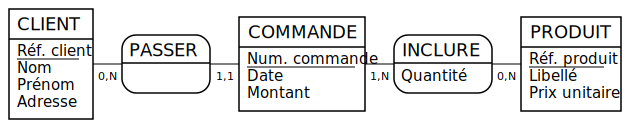

In [322]:
%%mocodo
CLIENT: Réf. client, Nom, Prénom, Adresse
PASSER, 0N CLIENT, 11 COMMANDE
COMMANDE: Num. commande, Date, Montant
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantité
PRODUIT: Réf. produit, Libellé, Prix unitaire

La syntaxe ne devrait pas poser problème :
- une entité est définie par :
    - son nom,
    - deux-points,
    - sa liste d'attributs séparés par des virgules ;
- une association est définie par :
    - son nom,
    - virgule,
    - les cardinalités et l'entité distinguée par sa première patte,
    - virgule,
    - les cardinalités et l'entité de sa deuxième patte,
    - etc.,
    - deux-points,
    - sa liste d'attributs séparés par des virgules.

À noter :
- le premier attribut d'une entité est considéré par défaut comme son identifiant, et donc souligné;
- pour les associations sans attributs, le deux-points est facultatif;
- la première ligne:
        %%mocodo
  ... ne fait pas partie de la description. Dans ce document, elle permet de faire appel à une « commande magique », qui lance Mocodo sur les lignes qui la suivent. Sauf sous Jupyter Notebook, vous pouvez l'omettre dans votre texte d'entrée.
  De façon générale, la ou les premières lignes d'un MCD qui commencent par le symbole de pourcentage (`%`) sont ignorées. Cela permet de placer en en-tête un commentaire qui pourra être préservé lors des éventuels réarrangements ultérieurs.
- Les accents présents dans votre fichier d'entrée sont correctement gérés pourvu que vous ayez enregistré celui-ci dans l'encodage attendu par Mocodo en entrée: c'est par défaut Unicode UTF-8. Une tolérance existe: si Mocodo échoue à décoder votre fichier avec `utf8`, il se rabattra sur le codec d'Europe de l'Ouest associé historiquement à votre plateforme: `iso-8859-15` pour Windows et Linux, `mac-roman` pour macOS. Si les accents n'apparaissent pas correctement, vous aurez encore trois solutions:
  1. soit (fortement conseillé), ré-enregistrer votre fichier en UTF-8 au lieu d'un encodage historique;
  3. soit (ponctuellement), passer l'encodage de votre fichier en argument avec `--encodings`;
  2. soit (à long terme), modifier dans `params.json` la liste des encodages pris en charge.

### Dépendances fonctionnelles entre entités

Lorsque l'une des cardinalités maximales d'une association binaire est 1 (ou à défaut 0), on désigne parfois cette association sous le nom de **dépendance fonctionnelle**. Certains auteurs la figurent par un cercle portant le symbole DF : cela leur évite de se creuser la tête pour trouver un nom à une association qui disparaîtra corps et bien au moment du passage au relationnel. Enfin, une flèche peut indiquer le sens de la dépendance :

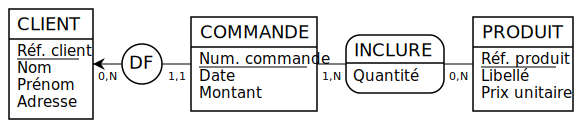

In [14]:
%%mocodo
CLIENT: Réf. client, Nom, Prénom, Adresse
DF, 0N> CLIENT, 11 COMMANDE
COMMANDE: Num. commande, Date, Montant
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantité
PRODUIT: Réf. produit, Libellé, Prix unitaire

Si on a plusieurs dépendances fonctionnelles à représenter, on devra suffixer le DF par un chiffre de 0 à 9 (cf. [cet exemple](#Cr%C3%A9ation-de-plusieurs-entit%C3%A9s-ou-associations-de-m%C3%AAme-nom)).

### Associations réflexives

Quelquefois appelées **circulaires**, **unaires** ou **récursives**, elles associent une entité à elle-même.

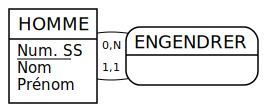

In [15]:
%%mocodo
HOMME: Num. SS, Nom, Prénom
ENGENDRER, 0N HOMME, 11 HOMME

### Placement sur plusieurs rangées

Mocodo combine les avantages de l'approche _diagram as code_ (comme PlantUML, Mermaid ou Graphviz), avec la liberté de positionnement offerte par les logiciels WYSIWYG (_what you see is what you get_).

L'ordre et la séparation des lignes de la description permet de spécifier à coût zéro un plongement grossier, mais qui s'avère en général suffisant:

- les boîtes (entités et associations) définies sur des lignes consécutives sont tracées sur une même rangée;
- un saut de ligne indique une nouvelle rangée.

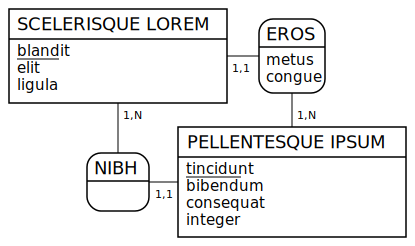

In [16]:
%%mocodo
SCELERISQUE LOREM: blandit, elit, ligula
EROS, 11 SCELERISQUE LOREM, 1N PELLENTESQUE IPSUM: metus, congue

NIBH, 1N SCELERISQUE LOREM, 11 PELLENTESQUE IPSUM
PELLENTESQUE IPSUM: tincidunt, bibendum, consequat, integer

Les boîtes sont placées aux intersections d'une grille invisible assurant que leurs centres soient alignés aussi bien horizontalement que verticalement. C'est ce qui en général est le plus satisfaisant esthétiquement, mais d'autres retouches peuvent être opérées manuellement dans le fichier de sortie.

Le plongement fait l'objet d'une « compression » horizontale et verticale. Par exemple, ci-dessus, il y a un espace horizontal négatif entre le bord droit de l'entité de gauche et le bord gauche de l'entité de droite.

## Besoins plus avancés

### Modifications du texte-source : principes

**Nouveautés de la version 4.0.** L'analyse syntaxique du texte-source décrivant un MCD est désormais complètement séparée de son traitement (fermant ainsi l'[issue 77](https://github.com/laowantong/mocodo/issues/77)).

Une conséquence immédiate est l'introduction de la coloration syntaxique dans [Mocodo online](https://www.mocodo.net), ainsi que la création du plugin [Mocodo syntax highlighter]( https://marketplace.visualstudio.com/items?itemName=laowantong.vscode-mocodo) pour VS-Code.

Ce travail a également permis d'améliorer certaines fonctionnalités et d'en créer facilement de nouvelles. Mocodo 4.0 introduit donc la notion de **modification du texte-source**. Elle regroupe toutes les opérations qui transforment un MCD syntaxiquement correct en un autre MCD. Par exemple :

- la mise en miroir et le réarrangement, qui existaient déjà ;
- l'obfuscation d'un MCD, qui se voit accompagnée d'une possibilité de randomisation des cardinalités ;
- l'effacement des attributs ou des cardinalités pour créer des « exercices à trous » ;
- la rectification des cardinalités mal formées (qui se fait maintenant à la demande) ;
- l'homogénéisation de la mise en forme (capitalisation, séparateurs, diacritiques, ...) ;
- la décomposition d'un MCD donné pour n'employer que des DF sans attributs.

#### Pipeline d'opérations de modification

Toutes ces opérations peuvent maintenant être enchaînées dans une même commande de modification à l'aide de la syntaxe suivante :

```
mocodo --modify op1 op2 op3
```

ou en abrégé :

```
mocodo -m op1 op2 op3
```

Par exemple, vous pouvez décomposer les associations n-aires, convertir les libellés des attributs en minuscules et calculer un nouveau plongement d'un seul coup, sans avoir besoin de copier-coller le résultat d'une opération pour le fournir à la suivante.

Dans les versions précédentes, toutes les opérations de modification étaient terminales. Désormais, Mocodo les exécute en premier, puis applique au texte-source résultant toutes les opérations restantes (p. ex., tracé du MCD, conversion en MLD, etc.).

#### Affichage du résultat et persistance

Le post-traitement dépend du support d'exécution :

- Sous Jupyter Notebook sont affichés en sortie, dans cet ordre, le diagramme conceptuel (sauf avec l'option `--no_mcd`), le diagramme relationnel (avec l'option `--mld`), enfin le nouveau texte-source (sauf avec l'option `--no_text`). Alternativement, l'option `--replace` supprime toutes les sorties, mais met à jour le contenu de la cellule (contribution de Thomas Giro pour la version 2.0.20).
- Sur le web (Mocodo online), le texte d'entrée est mis à jour.
- En ligne de commande, le fichier d'entrée (p. ex., `sandbox.mcd`) est mis à jour.

#### Exemples

Voici le résultat d'une séquence d'opérations de modification :

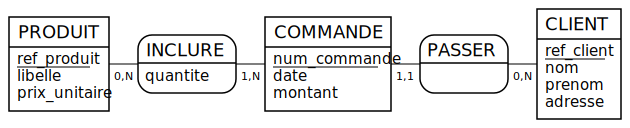

%%mocodo
PRODUIT: ref_produit, libelle, prix_unitaire
INCLURE, 1N COMMANDE, 0N PRODUIT: quantite
COMMANDE: num_commande, date, montant
PASSER, 0N CLIENT, 11 COMMANDE
CLIENT: ref_client, nom, prenom, adresse


In [15]:
%%mocodo -r flip:v labels:ascii,snake
CLIENT: Réf. client, Nom, Prénom, Adresse
PASSER, 0N CLIENT, 11 COMMANDE
COMMANDE: Num. commande, Date, Montant
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantité
PRODUIT: Réf. produit, Libellé, Prix unitaire

Pour tester l'option `--replace`, créez une cellule avec le texte ci-dessous :

```
%%mocodo --update flip:v labels:ascii,snake --replace
CLIENT: Réf. client, Nom, Prénom, Adresse
PASSER, 0N CLIENT, 11 COMMANDE
COMMANDE: Num. commande, Date, Montant
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantité
PRODUIT: Réf. produit, Libellé, Prix unitaire
```

Son exécution devrait remplacer son propre contenu par :

```
%%mocodo
CLIENT: Réf. client, Nom, Prénom, Adresse
PASSER, 0N CLIENT, 11 COMMANDE
COMMANDE: Num. commande, Date, Montant
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantité
PRODUIT: Réf. produit, Libellé, Prix unitaire
```

Réévaluez alors ce nouveau contenu pour tracer le MCD résultant, ou annulez la dernière opération pour revenir au contenu originel.

Notez que sans argument (ou avec l'argument `echo`), l'option `-m` n'applique aucune modification. Cela peut être utile pour visualiser le texte-source d'un MCD enregistré sur le disque :

In [20]:
%mocodo --input sandbox -u --no_mcd

%%mocodo
PRODUIT: ref_produit, libelle, prix_unitaire
INCLURE, 1N COMMANDE, 0N PRODUIT: quantite
COMMANDE: num_commande, date, montant
PASSER, 0N CLIENT, 11 COMMANDE
CLIENT: ref_client, nom, prenom, adresse


### Identifiants composites

Préfixer d'un tiret bas (`_`) les second, troisième, etc. attributs pour les inclure à l'identifiant.

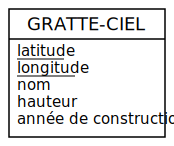

In [21]:
%%mocodo
GRATTE-CIEL: latitude, _longitude, nom, hauteur, année de construction

### Flèches sur les pattes

Suffixer d'un chevron (`<` ou `>`) les cardinalités de la patte concernée. La direction indiquée se lit en partant de l'association et en allant vers l'entité.

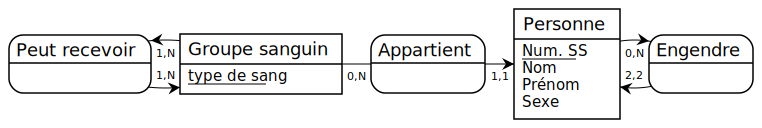

In [22]:
%%mocodo
Peut recevoir, 1N> Groupe sanguin, 1N< Groupe sanguin
Groupe sanguin: type de sang
Appartient, 11> Personne, 0N Groupe sanguin
Personne: Num. SS, Nom, Prénom, Sexe
Engendre, 0N< Personne, 22> Personne

La position de la flèche sur la patte peut être réglée individuellement dans l'objet `ratio` du fichier de géométrie généré (par défaut, `sandbox_geo.json`) ou sous l'onglet _Retouches_ de la version en ligne. La valeur correspondante peut varier de `0.0` (flèche cachée sous la boîte d'origine) à `1.0` (par défaut, pointe de la flèche au contact du bord de la boîte de destination, compte non tenu de l'arrondi s'il s'agit d'une association).

### Styles

Plusieurs styles prédéfinis sont distribués avec l'application. Un style se définit comme la combinaison d'une palette de couleurs (répertoire `colors`) avec un dictionnaire de polices et de dimensions (répertoire `shapes`). Un changement d'échelle d'un facteur multiplicatif positif peut être précisé avec l'argument `--scale`.

Vous pouvez bien sûr créer vos propres styles en vous inspirant des fichiers fournis. Si vous êtes particulièrement content d'un style, soumettez-le pour inclusion dans une prochaine distribution.

**Nouveauté de la version 3.0.** Une approximation de la largeur des caractères des différentes polices a été pré-calculée sous macOS. Il est possible qu'elle soit inexacte, en particulier sous Windows ou Linux. Dans ce cas, en particulier, les traits de soulignement n'atteindront pas ou excéderont la largeur des libellés soulignés. Vous pouvez contourner le problème en appliquant un facteur multiplicatif avec l'argument `--adjust_width`).

### Insérer les types de données

Chaque attribut peut être assorti de notes entre crochets. Ignorées au niveau du tracé du MCD, elles sont [interprétées comme des types de données lors de la génération d'un code-source SQL](#Sorties-SQL).

#### Créer un espace réservé aux types

**Nouveauté de la version 4.0.** L'option `-u types:create` ajoute automatiquement des crochets vides à tous les endroits où un type est attendu.

In [24]:
%%mocodo -u types:create --no_mcd
CLIENT: Réf. client, Nom, Prénom, Adresse
PASSER, 0N CLIENT, 11 COMMANDE
COMMANDE: Num. commande, Date, Montant
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantité
PRODUIT: Réf. produit, Libellé, Prix unitaire

%%mocodo
CLIENT: Réf. client [], Nom [], Prénom [], Adresse []
PASSER, 0N CLIENT, 11 COMMANDE
COMMANDE: Num. commande [], Date [], Montant []
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantité []
PRODUIT: Réf. produit [], Libellé [], Prix unitaire []


#### Deviner les types à partir des noms

**Nouveauté de la version 4.0.** Avec l'option `-u types:guess` Mocodo essaiera de déduire les types manquants des libellés des attributs. Les types devinés sont préfixés d'un point d'interrogation, à supprimer après contrôle de pertinence.

In [25]:
%%mocodo -u types:guess --no_mcd
CLIENT: Réf. client, Nom, Prénom, Adresse
PASSER, 0N CLIENT, 11 COMMANDE
COMMANDE: Num. commande, Date, Montant
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantité
PRODUIT: Réf. produit, Libellé, Prix unitaire

%%mocodo
CLIENT: Réf. client [VARCHAR(8)?], Nom [VARCHAR(255)?], Prénom [VARCHAR(255)?], Adresse []
PASSER, 0N CLIENT, 11 COMMANDE
COMMANDE: Num. commande [VARCHAR(8)?], Date [DATE?], Montant [DECIMAL(10,2)?]
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantité [INTEGER?]
PRODUIT: Réf. produit [VARCHAR(8)?], Libellé [VARCHAR(50)?], Prix unitaire [DECIMAL(10,2)?]


La langue définie avec l'option `--language` est prioritaire, mais l'anglais prend la relève en cas d'échec. 

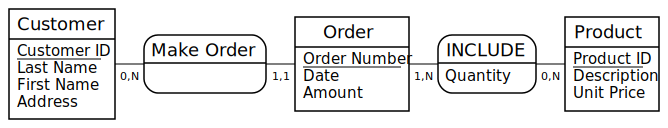

%%mocodo
Customer: Customer ID [VARCHAR(8)?], Last Name [VARCHAR(255)?], First Name [VARCHAR(255)?], Address []
Make Order, 0N Customer, 11 Order
Order: Order Number [], Date [DATE?], Amount [DECIMAL(10,2)?]
INCLUDE, 1N Order, 0N Product: Quantity [INTEGER?]
Product: Product ID [VARCHAR(8)?], Description [TEXT?], Unit Price [DECIMAL(10,2)?]


In [26]:
%%mocodo -u types:guess
Customer: Customer ID, Last Name, First Name, Address
Make Order, 0N Customer, 11 Order
Order: Order Number, Date, Amount
INCLUDE, 1N Order, 0N Product: Quantity
Product: Product ID, Description, Unit Price

La liste des types utilisée est [celle-ci](https://en.wikibooks.org/wiki/Structured_Query_Language/Data_Types). Consultez le code-source de [`_types.py`](https://github.com/laowantong/mocodo/blob/master/mocodo/update/_types.py) pour plus de détails, et n'hésitez pas à [ouvrir le débat](https://github.com/laowantong/mocodo/issues/new) si vous avez des corrections ou des suggestions.

### Cardinalités

#### Changer le format des cardinalités

Par défaut, les cardinalités sont séparées par une virgule.

**Nouveauté de la version 2.1.** On peut maintenant opter pour un format quelconque :

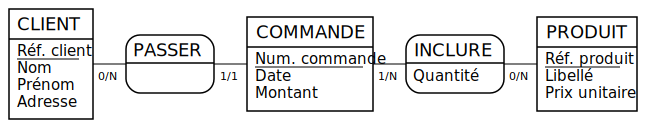

In [27]:
%%mocodo --card_format={min_card}/{max_card}
CLIENT: Réf. client, Nom, Prénom, Adresse
PASSER, 0N CLIENT, 11 COMMANDE
COMMANDE: Num. commande, Date, Montant
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantité
PRODUIT: Réf. produit, Libellé, Prix unitaire

#### Rectifier les cardinalités mal formées

L'option `-u cards:fix` corrige les fautes de frappe usuelles (inversion des cardinalités minimale et maximale, lettre « O » au lieu du chiffre « 0 ») :

| formes erronées | forme rectifiée |
|:----------------|:----------------|
| `O1`, `o1`, `10`, `1O`, `1o` | `01` |
| `ON`, `oN`, `NO`, `No`, `N0` | `0N` |
| `On`, `on`, `no`, `nO`, `n0` | `0n`|
| `N1` | `1N` |
| `n1` | `1n` |

In [28]:
%%mocodo -u cards:fix --no_mcd
Personne: num. SS, Nom de Famille, Prénom, Sexe
Engendrer, oN [parent] Personne, N0 [enfant] Personne

%%mocodo
Personne: num. SS, Nom de Famille, Prénom, Sexe
Engendrer, 0N [parent] Personne, 0N [enfant] Personne


**NB.** Les cardinalités (N,N), qui selon une certaine école dénotent une cardinalité minimale supérieure à 1, sont laissées telles quelles.

**Changement de la version 4.0.** Ces modifications ne sont plus appliquées automatiquement mais à la demande.

### Changer le symbole de dépendance fonctionnelle

Il est possible d'activer l'encerclement d'un autre sigle que DF. C'est ce sigle qui devra alors apparaître en entrée, par exemple:

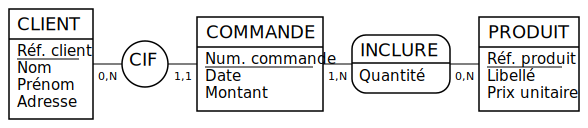

In [29]:
%%mocodo --df=CIF
CLIENT: Réf. client, Nom, Prénom, Adresse
CIF, 0N CLIENT, 11 COMMANDE
COMMANDE: Num. commande, Date, Montant
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantité
PRODUIT: Réf. produit, Libellé, Prix unitaire

Comme le cercle est alors un peu plus grand, on peut vouloir régler (_a priori_ une fois pour toutes) le ratio défini dans l'objet `shapes` du fichier appelé par défaut `sandbox_geo.json`):

```
"df_text_height_ratio" : 1.00,
```

### Créer plusieurs entités ou associations de même nom

Normalement on doit choisir des noms différents pour toutes les boîtes (entités et associations) du MCD, à l'exception des associations de dépendance fonctionnelle figurées par un sigle. On a vu que dans ce cas, il suffisait d'ajouter à leur nom un chiffre de 0 à 9 : celui-ci n'apparaîtra pas en sortie.

Cette possibilité vaut pour n'importe quelle boîte, y compris les triangles dénotant l'héritage (p. ex. `/1\` ou `/XT2\`).

Seul le dernier chiffre est concerné. Cela limite à 10 le nombre d'entités ou associations homonymes, mais peut être utile si vous avez besoin, pour une raison ou une autre, qu'un suffixe numérique apparaisse dans le nom d'une boîte. Il suffit alors d'ajouter encore un chiffre à celui-ci.

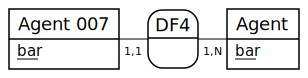

In [438]:
%%mocodo
Agent 0070: bar
DF42, 11 Agent 0070, 1N Agent1
Agent1: bar

La création de boîtes homonymes servira typiquement à « distribuer » une entité DATE réduite à son identifiant _date_, mais associée à de nombreuses entités qui n'ont rien à voir entre elles. Sachant qu'une telle entité est amenée à disparaître lors du passage au relationnel, il n'y a aucun inconvénient à en créer plusieurs, et cela peut avoir l'avantage de faciliter (ou même de rendre possible) l'obtention d'une bonne mise en page.

Par exemple, la mise en page du MCD suivant est indûment complexifiée par le haut degré de l'entité DATE.

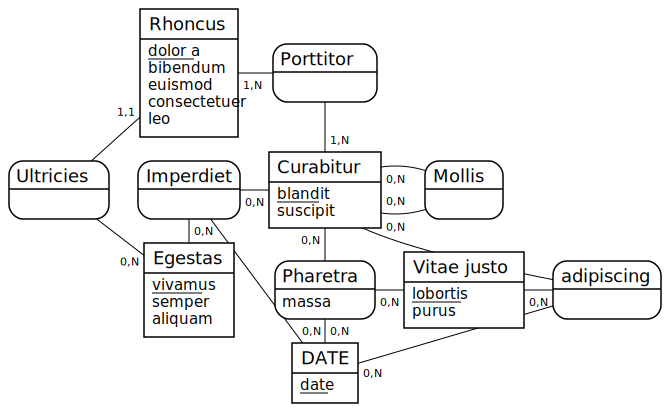

In [31]:
%%mocodo
:
Rhoncus: dolor a, bibendum, euismod, consectetuer, leo
Porttitor, 1N Rhoncus, 1N Curabitur
:
:

Ultricies, 11 Rhoncus, 0N Egestas
Imperdiet, 0N Egestas, 0N Curabitur, 0N DATE
Curabitur: blandit, suscipit
Mollis, 0N Curabitur, 0N Curabitur
:

:
Egestas: vivamus, semper, aliquam
Pharetra, 0N Curabitur, 0N DATE, 0N Vitae justo: massa
Vitae justo: lobortis, purus
adipiscing, 0N Curabitur, 0N Vitae justo, 0N DATE

:
:
DATE: date
:
:

Ajouter une autre entité DATE (sous le nom de DATE2) permettra à Mocodo de calculer une mise en page à la fois plus agréable à l'œil et plus compacte (à savoir, $4\times3$ au lieu de $5\times4$). La sémantique est inchangée.

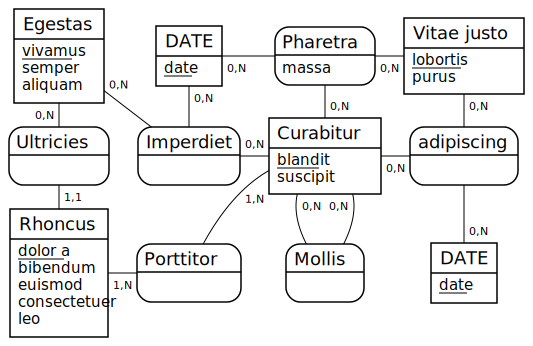

In [32]:
%%mocodo
Egestas: vivamus, semper, aliquam
DATE: date
Pharetra, 0N Curabitur, 0N DATE, 0N Vitae justo: massa
Vitae justo: lobortis, purus

Ultricies, 11 Rhoncus, 0N Egestas
Imperdiet, 0N Egestas, 0N Curabitur, 0N DATE
Curabitur: blandit, suscipit
adipiscing, 0N Curabitur, 0N Vitae justo, 0N DATE2

Rhoncus: dolor a, bibendum, euismod, consectetuer, leo
Porttitor, 1N Rhoncus, 1N Curabitur
Mollis, 0N Curabitur, 0N Curabitur
DATE2: date

### Homogénéiser la mise en forme

Le MCD ci-dessous n'applique aucune règle stricte de capitalisation (« Num commande » / « Prix Unitaire » / « date ») ou d'abréviation (« Réf. client » / « RefProduit » / « Num commande »).

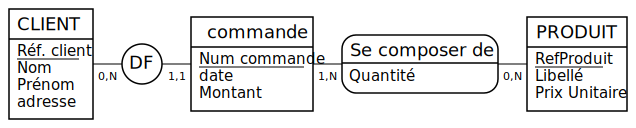

In [33]:
%%mocodo
CLIENT: Réf. client, Nom, Prénom, adresse
DF, 0N CLIENT, 11 commande
commande: Num commande, date, Montant
Se composer de, 1N commande, 0N PRODUIT: Quantité
PRODUIT: RefProduit, Libellé, Prix Unitaire

Ces petits défauts trahissent peut-être un manque de soin, mais ne nuisent pas à la compréhension du MCD. Par contre, ils risquent de devenir agaçants lors de l'écriture de requêtes SQL. S'il n'existe pas de convention universelle pour la présentation des libellés apparaissant dans une base de données, on s'accorde à prôner la cohérence des choix de mise en forme. Mocodo 4 peut vous aider à atteindre cet objectif avec les opérations suivantes :

| Nom | Comportement |
|:----|:-------------|
| `ascii` | Suppression des accents et autres diacritiques |
| `camel` | Conversion en [camelCase](https://en.wikipedia.org/wiki/Camel_case) |
| `capitalize` | Conversion de la première lettre en majuscule et des autres en minuscules ([doc](https://docs.python.org/3/library/stdtypes.html#str.capitalize)) |
| `casefold` | Conversion agressive en minuscules ([doc](https://docs.python.org/3/library/stdtypes.html#str.casefold)) |
| `lower` | Conversion en minuscules ([doc](https://docs.python.org/3/library/stdtypes.html#str.lower)) |
| `snake` | Conversion en [snake_case](https://en.wikipedia.org/wiki/Snake_case) |
| `swapcase` | Conversion des majuscules en minuscules et vice-versa ([doc](https://docs.python.org/3/library/stdtypes.html#str.swapcase)) |
| `title` | Conversion des premières lettres en majuscules et des autres en minuscules ([doc](https://docs.python.org/3/library/stdtypes.html#str.title)) |
| `upper` | Conversion en majuscules ([doc](https://docs.python.org/3/library/stdtypes.html#str.upper)) |

Elles peuvent être appliquées à n'importe quel [token](https://en.wikipedia.org/wiki/Lexical_analysis#Lexical_token_and_lexical_tokenization) défini dans la [grammaire du langage](https://github.com/laowantong/mocodo/tree/master/mocodo/resources/grammar.lark), notamment :

- `box_name`, le nom d'une entité ou d'une association ;
- `attr`, le libellé d'un attribut d'entité ou d'association ;
- `card`, les deux caractères définissant les cardinalités minimale et maximale.

L'application d'une opération `op` à un token `tk` s'écrit simplement `op_tk`. Ainsi, la commande suivante passe en majuscules le nom des boîtes et en minuscules leurs attributs :

In [34]:
%%mocodo -u box_name:upper,attr:lower --no_mcd
CLIENT: Réf. client, Nom, Prénom, adresse
DF, 0N CLIENT, 11 commande
commande: Num commande, date, Montant
Se composer de, 1N commande, 0N PRODUIT: Quantité
PRODUIT: RefProduit, Libellé, Prix Unitaire

Mocodo Err.651 - Unknown update operation: box_name


Les pseudo-tokens suivants peuvent servir de raccourcis :

- `labels` englobe `box_name`, `attr` et `leg_note` ;
- `notes` englobe `leg_note` et `constraint_note`.

Par exemple, pour convertir en ASCII et en _snake case_ tous les libellés susceptibles d'être ultérieurement manipulés en SQL :

In [35]:
%%mocodo -u labels:ascii,snake box_name:upper --no_mcd
CLIENT: Réf. client, Nom, Prénom, adresse
DF, 0N CLIENT, 11 commande
commande: Num commande, date, Montant
Se composer de, 1N commande, 0N PRODUIT: Quantité
PRODUIT: RefProduit, Libellé, Prix Unitaire

Mocodo Err.651 - Unknown update operation: box_name


Notez enfin que, pour la commodité de l'utilisateur, si le nom donné comme token se termine par un _s_, celui-ci est supprimé. Il est donc équivalent (mais plus intuitif) d'écrire `lower_box_names` au lieu de `lower_box_name`.

## Extensions du modèle

### Entités faibles (ou identification relative)

Préfixer d'un tiret bas (`_`) une cardinalité (1,1) pour indiquer que l'entité distinguée est faible. Dans le diagramme, les identifiants (ou discriminants) d'une telle entité seront soulignés en pointillés, tandis que le (1,1) sera souligné d'un trait plein.

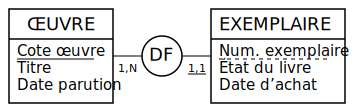

In [25]:
%%mocodo
ŒUVRE: Cote œuvre, Titre, Date parution
DF, 1N ŒUVRE, _11 EXEMPLAIRE
EXEMPLAIRE: Num. exemplaire, État du livre, Date d'achat

Une association ne peut renforcer plus d'une entité faible. Ainsi, une erreur se produit si l'on remplace le `1N` par `_11`:

In [44]:
%%mocodo
ŒUVRE: Cote œuvre, Titre, Date parution
DF, _11 ŒUVRE, _11 EXEMPLAIRE
EXEMPLAIRE: Num. exemplaire, État du livre, Date d'achat

Mocodo Err.22 - Identification relative réciproque autour de « DF ».


**Nouveauté de la version 2.1.** Des notations plus traditionnelles de l'identification relative peuvent être obtenues avec l'option `--strengthen_card`:

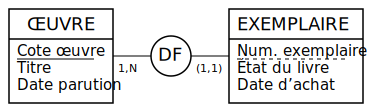

In [47]:
%%mocodo --strengthen_card "(1,1)"
ŒUVRE: Cote œuvre, Titre, Date parution
DF, 1N ŒUVRE, _11 EXEMPLAIRE
EXEMPLAIRE: Num. exemplaire, État du livre, Date d'achat

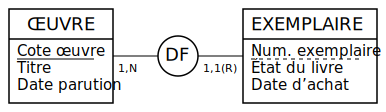

In [48]:
%%mocodo --strengthen_card "1,1(R)"
ŒUVRE: Cote œuvre, Titre, Date parution
DF, 1N ŒUVRE, _11 EXEMPLAIRE
EXEMPLAIRE: Num. exemplaire, État du livre, Date d'achat

### Visualisation des contraintes sur les associations

**Nouveauté de la version 3.2.** Certains utilisateurs avancés de Mocodo ont besoin d'exprimer au niveau conceptuel les contraintes sur associations introduites par Merise 2. Jusqu'ici, ils devaient utiliser un éditeur graphique pour ajouter « à la main » les éléments correspondants. Ils peuvent dorénavant le faire sous Mocodo. Attention, la prise en charge de ces extensions est purement visuelle : le passage au niveau relationnel et/ou physique les ignorera.

#### Des ronds

D'un point de vue purement visuel, donc, une telle contrainte est figurée par un petit rond portant jusqu'à trois lettres:

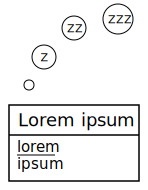

In [49]:
%%mocodo
(): 20, 45
(Z): 30, 30
(ZZ): Lorem ipsum, 15
(ZZZ): 80, 10

:

:
    
:

:

Lorem ipsum: lorem, ipsum

La syntaxe nécessite quelques explications.

1. Au contraire des boîtes (entités et associations), les contraintes ne sont pas... contraintes par la grille sous-jacente : la mise en page du MCD n'en tient absolument pas compte. Celui de cet exemple a donc dû être « aéré » pour leur faire de la place : ainsi, les quatre paragraphes réduits à un deux-points ont inséré quatre rangées au début de la grille.
2. Chaque membre du couple de « coordonnées » qui termine les définitions de contraintes peut être :
  - soit un nombre, qui représente un pourcentages de la largeur ou de la hauteur du diagramme où centrer cette contrainte ;
  - soit (nouveauté de la version 4.0) un nom de boîte, avec le centre de laquelle aligner horizontalement ou verticalement cette contrainte. Par exemple, la « coordonnée » _Lorem Ipsum_ donne à la contrainte ZZ la même abscisse que la boîte _Lorem ipsum_.
3. De tout cela, il résulte que le positionnement des contraintes est plutôt de l'ordre de la retouche : ne vous en occupez pas tant que les boîtes risquent de bouger.
4. Les clauses de définition des contraintes peuvent apparaître n'importe où. Notez cependant que tout réarrangement automatique les enverra systématiquement à la fin du texte-source.

De la même manière qu'avec les cardinalités, on peut insérer un court texte entre crochets qui apparaîtra au survol de la contrainte.

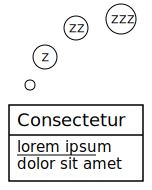

In [50]:
%%mocodo
() [adipiscing elit]: 20, 45
(Z) [sed do eiusmod]: 30, 30
(ZZ) [tempor incididunt] : Consectetur, 15
(ZZZ) [ut labore]: 80, 10

:

:
    
:

:

Consectetur: lorem ipsum, dolor sit amet

#### Des traits

Les contraintes sont normalement liées par des traits pleins (`--`) ou pointillés (`..`) à un certain nombre de boîtes (entités ou associations). Une flèche (`>` ou `<`) peut être ajoutée ou substituée à l'une et/ou l'autre des extrémités d'un trait.

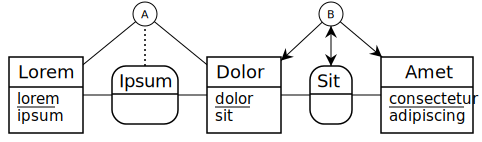

In [51]:
%%mocodo
(A) --Lorem, ..Ipsum, -Dolor: Ipsum, 10
(B) ->Dolor, <-->Sit, -->Amet: Sit, 10

:

:

Lorem: lorem, ipsum
Ipsum, XX Lorem, XX Dolor
Dolor: dolor, sit
Sit, XX Dolor, XX Amet
Amet: consectetur, adipiscing

#### Exemple

Voici un exemple plus réaliste, adapté de la Fig. 7.37 de _Merise, deuxième génération_ (Dominique Nanci et Bernard Espinasse, 4e éd., 2001) :

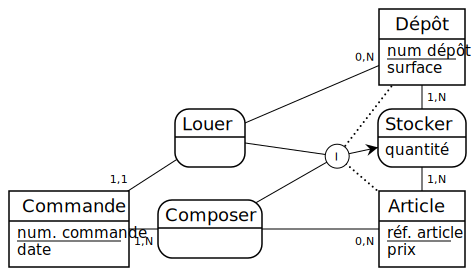

In [52]:
%%mocodo
:::::
Dépôt: num dépôt, surface

:
Louer, 11 Commande, 0N Dépôt
:::
Stocker, 1N Dépôt, 1N Article: quantité

Commande: num. commande, date
Composer, 1N Commande, 0N Article
:::
Article: réf. article, prix

(I) ->Stocker, ..Dépôt, ..Article, --Composer, --Louer

Notez que le couple de coordonnées est manquant. Dans ce cas, le moteur de plongement fait coïncider le centre de chaque contrainte avec le barycentre des boîtes qu'elle met en jeu. Le positionnement ainsi défini a plus de chances de rester correct si le MCD évolue.

#### Boîtes fictives et traits invisibles

On peut tirer parti de ce mécanisme en intégrant (fictivement) d'autres boîtes à la définition de la contrainte, ou même en en répétant certaines. Dans ces deux cas, bien entendu, le trait devra être rendu invisible (il suffit de l'omettre). Par exemple, intégrer l'entité Commande et répéter l'association Stocker permet de réduire la largeur du MCD sans compromettre sa lisibilité. Ci-dessous, on a en outre indenté la définition de la contrainte pour la placer sur un second calque :

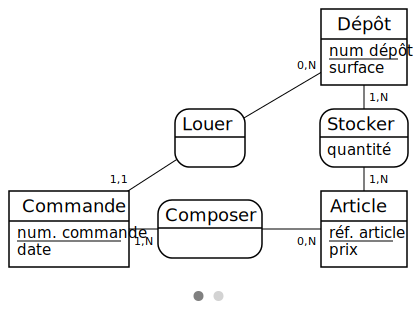

In [53]:
%%mocodo
:::
Dépôt: num dépôt, surface

:
Louer, 11 Commande, 0N Dépôt
:
Stocker, 1N Dépôt, 1N Article: quantité

Commande: num. commande, date
Composer, 1N Commande, 0N Article
:
Article: réf. article, prix

  (I) ->Stocker, ..Dépôt, ..Article, --Composer, --Louer, Commande, Stocker

Redisons-le : à l'heure actuelle (16h36), seul l'aspect graphique des contraintes est implanté. L'éventuel aspect relationnel de certains types de contraintes est déjà pris en charge par Mocodo, mais d'une autre manière. C'est ce que nous allons voir dans les deux sections suivantes.

### Agrégation (ou pseudo-entité)

#### Problématique

Le MCD ci-dessous a (au moins) un défaut :

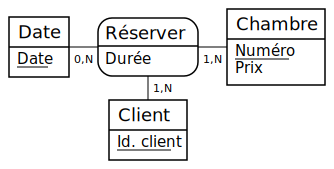

**Chambre** (<ins>Numéro</ins>, Prix)<br>
**Réserver** (<ins>Id. client</ins>, <ins>_#Numéro_</ins>, <ins>Date</ins>, Durée)


In [52]:
%%mocodo --mld
Date: Date
Réserver, 1N Client, 1N Chambre, 0N Date: Durée
Chambre: Numéro, Prix

Client: Id. client

Il n'empêche pas les « sur-réservations » : deux clients peuvent réserver la même chambre pour la même nuit. En effet, une réservation est identifiée par un triplet (date, chambre, client). Plusieurs réservations à la même date, pour la même chambre et avec des clients distincts produisent des identifiants distincts, donc valides.

#### Solution possible : agrégation

La notion d'agrégation peut ici nous tirer d'affaire. Elle permet d'agréger les entités DATE et CHAMBRE, ainsi que l'association RÉSERVER, en une « pseudo-entité » qui sera alors considérée comme associée à l'entité CLIENT.

Syntaxiquement, il suffit de préfixer la cardinalité de CLIENT d'une barre oblique (avant la version 3, c'est le nom de l'entité qui devait être préfixé) :

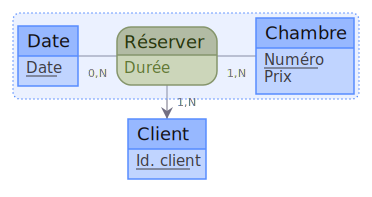

**Chambre** (<ins>Numéro</ins>, Prix)<br>
**Réserver** (<ins>_#Numéro_</ins>, <ins>Date</ins>, Id. client, Durée)


In [56]:
%%mocodo --mld --colors ocean
Date: Date
Réserver, /1N Client, 1N Chambre, 0N Date: Durée
Chambre: Numéro, Prix
    
Client: Id. client

Cette visualisation elle-même est une nouveauté de la version 3. Notez que la représentation traditionnelle demanderait à insérer une association DF entre CLIENT et RÉSERVER, ce qui donnerait à peu près ceci :

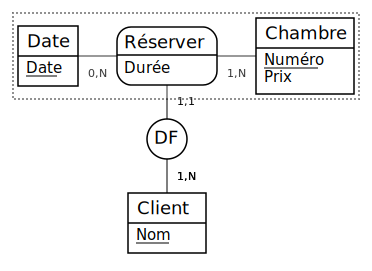

In [56]:
display.SVG("traditional_cluster.svg")

... mais permettre l'association d'une entité et d'une association demanderait à apporter au code de Mocodo des changements conséquents, pour un bénéfice qui ne nous saute pas forcément aux yeux.

**Limitation.** La syntaxe choisie ne permet pas de représenter les CIF à unicité incomplète.

#### Autre solution : CIF

Cette situation s'exprime également à l'aide de la notion de contrainte sur associations, et plus précisément de **contrainte d'intégrité fonctionnelle**. À partir de la version 3.2, on pourra donc choisir d'écrire :

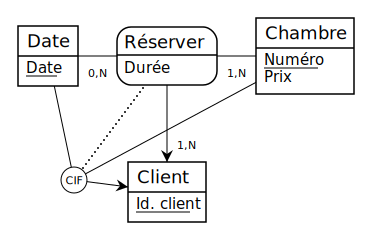

**Chambre** (<ins>Numéro</ins>, Prix)<br>
**Réserver** (<ins>_#Numéro_</ins>, <ins>Date</ins>, Id. client, Durée)


In [57]:
%%mocodo --mld
Date: Date
Réserver, /1N Client, 1N Chambre, 0N Date: Durée
Chambre: Numéro, Prix

:
    
Client: Id. client

(CIF) [Même date, même chambre => un seul client] --Chambre, --Date, ->Client, ..Réserver: 20, 75

Lorsque Mocodo rencontre une définition de CIF dans le texte-source, il désactive par politesse sa visualisation des pseudo-entités. Mais c'est toujours le `/1N Client` qui permet d'obtenir le schéma relationnel attendu : pensez à le mettre.

#### Autre solution : entité faible

Notez qu'on peut se passer de la notion d'agrégation dès lors que l'on a celle d'entité faible. Le même MCD pourrait se représenter ainsi :

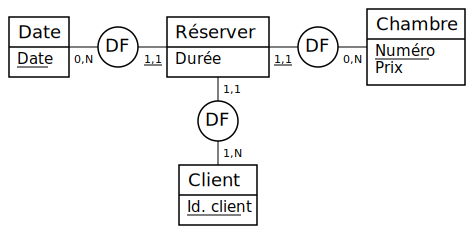

**Chambre** (<ins>Numéro</ins>, Prix)<br>
**Réserver** (<ins>_#Numéro_</ins>, <ins>Date</ins>, Durée, Id. client)


In [435]:
%%mocodo --mld
Date: Date
DF, 0N Date, _11 Réserver
Réserver: _Durée
DF, 0N Chambre, _11 Réserver
Chambre: Numéro, Prix
  
DF, 11 Réserver, 1N Client

Client: Id. client

#### Compléments

Sous Mocodo, l'agrégation est traitée comme un cas particulier de ce que nous appelons une réduction de clé primaire. Le mécanisme est décrit [ici](#R%C3%A9duction-de-cl%C3%A9-primaire-(ou-agr%C3%A9gation,-ou-pseudo-entit%C3%A9)).

Rien ne nous empêche par exemple de créer un agrégat réduit à une seule entité :

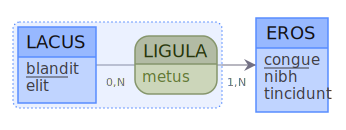

**EROS** (<ins>congue</ins>, nibh, tincidunt)<br>
**LACUS** (<ins>blandit</ins>, elit)<br>
**LIGULA** (<ins>_#blandit_</ins>, _#congue_, metus)


In [60]:
%%mocodo --mld --colors ocean
LACUS: blandit, elit
LIGULA, 0N LACUS, /1N EROS: metus
EROS: congue, nibh, tincidunt

In [78]:
%%mocodo -c chen:layout=circo,mindist=0 defer --shapes=serif --colors=ocean
LACUS: blandit, elit
LIGULA, 0N LACUS, /1N EROS: metus
EROS: congue, nibh, tincidunt

Pour en revenir à la représentation graphique :

- Apparaissent en pointillés la ou les pattes par lesquelles les identifiants vont migrer **en perdant leur caractère identifiant**.
- Une enveloppe de points apparaît autour de l'association et des entités de l'agrégat dans les cas où :
    - il y a au maximum deux entités à agréger ;
    - l'angle formé par l'association et les entités est plat ou rectangle.

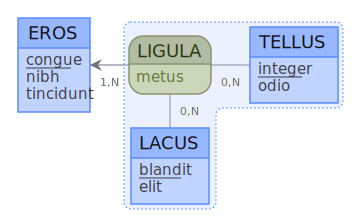

In [61]:
%%mocodo --colors ocean
EROS: congue, nibh, tincidunt
LIGULA, 0N LACUS, /1N EROS, 0N TELLUS: metus
TELLUS: integer, odio

LACUS: blandit, elit

Si ces conditions ne sont pas réunies, pour des raisons de simplicité du code et de clarté du diagramme, l'enveloppe n'est pas affichée. Cependant, les pointillés de la ou des pattes concernées subsistent et le reste des traitements est inchangé.

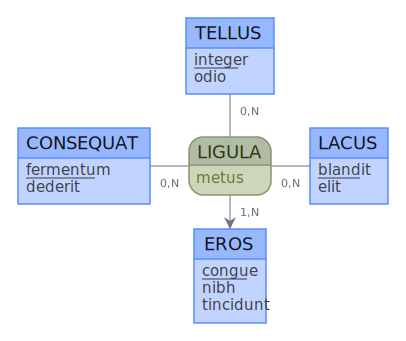

In [62]:
%%mocodo --colors ocean
TELLUS: integer, odio

CONSEQUAT: fermentum, dederit
LIGULA, 0N LACUS, /1N EROS, 0N TELLUS, 0N CONSEQUAT: metus
LACUS: blandit, elit

EROS: congue, nibh, tincidunt

### Conversion forcée d'une association DF en table

Normalement, les associations DF disparaissent lors du passage en relationnel. Il est cependant possible de forcer la création d'une table éponyme. Cela se fait en préfixant d'un + le nom de l'association (avant la version 3, on préfixait d'une barre oblique l'une au moins des entités non distinguées par un 01).

Au niveau visualisation, un rectangle en pointillés apparaît autour de l'association, indiquant que celle-ci va devenir une table.

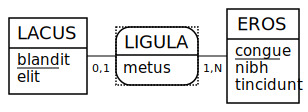

In [81]:
%%mocodo
LACUS: blandit, elit
+LIGULA, 01 LACUS, 1N EROS: metus
EROS: congue, nibh, tincidunt

La motivation et les détails sont discutés dans la section [Passage au relationnel / Conversion forcée d'une association DF en table](#Conversion-forcée-d'une-association-DF-en-table).

### Héritage (ou spécialisation)

#### Introduction

L'héritage permet de regrouper dans une entité, dite « mère », les attributs communs à plusieurs autres entités, dites « filles », qui se distinguent les unes des autres par des attributs spécifiques.

La syntaxe Mocodo est la suivante :
```
/\ Mère <- Fille_1, Fille_2, ... : type
```
Où :
- **Mère** est une entité normale ;
- _Fille_1_, _Fille_2_, etc. sont des entités **sans identifiant** (inutile de les préfixer par un tiret bas, il serait ignoré) ;
- le « triangle » définit le type d'héritage, soit `/\`,  soit `/X\`, soit `/T\`, soit `/XT\`. **Nouveauté de la version 4.0** : s'il y a plusieurs triangles de même type, le suffixe numérique permettant de les distinguer est devenu facultatif ;
- la « flèche » définit le mécanisme de passage au relationnel, soit `<=`, soit `<-`, soit `->`, soit `=>`. Reportez-vous à cette [section](#S%C3%A9mantique-de-la-fl%C3%A8che) ;
- le type (facultatif) n'apparaît pas sur le MCD, mais éventuellement, lors du passage au relationnel, dans la liste des champs de la table-mère ou, en cas de suppression de celle-ci, des tables dans lesquelles migre son identifiant. Il permet de préciser à laquelle des entités-filles on a affaire.

Voici un exemple :

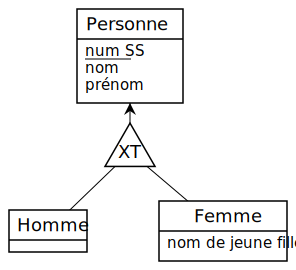

In [66]:
%%mocodo
Personne: num SS, nom, prénom

/XT\ Personne <- Homme, Femme: sexe

Homme: 
:
Femme: nom de jeune fille

#### Les quatre types d'héritage

Selon les symboles inscrits dans le triangle, le MCD précédent s'interprétera ainsi :

| Totalité | Exclusion | Symboles | Exemple de population | Toute personne est : |
|----------|-----------|:------:-:|:---------:|:--------|
| oui        | oui         | `/XT\`  | <big>♂♂♂♂♂♂♂<br>♀♀♀♀♀♀♀♀♀♀</big> | - soit un homme<br>- soit une femme |
| non        | oui         | `/X\`   | <big>♂♂♂♂♂♂♂♂<br>♀♀♀♀♀♀<br>⚬⚬⚬⚬</big> | - soit un homme<br>- soit une femme<br>- soit aucun des deux |
| oui        | non         | `/T\`   | <big>♂♂♂♂♂♂<br>♀♀♀♀♀♀♀♀<br>⚥⚥⚥⚥</big> | - soit un homme<br>- soit une femme<br>- soit les deux à la fois |
| non        | non         | `/\`    | <big>♂♂♂♂♂<br>♀♀♀♀♀♀<br>⚬⚬⚬⚬<br>⚥⚥⚥⚥</big> | - soit un homme<br>- soit une femme<br>- soit aucun des deux<br>- soit les deux à la fois |

Ces contraintes ne sont pas transposables au niveau relationnel, mais pourront être réinjectées au niveau physique (même si Mocodo ne le fait pas actuellement).

#### Représentation graphique

Le type de flèche spécifiant le mécanisme de passage au modèle relationnel (`<=`, `<-`, `->` ou `=>`) fait par défaut l'objet d'une visualisation dès le modèle conceptuel : la ou les pattes vers les entités de destination des attributs migrants sont orientées vers celles-ci ; et la ou les autres pattes sont doublées (pour `<=` et `=>`) ou non (pour `<-` et `->`).

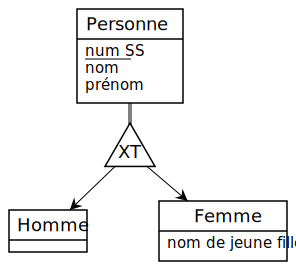

In [67]:
%%mocodo --mld
Personne: num SS, nom, prénom

/XT\ Personne => Homme, Femme: sexe

Homme: 
:
Femme: nom de jeune fille

Cette visualisation n'est pas conventionnelle : par défaut, on se borne à ajouter une flèche dirigée vers l'entité-mère. Pour désactiver l'embellissement opéré par Mocodo, sans pour autant changer le mécanisme de passage au relationnel, prolongez simplement d'un caractère la flèche : `<==`, `<--`, `-->` ou `==>`.

**NB.** Cette syntaxe est une nouveauté de Mocodo 4.0. Dans la version 3, c'était `->>` et `=>>` au lieu de `-->` ou `==>` (respectivement).

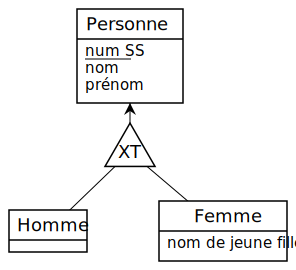

In [69]:
%%mocodo --mld
Personne: num SS, nom, prénom

/XT\ Personne ==> Homme, Femme: sexe

Homme: 
:
Femme: nom de jeune fille

### Identifiants alternatifs

--gutter id:show=auto,strong=ID,weak=id,alts=123456789 type:show=off

--left_gutter {on,off,auto}
                        show the status of candidate identifiers in each
                        entity (default: auto)
  --left_gutter_strong_id STR
                        string to be used in the left gutter for strong
                        identifiers (default: ID)
  --left_gutter_weak_id STR
                        string to be used in the left gutter for weak
                        identifiers (default: id)
  --left_gutter_alt_ids STR [STR ...]
                        strings to be used in the left gutter for alt
                        identifiers (default: ['1', '2', '3', '4', '5', '6',
                        '7', '8', '9'])

#### Définition et syntaxe

**Nouveauté de la version 4.0.** On appelle **identifiant candidat** d'une entité tout sous-ensemble minimal d'attributs dont chaque occurrence est unique. Parmi ces sous-ensembles, l'un est élu **identifiant** (tout court), souligné, et appelé à devenir clé primaire lors du passage au relationnel. Les candidats malheureux sont appelés **identifiants alternatifs**.

Ainsi, dans l'exemple ci-dessus (proposé par Fabien Duchateau), l'ensemble des identifiants candidats de CLIENT est constitué de :

- l'identifiant proprement dit _Réf. client_ ;
- l'identifiant alternatif (_Nom_, _Prénom_) (dont on supposera pour simplifier qu'il assure l'unicité) ;
- l'identifiant alternatif _Mail_.

(Nous changeons de police de caractères pour distinguer plus facilement les 1 des l.)

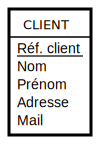

In [70]:
%%mocodo --shapes arial
CLIENT: Réf. client, Nom, Prénom, Adresse, Mail

Mocodo permet de définir, de visualiser et de traiter jusqu'à 10 identifiants candidats par entité. On note `i_nom_attribut` tout attribut appartenant au ième candidat, avec `i` un chiffre de `0` à `9` (le `0`, en général facultatif, représente l'identifiant tout court). Sur l'exemple précédent :

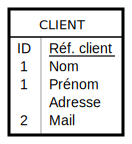

In [75]:
%%mocodo --shapes arial
CLIENT: Réf. client, 1_Nom, 1_Prénom, Adresse, 2_Mail

Par défaut, dès la première déclaration d'un identifiant alternatif, Mocodo fait apparaître une gouttière à gauche des attributs de **toutes** les entités. Y sont reportés :

- un symbole « ID » (resp. « id ») pour l'identifiant fort (resp. faible). Notez que ce symbole est redondant avec le soulignement plein (resp. pointillé) de cet identifiant ;
- des chiffres de 1 à 9 correspondant aux numéros des identifiants alternatifs.

On verra que la notion d'identifiant alternatif se traduit par des [contraintes d'unicité au niveau physique](#Traitement-des-identifiants-alternatifs).

#### Identifiants alternatifs non disjoints

Si certains attributs sont communs à plusieurs identifiants alternatifs, concaténez simplement les numéros de ces identifiants, par exemple :

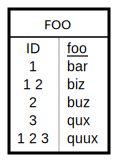

In [58]:
%%mocodo --shapes arial
FOO: foo, 1_bar, 12_biz, 2_buz, 3_qux, 123_quux

Ici, le premier identifiant alternatif est le triplet (_bar_, _biz_, _quux_), le second (_biz_, _buz_, _quux_) et le troisième (_qux_, _quux_).

#### Explicitation de l'identifiant à souligner

Ce cas peut se produire lorsque l'identifiant à souligner a un attribut commun avec un identifiant alternatif. Ce dernier devant être distinct et minimal, cela implique que l'identifiant est composite. Le cas est donc exceptionnel, mais doit être prévu.

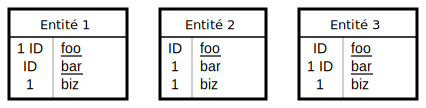

In [74]:
%%mocodo --shapes arial
Entité 10: 1_foo, _bar, 1_biz
Entité 20: foo, 1_bar, 1_biz
Entité 30: foo, 01_bar, 1_biz

- Si l'attribut commun est en tête de liste (ici, _foo_, entité 1), rien ne change, on écrit `1_foo`.
- S'il n'est pas en tête de liste (ici, _bar_, entité 2), l'écriture `1_bar` dénote déjà l'appartenance à un identifiant alternatif. Elle ne peut dénoter simulténement l'appartenance à l'identifiant à souligner.
- C'est pourquoi on doit donc expliciter l'appartenance à l'identifiant à souligner qui, comme on l'a vu, est numéroté `0` (entité 3).

L'autre cas qui demande réflexion est encore plus exotique. C'est un sous-cas de celui où le premier attribut ne fait pas partie de l'identifiant à souligner (entité 4). Si l'on veut alors que ce premier attribut appartienne à une clé alternative, il faut expliciter le `0` (entité 5).

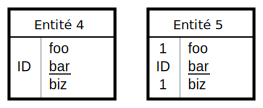

In [60]:
%%mocodo --shapes arial --gutters ids:visibility=on
Entité 40: _foo, _bar, biz
Entité 50: 01_foo, _bar, 1_biz

En résumé, on explicite le `0`, soit pour **empêcher le soulignement du premier attribut**, soit pour **forcer le soulignement d'un attribut suivant**.

Cela devrait vous rappeler quelque chose… Remplacez `0` par `_` dans la phrase précédente et vous retrouverez la règle que vous avez appris à connaître et à aimer : on explicite le `_`, soit pour empêcher le soulignement du premier attribut, soit pour forcer le soulignement d'un attribut suivant.

#### Sous-sous-options de visualisation

La gouttière d'identifiants apparaît automatiquement (`visibility=auto`) dès qu'il y a au moins un identifiant alternatif. Il est possible de ne pas le faire (`visibility=off`) :

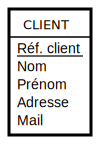

In [61]:
%%mocodo --gutters ids:visibility=off --shapes arial
CLIENT: Réf. client, 1_Nom, 1_Prénom, Adresse, 2_Mail

... ou au contraire de la forcer (`visibility=on`) quand elle est superfétatoire :

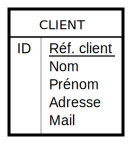

In [63]:
%%mocodo --gutters ids:visibility=on --shapes arial
CLIENT: Réf. client, Nom, Prénom, Adresse, Mail

Vous pouvez aussi préciser quelles chaînes dénoteront un identifiant fort (par défaut, `strong=ID`), un identifiant faible (par défaut, `weak=id`) ainsi que les numéros des groupes d'identifiants alternatifs (par défaut, `alts=123456789`) :

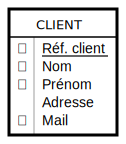

In [71]:
%%mocodo --gutters ids:strong=➤,alts=❶❷ --shapes arial
CLIENT: Réf. client, 1_Nom, 1_Prénom, Adresse, 2_Mail

## Besoins spécifiques à la pédagogie

Si vous n'êtes pas enseignant de bases de données, [téléportez-vous directement à la section suivante](#Trac%C3%A9-d'un-MCD).

### SVG interactifs

#### Afficher l'explication des cardinalités

Les débutants ont souvent des doutes sur la sémantique de telle ou telle cardinalité. Cette information peut être incluse dans le texte-source, en annotant les pattes correspondantes, pour apparaître à la demande lors du rendu (utile pour créer des exercices à faire en TD ou en autonomie).

Survolez les cardinalités du MCD ci-dessous pour faire apparaître leur description.

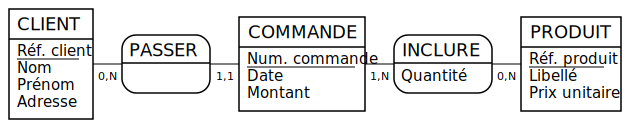

In [79]:
%%mocodo
CLIENT: Réf. client, Nom, Prénom, Adresse
PASSER, 0N [Un client peut passer un nombre quelconque de commandes.] CLIENT, 11 [Toute commande est passée par un en un seul client.] COMMANDE
COMMANDE: Num. commande, Date, Montant
INCLURE, 1N [Une commande peut inclure plusieurs produits distincts, et en inclut au moins un.] COMMANDE, 0N [Certains produits ne sont jamais commandés, d'autres le sont plusieurs fois.] PRODUIT: Quantité
PRODUIT: Réf. produit, Libellé, Prix unitaire

Les notes s'insèrent entre cardinalités et nom de l'entité. Elles sont délimitées par des crochets droits.

Avec l'option `--disambiguation=notes` (par défaut), elles sont également exploitables lors du passage au relationnel pour [préciser la sémantique d'une clé étrangère](#R%C3%A9tablissement-explicite-de-la-s%C3%A9mantique-des-DF-disparues).

L'affichage au survol peut être désactivé avec l'option `--hide_notes`.

**Limitations.**

- Non pris en charge par les éditeurs de SVG comme Inkscape.
- Ne semble pas fonctionner dans une page HTML statique (comme la version HTML de ce document sous GitHub).
- Nécessite de faire confiance à un notebook (Trust notebook) pour s'afficher à la réouverture.

#### Dévoiler un MCD par étapes

**Nouveauté de la version 3.** Il est possible de faire apparaître progressivement les différentes « boîtes » constituant un MCD. Pour cela, il suffit d'indenter (décaler vers la droite à l'aide d'espaces ou de tabulations) au moins une ligne. Les éléments correspondants seront alors répartis sur autant de « calques » qu'il y a de niveaux d'indentations.

Voici par exemple un exercice consistant en la description du « réel perçu » d'une entreprise de VPC :

> 1. Un produit est connu par une référence, un libellé et un prix unitaire.
> 1. Toute commande inclut un produit ou plusieurs, chacun en une certaine quantité.
> 1. Un client peut passer zéro (_client potentiel_) ou plusieurs commandes.
> 1. Un client peut entrer dans la base par parrainage d'un autre client.

L'enseignant peut le présenter pas à pas en suivant les étapes de l'énoncé :

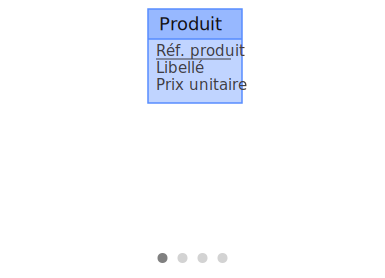

In [80]:
%%mocodo  --colors ocean --shapes copperplate

      Parrainer, 01 Client, 0N Client : date parrainage
Produit: Réf. produit, Libellé, Prix unitaire
  Inclure, 1N Commande, 0N Produit: Quantité
 
    Client: Réf. client, Nom, Prénom, Adresse
    DF, 0N Client, 11 Commande
  Commande: Num. commande, Date, Montant

**Remarques.**
- Pas de règle sur la taille de l'indentation. Pour Mocodo, autant de niveaux d'indentation distincts, autant de calques.
- Pour ajouter facilement de l'interactivité à un MCD existant :
    1. commencez par indenter au maximum toutes les lignes ;
    1. effacez l'indentation des lignes du premier calque ;
    1. décalez votre curseur de $n$ caractères vers la droite ;
    1. placez-vous tour à tour sur les lignes à intégrer au deuxième calque et effacez les espaces surnuméraires ;
    1. recommencez à l'étape 3 jusqu'au dernier calque.
    
  Depuis la version 4.0, l'éditeur de Mocodo online vous permet de créer des curseurs multiples, ce qui simplifie encore ces opérations.
- Les différents calques sont codés directement dans le SVG. L'interaction ne nécessite donc aucun logiciel spécifique.
- Sous Mocodo online, le MCD est toujours présenté entièrement dévoilé. Cela permet de voir directement le résultat d'une modification du texte-source.

**Limitations actuelles.**
- Pas de granularité plus fine que la ligne (entité ou association avec toutes ses pattes et cardinalités).
- Pas de prise en charge des touches directionnelles. Cela serait sans doute possible, mais difficilement compatible avec la présence de plusieurs MCD interactifs sur une même page (comme dans cette documentation).

#### Éviter qu'une interaction sur un SVG ne s'applique à un autre

**Nouveauté de la version 3.1.1.** Dans un cas très rare, à savoir lorsque plusieurs SVG interactifs générés à partir du même texte-source coexistent sur une même page web (ou dans le même notebook), une interaction opérée sur l'un s'applique également à tous les autres. Par exemple, cliquer sur l'un des ronds gris de l'une des figures ci-dessous agira sur les deux figures :

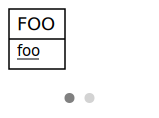

In [81]:
%%mocodo
FOO: foo
  BAR: bar

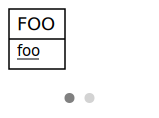

In [82]:
%%mocodo
FOO: foo
  BAR: bar

Ce problème trahit une « collision » : différents éléments du [DOM](https://fr.wikipedia.org/wiki/Document_Object_Model) se sont vus attribuer la même empreinte (obtenue par hachage du texte-source). La solution est de passer un entier discriminant qui, par concaténation, fera de ces empreintes de véritables identifiants.

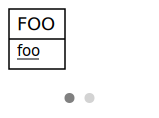

In [83]:
%%mocodo --uid_suffix 1
FOO: foo
  BAR: bar

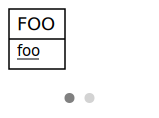

In [48]:
%%mocodo --uid_suffix 2
FOO: foo
  BAR: bar

### Créer un MCD à compléter

Les MCD à trous sont des exercices classiques d'introduction aux bases de données.

#### Supprimer le marquage d'un identifiant

Pour éviter le marquage automatique du premier attribut d'une entité comme identifiant, il suffit de le préfixer par un tiret bas (`_`) : ce caractère est donc un commutateur, qui souligne un attribut non souligné par défaut, et désouligne un attribut souligné par défaut.

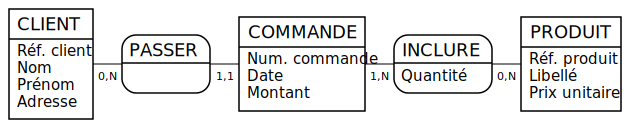

In [84]:
%%mocodo
CLIENT: _Réf. client, Nom, Prénom, Adresse
PASSER, 0N CLIENT, 11 COMMANDE
COMMANDE: _Num. commande, Date, Montant
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantité
PRODUIT: _Réf. produit, Libellé, Prix unitaire

#### Masquer un couple de cardinalités

Vous pouvez masquer n'importe quelles cardinalités en les remplaçant pas `XX` (ci-dessous à gauche) ou (nouveauté de la version 3.2) en les préfixant d'un `-` (ci-dessous à droite).

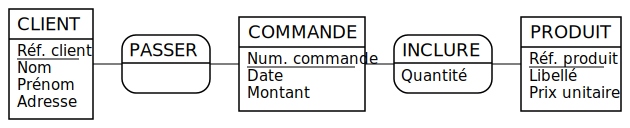

In [85]:
%%mocodo
CLIENT: Réf. client, Nom, Prénom, Adresse
PASSER, XX CLIENT, XX COMMANDE
COMMANDE: Num. commande, Date, Montant
INCLURE, -1N COMMANDE, -0N PRODUIT: Quantité
PRODUIT: Réf. produit, Libellé, Prix unitaire

**Nouveauté de la version 4.0.** Si la cardinalité comporte un et un seul `X`, l'autre caractère sera affiché tout seul.

**Nouveauté de la version 4.0.** Utilisez `-u cards:delete` pour effacer d'un coup toutes les cardinalités :

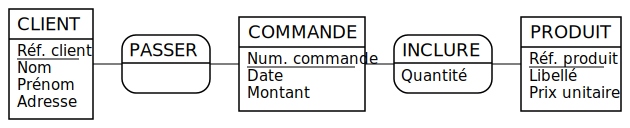

%%mocodo
CLIENT: Réf. client, Nom, Prénom, Adresse
PASSER, XX CLIENT, XX COMMANDE
COMMANDE: Num. commande, Date, Montant
INCLURE, XX COMMANDE, XX PRODUIT: Quantité
PRODUIT: Réf. produit, Libellé, Prix unitaire


In [8]:
%%mocodo -u cards:delete
CLIENT: Réf. client, Nom, Prénom, Adresse
PASSER, 0N CLIENT, 11 COMMANDE
COMMANDE: Num. commande, Date, Montant
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantité
PRODUIT: Réf. produit, Libellé, Prix unitaire

#### Masquer un attribut

Vous pouvez mettre deux virgules consécutives pour réserver la place d'un attribut manquant.

Les espaces insécables sont préservés, ce qui permet de réserver plus d'espace horizontal, cf. ci-dessous premier attribut vide de INCLURE.

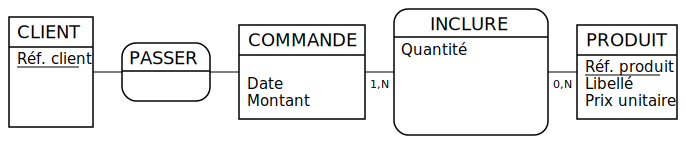

In [51]:
%%mocodo
CLIENT: Réf. client, , , 
PASSER, XX CLIENT, XX COMMANDE
COMMANDE: , Date, Montant
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantité,                    , , ,
PRODUIT: Réf. produit, Libellé, Prix unitaire

**Nouveauté de la version 4.0.** Utilisez `-r attrs:delete` pour effacer d'un coup tous les attributs :

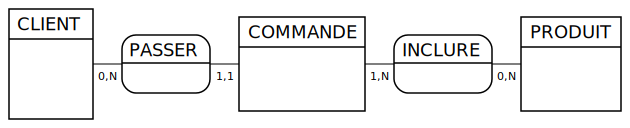

%%mocodo
CLIENT: , , , 
PASSER, 0N CLIENT, 11 COMMANDE
COMMANDE: , , 
INCLURE, 1N COMMANDE, 0N PRODUIT: 
PRODUIT: , ,


In [111]:
%%mocodo -r attrs:delete
CLIENT: Réf. client, Nom, Prénom, Adresse
PASSER, 0N CLIENT, 11 COMMANDE
COMMANDE: Num. commande, Date, Montant
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantité
PRODUIT: Réf. produit, Libellé, Prix unitaire

#### Ne faire apparaître que le squelette du schéma conceptuel

Enfin, vous pouvez transformer en exercice à trous n'importe quel MCD en rendant complètement transparentes les couleurs des attributs, associations et cardinalités. Le style `blank` a été prédéfini à cet effet:

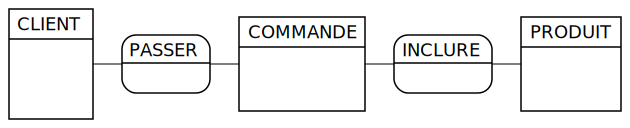

In [9]:
%%mocodo --colors=blank
CLIENT: Réf. client, Nom, Prénom, Adresse
PASSER, 0N CLIENT, 11 COMMANDE
COMMANDE: Num. commande, Date, Montant
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantité
PRODUIT: Réf. produit, Libellé, Prix unitaire

Attention, n'utilisez pas cette méthode si vous souhaitez diffuser l'exercice sous forme électronique: l'information textuelle est toujours présente, susceptible d'être sélectionnée et collée ailleurs pour être lue. Vous pouvez bien sûr empêcher cette possibilité en convertissant la figure dans un format bitmap (comme PNG); mais le plus simple est de combiner les deux méthodes précédentes:

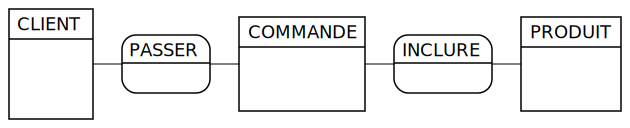

%%mocodo
CLIENT: , , , 
PASSER, XX CLIENT, XX COMMANDE
COMMANDE: , , 
INCLURE, XX COMMANDE, XX PRODUIT: 
PRODUIT: , ,


In [11]:
%%mocodo -u cards:del attrs:del
CLIENT: Réf. client, Nom, Prénom, Adresse
PASSER, 0N CLIENT, 11 COMMANDE
COMMANDE: Num. commande, Date, Montant
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantité
PRODUIT: Réf. produit, Libellé, Prix unitaire

### Créer un MCD aléatoire à partir d'un autre

#### Remplacer les libellés par du faux-texte (obfuscation)

L'obfuscation d'un MCD consiste à vider celui-ci de sa sémantique de surface, en substituant des chaînes aléatoires à tous les libellés. Le résultat sera par exemple utilisé pour montrer que les principales règles de passage du schéma conceptuel au schéma relationnel peuvent être appliquées « bêtement », c'est-à-dire sans comprendre le fonctionnement de l'organisme modélisé.

Ainsi, dans l'exemple ci-dessous, l'option `-u labels:obfuscate` remplace les libellés du MCD _CLIENT-COMMANDE-PRODUIT_ par des mots tirés au hasard:

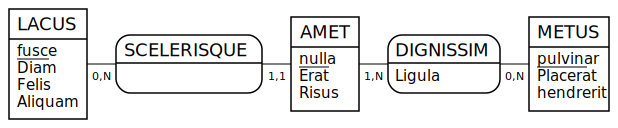

%%mocodo
LACUS: fusce, Diam, Felis, Aliquam
SCELERISQUE, 0N LACUS, 11 AMET
AMET: nulla, Erat, Risus
DIGNISSIM, 1N AMET, 0N METUS: Ligula
METUS: pulvinar, Placerat, hendrerit


In [112]:
%%mocodo -r labels:obfuscate --seed=1
CLIENT: Réf. client, Nom, Prénom, Adresse
PASSER, 0N CLIENT, 11 COMMANDE
COMMANDE: Num. commande, Date, Montant
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantité
PRODUIT: Réf. produit, Libellé, Prix unitaire

En argument, vous pouvez ajouter le chemin d'un fichier texte UTF-8 quelconque où puiser les mots de substitution. Par exemple, le texte du `README` de ce projet:

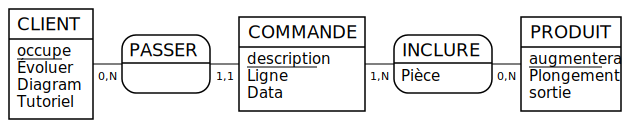

%%mocodo
CLIENT: occupe, Évoluer, Diagram, Tutoriel
PASSER, 0N CLIENT, 11 COMMANDE
COMMANDE: description, Ligne, Data
INCLURE, 1N COMMANDE, 0N PRODUIT: Pièce
PRODUIT: augmentera, Plongement, sortie


In [113]:
%%mocodo -r attrs:obfuscate=../README.md --seed=42
CLIENT: Réf. client, Nom, Prénom, Adresse
PASSER, 0N CLIENT, 11 COMMANDE
COMMANDE: Num. commande, Date, Montant
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantité
PRODUIT: Réf. produit, Libellé, Prix unitaire

Mocodo essaie d'abord de trouver ce fichier à l'endroit indiqué. En cas d'échec, il le cherche (avec extension `.txt` facultative) parmi les textes distribués avec le logiciel, à savoir:

- `"lorem_ipsum.txt"`: le [faux-texte](https://fr.wikipedia.org/wiki/Faux-texte) le plus courant.
- `"disparition.txt"`: le lexique du [célèbre roman lipogrammatique](https://fr.wikipedia.org/wiki/La_Disparition_&#40;roman&#41;) de Georges Perec.
- `"four_letter_words.txt"`: une sélection (SFW) de mots anglais de quatre lettres.

En cas de nouvel échec, il se rabat sur `"lorem_ipsum.txt"`.

Notez enfin que l'algorithme s'assure que la [distance de Damerau-Levenshtein](https://fr.wikipedia.org/wiki/Distance_de_Damerau-Levenshtein) entre deux libellés de substitution quelconques est d'au moins 3 (valeur par défaut du paramètre `obfuscation_min_distance`). En clair, cela signifie que, si vous donnez en examen un exercice de conversion en relationnel basé sur un tel MCD, les erreurs de transcription d'un étudiant stressé, inattentif, illettré, dyslexique, roublard, ou tout cela à la fois, ne devraient pas vous empêcher de lui octroyer les points qu'il mérite.

**Nouveautés de la version 3.**
- L'option `--obfuscation_max_length` est supprimée ; inversement, la taille minimale d'un mot de substitution est fixée (en dur) à 3.
- L'option `--seed` fonctionne quelle que soit la version de Python.

**Nouveauté de la version 4.0.**
L'obfuscation est placée sous le chapeau de diverses autres opérations de modification. Ce qui s'écrivait :

```
mocodo --obfuscate=four_letter_words
```

s'écrit maintenant (plus lourdement, il faut en convenir) :

```
mocodo -r labels:obfuscate=four_letter_words
```

#### Randomiser les cardinalités

**Nouveauté de la version 4.0.** On peut aller plus loin dans l'obfuscation en rempaçant toutes les cardinalités par d'autres tirées au hasard (`-r cards:randomize`).

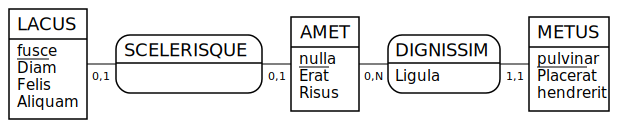

%%mocodo
LACUS: fusce, Diam, Felis, Aliquam
SCELERISQUE, 01 LACUS, 01 AMET
AMET: nulla, Erat, Risus
DIGNISSIM, 0N AMET, 11 METUS: Ligula
METUS: pulvinar, Placerat, hendrerit


In [114]:
%%mocodo -r cards:randomize --seed=42
LACUS: fusce, Diam, Felis, Aliquam
SCELERISQUE, 0N LACUS, 11 AMET
AMET: nulla, Erat, Risus
DIGNISSIM, 1N AMET, 0N METUS: Ligula
METUS: pulvinar, Placerat, hendrerit

Le MCD résultant satisfait aux propriétés suivantes :

1. Il comporte approximativement la même proportion de cardinalités `_11` (dénotant une entité faible) que le MCD original, ou aucune si ce dernier n'en comportait pas.
2. Idem pour les cardinalités `/1N` ou `/0N` (dénotant une agrégation).
3. Toute association comporte au plus une cardinalité `11`.
4. Toute association notée DF comporte exactement une cardinalité `11`.

**Limitation.** Si le MCD original comportait au moins une entité faible, la randomisation des cardinalités peut résulter en un MCD invalide (l'absence de cycles d'entités faibles n'est pas garantie).

### Créer un MCD n'employant que des DF élémentaires

**Nouveauté de la version 4.0.** Aussi surprenant que cela puisse paraître, tout MCD peut être transformé en un MCD équivalent dont les seules associations sont des dépendances fonctionnelles binaires non porteuses d'attributs, telles que celle ci-dessous :

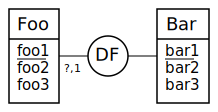

In [104]:
%%mocodo
Foo: foo1, foo2, foo3
DF, ?1 Foo, XX Bar
Bar: bar1, bar2, bar3

La transformation nécessite trois opérations de modification élémentaires que Mocodo appelle _drain_, _split_ et _explode_, et que nous allons découvrir dans les sous-sections suivantes.

#### Vider les DF de leurs attributs

Mettre des attributs dans les associations 11 est souvent considéré comme une anomalie.

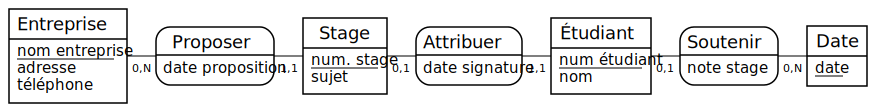

**Entreprise** (<ins>nom entreprise</ins>, adresse, téléphone)<br>
**Stage** (<ins>num. stage</ins>, sujet, _#nom entreprise_, date proposition)<br>
**Étudiant** (<ins>num étudiant</ins>, nom, _#num. stage_, date signature, date, note stage)


In [116]:
%%mocodo --mld
Entreprise: nom entreprise, adresse, téléphone
Proposer, 0N Entreprise, 11 Stage: date proposition
Stage: num. stage, sujet
Attribuer, 11 Étudiant, 01 Stage: date signature
Étudiant: num étudiant, nom
Soutenir, 01 Étudiant, 0N Date: note stage
Date: date

Mocodo peut les déplacer dans les entités distinguées par les cardinalités 11. Nous appelons cette opération de modification un « drainage de dépendances fonctionnelles » (option `-r drain`). Notez bien que ces deux MCD sont strictement équivalents, et produisent le même MLD.

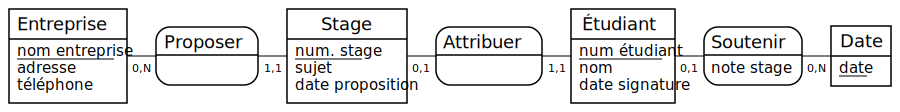

**Entreprise** (<ins>nom entreprise</ins>, adresse, téléphone)<br>
**Stage** (<ins>num. stage</ins>, sujet, date proposition, _#nom entreprise_)<br>
**Étudiant** (<ins>num étudiant</ins>, nom, date signature, _#num. stage_, date, note stage)


%%mocodo
Entreprise: nom entreprise, adresse, téléphone
Proposer, 0N Entreprise, 11 Stage
Stage: num. stage, sujet, date proposition
Attribuer, 11 Étudiant, 01 Stage
Étudiant: num étudiant, nom, date signature
Soutenir, 01 Étudiant, 0N Date: note stage
Date: date


In [117]:
%%mocodo --mld -r drain
Entreprise: nom entreprise, adresse, téléphone
Proposer, 0N Entreprise, 11 Stage: date proposition
Stage: num. stage, sujet
Attribuer, 11 Étudiant, 01 Stage: date signature
Étudiant: num étudiant, nom
Soutenir, 01 Étudiant, 0N Date: note stage
Date: date

La première version peut être préférée pour des raisons de localité sémantique (_date proposition_ dans PROPOSER), ou honnie parce qu'elle complique la définition d'identifiant d'association. Mocodo n'a pas d'opinion sur la question. Par contre, il se refuse à procéder au drainage _via_ les cardinalités 01. Dans le MCD ci-dessus, le placement de _note stage_ dans SOUTENIR indique qu'un étudiant peut ne pas se voir attribuer de note de stage ; si elle était mise dans ÉTUDIANT, la connaissance du fait que ce champ autorise la valeur `NULL` serait perdue.

TODO: implanter le champ nullable en SQL.

#### Décomposer les DF n-aires

De même, d'aucuns regardent de travers les dépendances fonctionnelles d'arité $n$ supérieure à 2 :

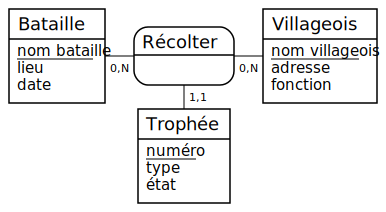

**Bataille** (<ins>nom bataille</ins>, lieu, date)<br>
**Trophée** (<ins>numéro</ins>, type, état, _#nom villageois_, _#nom bataille_)<br>
**Villageois** (<ins>nom villageois</ins>, adresse, fonction)


In [119]:
%%mocodo --mld
Bataille: nom bataille, lieu, date
Récolter, 0N Villageois, 0N Bataille, 11 Trophée
Villageois: nom villageois, adresse, fonction

Trophée: numéro, type, état

Toute DF de ce type peut être « fendue » en $n-1$ DF. L'option `-m split` génère un MCD équivalent :

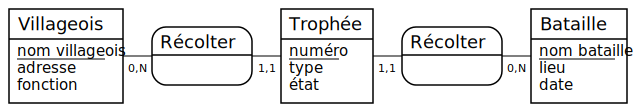

**Bataille** (<ins>nom bataille</ins>, lieu, date)<br>
**Trophée** (<ins>numéro</ins>, type, état, _#nom villageois_, _#nom bataille_)<br>
**Villageois** (<ins>nom villageois</ins>, adresse, fonction)


In [122]:
%%mocodo --mld -r split quiet arrange:grid=10x1 --seed=9
Bataille: nom bataille, lieu, date
Récolter, 0N Villageois, 0N Bataille, 11 Trophée
Villageois: nom villageois, adresse, fonction

Trophée: numéro, type, état

#### Décomposer les associations n-aires non DF

Toute association non DF d'arité $n$ peut être décomposée en un ensemble de $n$ associations DF : elle-même se voit alors remplacée par une entité liée aux $n$ entités originales. Cette nouvelle entité est appelée « entité-intersection », « entité-associative » ou « Gerund » (Song, Il-Yeol & Evans, Mary & Park, Eui Kyun. _A Comparative Analysis of Entity-Relationship Diagrams_. Journal of Computer and Software Engineering. 3 (1995)). Dans les cours de [Laurent Audibert](https://laurent-audibert.developpez.com/Cours-BD/?page=conception-des-bases-de-donnees-modele-a#L2-3-3-b) ou de [Patrick Bergougnoux](https://gestion.pumbo.fr/boutique/livre/modelisation-conceptuelle-de-donnees), l'opération est illustrée à l'aide du MCD suivant :

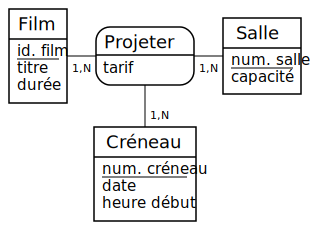

**Créneau** (<ins>num. créneau</ins>, date, heure début)<br>
**Film** (<ins>id. film</ins>, titre, durée)<br>
**Projeter** (<ins>_#num. salle_</ins>, <ins>_#num. créneau_</ins>, <ins>_#id. film_</ins>, tarif)<br>
**Salle** (<ins>num. salle</ins>, capacité)


In [123]:
%%mocodo --mld
Film: id. film, titre, durée
Projeter, 1N Salle, 1N Créneau, 1N Film: tarif
Salle: num. salle, capacité

Créneau: num. créneau, date, heure début

La décomposition est invoquée par l'option `-r explode` :

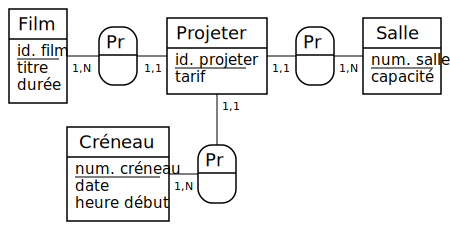

**Créneau** (<ins>num. créneau</ins>, date, heure début)<br>
**Film** (<ins>id. film</ins>, titre, durée)<br>
**Projeter** (<ins>id. projeter</ins>, tarif, _#id. film_, _#num. salle_, _#num. créneau_)<br>
**Salle** (<ins>num. salle</ins>, capacité)


%%mocodo
Film: id. film, titre, durée
Pr3, 11 Projeter, 1N Film
Projeter: id. projeter, tarif
Pr1, 11 Projeter, 1N Salle
Salle: num. salle, capacité

:
Créneau: num. créneau, date, heure début
Pr2, 11 Projeter, 1N Créneau
:
:


In [148]:
%mocodo --input sandbox --mld -r explode arrange:grid=5x2 --seed=21

En fait, le nouveau MCD a vocation à être retouché pour se rapprocher du plongement initial et avoir des noms plus appropriés aux nouveaux identifiant, entité et associations créés, par exemple :

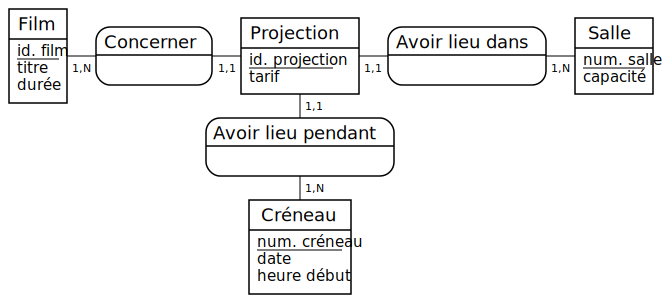

**Créneau** (<ins>num. créneau</ins>, date, heure début)<br>
**Film** (<ins>id. film</ins>, titre, durée)<br>
**Projection** (<ins>id. projection</ins>, tarif, _#id. film_, _#num. salle_, _#num. créneau_)<br>
**Salle** (<ins>num. salle</ins>, capacité)


In [150]:
%%mocodo --mld
Film: id. film, titre, durée
Concerner, 11 Projection, 1N Film
Projection: id. projection, tarif
Avoir lieu dans, 11 Projection, 1N Salle
Salle: num. salle, capacité

Avoir lieu pendant, 11 Projection, 1N Créneau

Créneau: num. créneau, date, heure début

#### Décomposer les associations binaires non DF

Considérons le MCD suivant, qui comporte deux associations binaires non DF, l'une porteuse d'attribut, l'autre non :

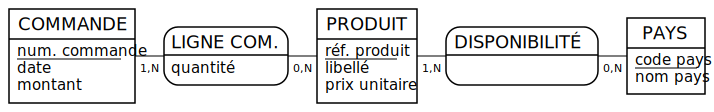

**COMMANDE** (<ins>num. commande</ins>, date, montant)<br>
**DISPONIBILITÉ** (<ins>_#réf. produit_</ins>, <ins>_#code pays_</ins>)<br>
**LIGNE COM.** (<ins>_#num. commande_</ins>, <ins>_#réf. produit_</ins>, quantité)<br>
**PAYS** (<ins>code pays</ins>, nom pays)<br>
**PRODUIT** (<ins>réf. produit</ins>, libellé, prix unitaire)


In [158]:
%%mocodo --mld
COMMANDE: num. commande, date, montant
LIGNE COM., 1N COMMANDE, 0N PRODUIT: quantité
PRODUIT: réf. produit, libellé, prix unitaire
DISPONIBILITÉ, 1N PRODUIT, 0N PAYS
PAYS: code pays, nom pays

Par souci de concision, quand on parle d'associations $n$-aires dans ce document, c'est par opposition aux associations binaires ; mais bien sûr, la règle de décomposition énoncée à la section précédente est également valable pour $n=2$, même si par défaut elle ne s'applique qu'aux associations d'arité minimale 3. En réduisant la valeur de `arity` à 2, toutes les associations binaires non DF seront également décomposées :

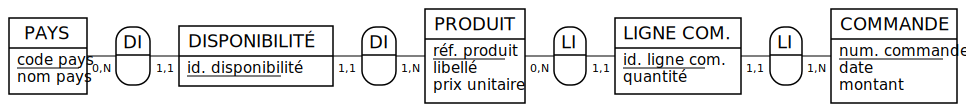

**COMMANDE** (<ins>num. commande</ins>, date, montant)<br>
**DISPONIBILITÉ** (<ins>id. disponibilité</ins>, _#code pays_, _#réf. produit_)<br>
**LIGNE COM.** (<ins>id. ligne com.</ins>, quantité, _#réf. produit_, _#num. commande_)<br>
**PAYS** (<ins>code pays</ins>, nom pays)<br>
**PRODUIT** (<ins>réf. produit</ins>, libellé, prix unitaire)


In [159]:
%mocodo --mld --input=mocodo_notebook/sandbox.mcd -r explode:arity=2 quiet arrange:grid=10x1 --seed=1

Cette décomposition devient un peu extrême ! Vous pouvez conserver certaines associations binaires non DF, à savoir celles qui ne portent aucun attribut, en mettant `arity` à `2.5` (à lire comme « intermédiaire entre `2` et `3` ») :

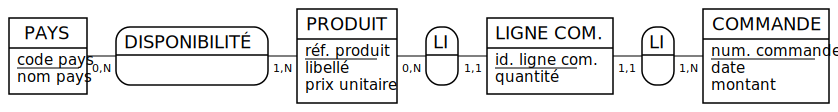

**COMMANDE** (<ins>num. commande</ins>, date, montant)<br>
**DISPONIBILITÉ** (<ins>_#réf. produit_</ins>, <ins>_#code pays_</ins>)<br>
**LIGNE COM.** (<ins>id. ligne com.</ins>, quantité, _#réf. produit_, _#num. commande_)<br>
**PAYS** (<ins>code pays</ins>, nom pays)<br>
**PRODUIT** (<ins>réf. produit</ins>, libellé, prix unitaire)


In [161]:
%mocodo --mld --input=mocodo_notebook/sandbox.mcd -r explode:arity=2.5 quiet arrange:grid=10x1 --seed=1

#### Décomposer en créant des entités faibles

Ci-dessus, le processus de modification a créé un identifiant _id. ligne com._ qui peut sembler superfétatoire. Si l'on a introduit la notion d'entité faible, on aura ici avantage à utiliser l'option `weak` :

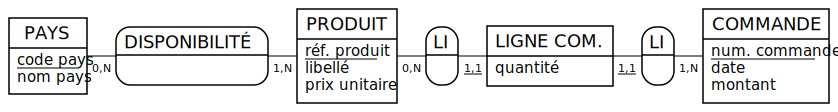

**COMMANDE** (<ins>num. commande</ins>, date, montant)<br>
**DISPONIBILITÉ** (<ins>_#réf. produit_</ins>, <ins>_#code pays_</ins>)<br>
**LIGNE COM.** (<ins>_#num. commande_</ins>, <ins>_#réf. produit_</ins>, quantité)<br>
**PAYS** (<ins>code pays</ins>, nom pays)<br>
**PRODUIT** (<ins>réf. produit</ins>, libellé, prix unitaire)


In [162]:
%mocodo --mld --input=mocodo_notebook/sandbox.mcd -r explode:arity=2.5,weak quiet arrange:grid=10x1 --seed=1

**Cas des pseudo-entités.** Comme on l'a vu plus haut, la notion d'entité faible permet de se passer de celle d'agrégation (TODO: c'est faux). Ainsi, le MCD ci-dessous :

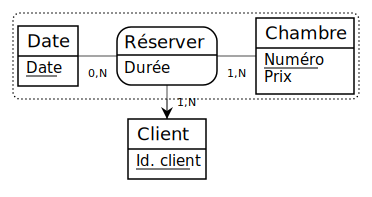

**Chambre** (<ins>Numéro</ins>, Prix)<br>
**Réserver** (<ins>_#Numéro_</ins>, <ins>Date</ins>, Id. client, Durée)


In [164]:
%%mocodo --mld
Date: Date
Réserver, /1N Client, 1N Chambre, 0N Date: Durée
Chambre: Numéro, Prix

Client: Id. client

... se verra décomposé de la même façon que sans agrégation, à ceci près que la patte distinguée par le `"/"` produira une cardinalité `11` au lieu d'une cardinalité `_11` :

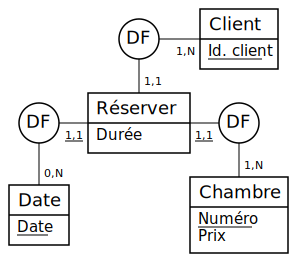

**Chambre** (<ins>Numéro</ins>, Prix)<br>
**Réserver** (<ins>_#Numéro_</ins>, <ins>Date</ins>, Durée, Id. client)


In [419]:
%%mocodo -r explode:weak quiet arrange --seed 11 --mld
Date: Date
Réserver, /1N Client, 1N Chambre, 0N Date: Durée
Chambre: Numéro, Prix

Client: Id. client

#### Simplifier le résultat de la décomposition

Cette décomposition pourra quelquefois être améliorée manuellement. Reprenons l'exemple non modifié des réservations de chambre :

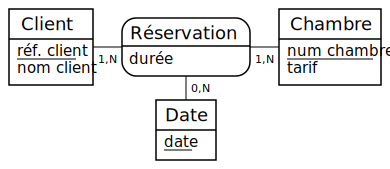

In [193]:
%%mocodo
Client: réf. client, nom client
Réservation, 1N Client, 1N Chambre, 0N Date: durée
Chambre: num chambre, tarif

Date: date

La décomposition automatique produit :

In [194]:
%mocodo --input sandbox --mld -r explode arrange:grid=10x2 flip:h,v quiet --seed 10

Traceback (most recent call last):
  File "/Users/aristide/opt/anaconda3/bin/mocodo", line 8, in <module>
    sys.exit(main())
  File "/Users/aristide/Dropbox/Sites/mocodo/mocodo/__main__.py", line 272, in main
    run = Runner()
  File "/Users/aristide/Dropbox/Sites/mocodo/mocodo/__main__.py", line 40, in __init__
    self.params = parsed_arguments()
  File "/Users/aristide/Dropbox/Sites/mocodo/mocodo/argument_parser.py", line 208, in parsed_arguments
    raise MocodoError(2, _('The file "{input}" doesn\'t exist.').format(input=args.input))  # fmt: skip
mocodo.mocodo_error.MocodoError: Mocodo Err.2 - Le fichier « sandbox.mcd » n'existe pas.


En anticipant sur le passage au relationnel, on remarque que l'entité DATE est [indépendante et réduite à sa clé primaire](#Suppression-des-tables-indépendantes-réduites-à-leur-clé-primaire) : on peut donc la supprimer, après avoir pris soin de déplacer dans RÉSERVATION son unique attribut.

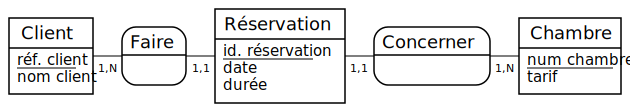

In [158]:
%%mocodo
Client: réf. client, nom client
Faire, 11 Réservation, 1N Client
Réservation: id. réservation, date, durée
Concerner, 11 Réservation, 1N Chambre
Chambre: num chambre, tarif

Cette simplification s'applique également à la variante avec création d'entités faibles :

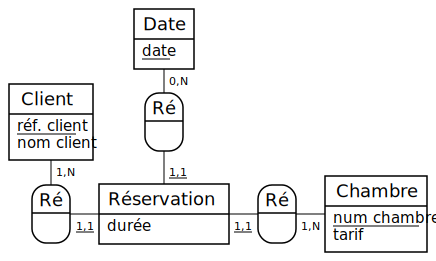

In [189]:
%%mocodo -r explode:weak quiet arrange --seed 19
Client: réf. client, nom client
Réservation, 1N Client, 1N Chambre, 0N Date: durée
Chambre: num chambre, tarif

Date: date

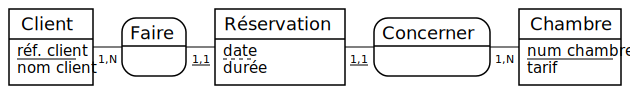

**Chambre** (<ins>num chambre</ins>, tarif)<br>
**Client** (<ins>réf. client</ins>, nom client)<br>
**Réservation** (<ins>_#num chambre_</ins>, <ins>_#réf. client_</ins>, <ins>date</ins>, durée)


In [190]:
%%mocodo --mld
Client: réf. client, nom client
Faire, _11 Réservation, 1N Client
Réservation: date, durée
Concerner, _11 Réservation, 1N Chambre
Chambre: num chambre, tarif

#### Conclusion sur ces décompositions

Comme l'indique le nom que nous leur avons malicieusement attribué, certaines de ces décompositions peuvent littéralement faire _exploser_ la taille du MCD. Cependant :

- elles sont intéressantes d'un point de vue <s>terroriste</s> théorique ;
- elles peuvent permettre la détection d'erreurs de conception ;
- elles peuvent conduire à des améliorations fines du MCD (c'est ce qu'on vient de faire sur celui des réservations de chambre) ;
- elles décrivent le MCD dans un langage volontairement appauvri, ce qui le rendra plus aisément portable dans une autre notation, comme UML ou _crow's foot_.

### Créer une vue en extension

La [technique de duplication](#Cr%C3%A9ation-de-plusieurs-entit%C3%A9s-ou-associations-de-m%C3%AAme-nom) vue plus haut peut servir à produire une vue en extension d'un MCD. Voici par exemple le MCD que j'utilise en cours pour introduire la notion d'entité faible (à gauche, vue en compréhension, à droite vue en extension):

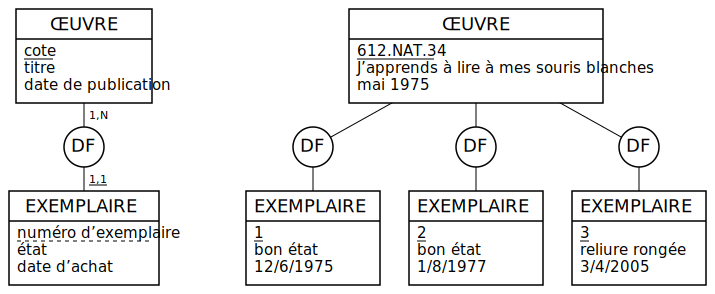

In [434]:
%%mocodo
ŒUVRE1: cote, titre, date de publication
:::
ŒUVRE2: 612.NAT.34, J'apprends à lire à mes souris blanches, mai 1975
:
  
DF, 1N ŒUVRE1, _11 EXEMPLAIRE1
::
DF, XX ŒUVRE2, XX EXEMPLAIRE2
DF, XX ŒUVRE2, XX EXEMPLAIRE3
DF, XX ŒUVRE2, XX EXEMPLAIRE4

EXEMPLAIRE1: numéro d'exemplaire, état, date d'achat
::
EXEMPLAIRE2: 1, bon état, 12/6/1975
EXEMPLAIRE3: 2, bon état, 1/8/1977
EXEMPLAIRE4: 3, reliure rongée, 3/4/2005

Mocodo n'interdit pas la conversion en relationnel d'un tel MCD, mais celle-ci n'a aucun sens.

**Nouveauté de la version 3.2.** Pour préserver la sémantique des cardinalités sans les afficher, il est maintenant possible de les préfixer d'un `-` (« moins »). Le résultat de la conversion en relationnel peut alors être interprété comme l'ensemble des lignes des différentes tables.

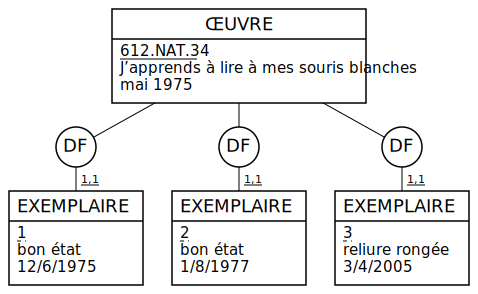

**EXEMPLAIRE1** (<ins>_#612.NAT.34_</ins>, <ins>1</ins>, bon état, 12/6/1975)<br>
**EXEMPLAIRE2** (<ins>_#612.NAT.34_</ins>, <ins>2</ins>, bon état, 1/8/1977)<br>
**EXEMPLAIRE3** (<ins>_#612.NAT.34_</ins>, <ins>3</ins>, reliure rongée, 3/4/2005)<br>
**ŒUVRE** (<ins>612.NAT.34</ins>, J'apprends à lire à mes souris blanches, mai 1975)


In [433]:
%%mocodo --mld
ŒUVRE: 612.NAT.34, J'apprends à lire à mes souris blanches, mai 1975
  
DF, -1N ŒUVRE, -_11 EXEMPLAIRE1
DF, -1N ŒUVRE, -_11 EXEMPLAIRE2
DF, -1N ŒUVRE, -_11 EXEMPLAIRE3

EXEMPLAIRE1: 1, bon état, 12/6/1975
EXEMPLAIRE2: 2, bon état, 1/8/1977
EXEMPLAIRE3: 3, reliure rongée, 3/4/2005

# Tracé d'un MCD

## Interdiction des chevauchements

Les débutants ne comprennent pas toujours du premier coup que l'ordre des lignes du texte-source correspond à celui des boîtes du MCD affiché ; ou qu'il faut sauter une ligne chaque fois que l'on veut une nouvelle rangée de boîtes. Ces malheureux se retrouvent donc plus souvent qu'à leur tour avec des chevauchements pas forcément faciles à voir :

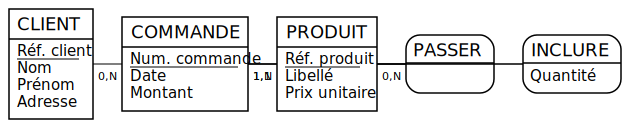

In [27]:
%%mocodo
CLIENT: Réf. client, Nom, Prénom, Adresse
COMMANDE: Num. commande, Date, Montant
PRODUIT: Réf. produit, Libellé, Prix unitaire
PASSER, 0N CLIENT, 11 COMMANDE
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantité

Ci-dessus, par exemple, l'association INCLURE, qui devrait se trouver entre CLIENT et COMMANDE, est déportée de telle sorte que ses pattes chevauchent COMMANDE, PRODUIT et PASSER, — ce qui ne se voit pas vraiment puisque les entités et associations sont tracées **après** les pattes.

**Nouveauté de la version 3.0.** Mocodo peut lever une erreur dans une telle situation. L'option correspondante, `--detect_overlaps` est par défaut activée sous Mocodo online, et désactivée en ligne de commande.

Si vous rencontrez une telle erreur, vous pouvez :
    
- Modifier manuellement l'ordre des lignes du texte-source et/ou insérer des sauts de ligne.
- [Réarranger automatiquement](#Réarrangement-automatique) le MCD (en cliquant 🔀 sous Mocodo online, ou avec l'option `-m arrange` en ligne de commande).
- Ignorer le problème en désactivant la détection des chevauchements (sous l'onglet « Options » de Mocodo online).

**Remarques.**

- Les calculs sont opérés, non pas à partir des coordonnées réelles des boîtes, mais de leurs indices $(i, j)$ dans la matrice correspondant à la grille qui sert de base au plongement. Les éventuelles [retouches](#Retouches-fines) apportées à la position de leurs centres sont ignorées.
- Seuls les chevauchements mettant en jeu des pattes horizontales ou verticales sont détectés. Par exemple, ci-dessous, le chevauchement sera ignoré.

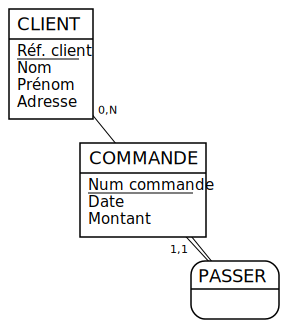

In [59]:
%%mocodo
CLIENT: Réf. client, Nom, Prénom, Adresse
::

:
COMMANDE: Num. commande, Date, Montant
:

::
PASSER, 0N CLIENT, 11 COMMANDE

## Insertion manuelle d'espacements

Le tracé réalisé par Mocodo pour des MCD de plusieurs rangées laisse parfois à désirer :

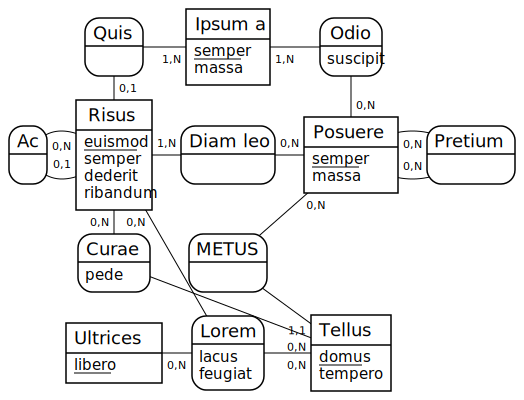

In [28]:
%%mocodo
Quis, 01 Risus, 1N Ipsum a
Ipsum a: semper, massa
Odio, 1N Ipsum a, 0N Posuere: suscipit

Ac, 01 Risus, 0N Risus
Risus: euismod, semper, dederit, ribandum
Diam leo, 1N Risus, 0N Posuere
Posuere: semper, massa
Pretium, 0N Posuere, 0N Posuere

Curae, 0N Risus, 0N Tellus: pede
METUS, 11 Tellus, 0N Posuere

Ultrices: libero
Lorem, 0N Ultrices, 0N Tellus, 0N Risus: lacus, feugiat
Tellus: domus, tempero

On voit que, par défaut, Mocodo centre les rangées qui contiennent moins de boîtes que les autres. Cela donne un bon résultat pour la première rangée, mais pas pour la troisième.

L'utilisateur peut cependant spécifier les espacements qu'il désire en complétant les rangées par des boîtes invisibles dont le seul rôle est de « pousser » les autres à l'emplacement voulu. Ainsi, il va préciser que l'association _Curae_ doit commencer sur la troisième colonne en insérant des lignes réduites au caractère deux-points, et en profiter pour insérer un espace entre _Lorem_ et _Tellus_ :

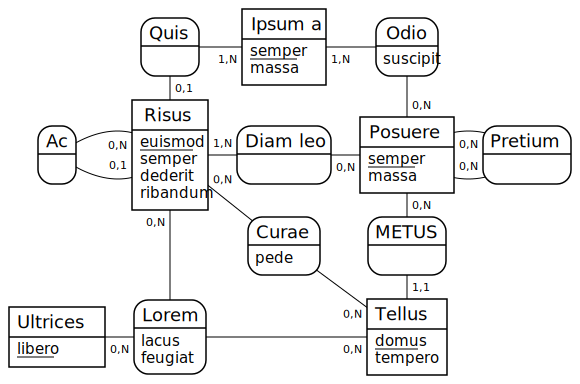

In [29]:
%%mocodo
Quis, 01 Risus, 1N Ipsum a
Ipsum a: semper, massa
Odio, 1N Ipsum a, 0N Posuere: suscipit

Ac, 01 Risus, 0N Risus
Risus: euismod, semper, dederit, ribandum
Diam leo, 1N Risus, 0N Posuere
Posuere: semper, massa
Pretium, 0N Posuere, 0N Posuere

:
:
Curae, 0N Risus, 0N Tellus: pede
METUS, 11 Tellus, 0N Posuere
:

Ultrices: libero
Lorem, 0N Ultrices, 0N Tellus, 0N Risus: lacus, feugiat
:
Tellus: domus, tempero

NB. Il est possible de « compresser » les suites de deux-points en supprimant les retours-chariots, autrement dit, de remplacer $n$ lignes réduites à deux-points par une ligne réduite à une séquence de $n$ deux-points.

## Basculement des cardinalités et inflexion des pattes rectilignes

**Nouveauté de la version 2.1.** Mocodo est capable de détecter certaines configurations de pattes dont les cardinalités présentent un risque élevé de collision. Il procède alors à deux types d'ajustements:

1. [Issue 25](https://github.com/laowantong/mocodo/issues/25). Les cardinalités d'une patte verticale ou horizontale sont envoyées de l'autre côté de la patte. Par exemple, dans le plongement du MCD précédent, la présence de la patte oblique _BLANDIT-VIVAMUS_ envoie les cardinalités de _VELIT-BLANDIT_ à l'opposé de leur position par défaut (à droite d'une patte verticale ou en bas d'une patte horizontale).
2. [Issue 27](https://github.com/laowantong/mocodo/issues/27). Les pattes obliques sont infléchies de façon à ménager plus d'espace pour afficher deux couples de cardinalités. Ici, l'inflexion de la patte _DF-CONGUE_ permet à ses cardinalités de coexister sans problème avec celles de l'association réflexive.

Ces ajustements automatiques résolvent les problèmes les plus courants. Toutefois, étant antérieurs au tracé proprement dit, ils peuvent seulement réduire les risques de collision, et non les prévenir totalement. Ils peuvent même en produire d'autres. Ainsi, autour des entités particulièrement pattues, des collisions qui ne se seraient pas produites par défaut seront parfois observées. L'utilisateur a alors deux possibilités:

- modifier à la main les coordonnées des cardinalités en conflit, comme expliqué dans la section suivante;
- diminuer la valeur du paramètre `--flex` (par défaut, `0.75`) pour réduire la courbure de l'inflexion automatique, en allant jusqu'à `0` pour la désactiver totalement ([exemple](#Sym%C3%A9tries-selon-les-diagonales-(transposition))).

## Retouches fines

### Par modification du fichier  de géométrie

Lors du plongement, Mocodo génère systématiquement un fichier (intitulé par défaut `sandbox_geo.json`) répertoriant les positions les plus importantes du dessin. La plupart des autres coordonnées sont calculées relativement à celles-ci.

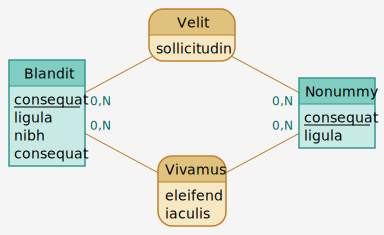

In [66]:
%%mocodo --shapes trebuchet --colors=brewer+1
Velit, 0N Blandit, 0N Nonummy: sollicitudin

Blandit: consequat, ligula, nibh, consequat
:::
Nonummy: consequat, ligula
  
Vivamus, 0N Nonummy, 0N Blandit: eleifend, iaculis

Si on ouvre le fichier de géométrie généré, on y retrouvera les principaux paramètres de position:

In [67]:
display.Code("mocodo_notebook/sandbox_geo.json")

{
  "width": 384,
  "height": 235,
  "cx": [
    [ "Velit", 192 ],
    [ "Blandit", 47 ],
    [ "Nonummy", 337 ],
    [ "Vivamus", 192 ]
  ],
  "cy": [
    [ "Velit", 35 ],
    [ "Blandit", 113 ],
    [ "Nonummy", 113 ],
    [ "Vivamus", 191 ]
  ],
  "shift": [
    [ "Velit,Blandit,0", 0 ],
    [ "Velit,Nonummy,0", 0 ],
    [ "Vivamus,Nonummy,0", 0 ],
    [ "Vivamus,Blandit,0", 0 ]
  ],
  "ratio": []
}

- Un couple de dimensions `width` et `height` définit la taille du MCD ;
- deux listes de couples `cx` et `cy`, les abscisses et ordonnées des centres des boîtes ;
- un dictionnaire `shift`, les positions relatives des cardinalités par rapport à leur position par défaut ;
- une liste `ratio`, les positions des flèches éventuelles.

Pour rendre le plongement plus compact, nous apportons à ce fichier quelques modifications :

In [68]:
%%file mocodo_notebook/sandbox_geo.json
{
  "width": 384,
  "height": 155,
  "cx": [
    [ "Velit", 192 ],
    [ "Blandit", 47 ],
    [ "Nonummy", 337 ],
    [ "Vivamus", 192 ]
  ],
  "cy": [
    [ "Velit", 35 ],
    [ "Blandit", 73 ],
    [ "Nonummy", 73 ],
    [ "Vivamus", 111 ]
  ],
  "shift": [
    [ "Velit,Blandit,0", -30 ],
    [ "Velit,Nonummy,0", -30 ],
    [ "Vivamus,Nonummy,0", -30 ],
    [ "Vivamus,Blandit,0", -30 ]
  ],
  "ratio": []
}

Overwriting mocodo_notebook/sandbox_geo.json


Il suffit maintenant d'ajouter l'option `--reuse_geo` pour appliquer ces modifications :

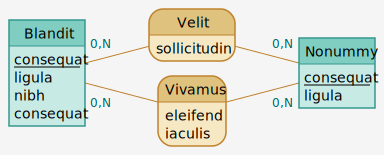

In [69]:
%%mocodo --shapes trebuchet --colors=brewer+1 --reuse_geo
Velit, 0N Blandit, 0N Nonummy: sollicitudin

Blandit: consequat, ligula, nibh, consequat
:::
Nonummy: consequat, ligula
  
Vivamus, 0N Nonummy, 0N Blandit: eleifend, iaculis

### Par édition de la sortie au format SVG

Tous les navigateurs modernes prennent en charge la visualisation des SVG. Pour aller au-delà, il faudra faire appel à un logiciel de dessin vectoriel dédié, comme [Inkscape](https://www.inkscape.org/?lang=fr) (libre) ou Adobe Illustrator, Freehand, CorelDRAW, etc.
Les éléments du fichier SVG produit pourront alors être repositionnés à la souris. Certains sont groupés pour permettre leur déplacement en bloc. Dans la version actuelle, les liens ne suivent pas ces déplacements, ce qui peut obliger à des manipulations supplémentaires.

## Mise en miroir d'un MCD

### Axes de symétrie

Mocodo permet de calculer facilement les symétriques d'un MCD. À partir de la version 4.0, ces opérations sont des arguments de l'option `-r` :

- selon l'axe vertical : `-m flip_v` ;
- selon l'axe horizontal : `-m flip_h` ;
- selon la première diagonale (transposition) : `-m flip_d`.

**Astuce.** Pour une symétrie selon la seconde diagonale, il suffit de séquencer ces trois opérations dans un ordre quelconque :
- selon la seconde diagonale : `-m flip_v flip_h flip_d`.

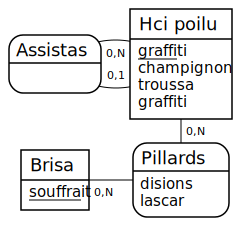

In [11]:
%%mocodo
Assistas, 01 Hci poilu, 0N Hci poilu
Hci poilu: graffiti, champignon, troussa, graffiti

Brisa: souffrait
Pillards, 0N Brisa, 0N Hci poilu: disions, lascar

%%mocodo
Pillards, 0N Brisa, 0N Hci poilu: disions, lascar
Hci poilu: graffiti, champignon, troussa, graffiti

Brisa: souffrait
Assistas, 01 Hci poilu, 0N Hci poilu


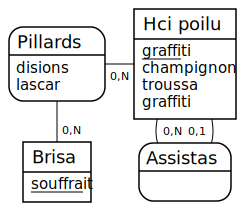

In [12]:
%%mocodo -m flip_v flip_h flip_d
Assistas, 01 Hci poilu, 0N Hci poilu
Hci poilu: graffiti, champignon, troussa, graffiti

Brisa: souffrait
Pillards, 0N Brisa, 0N Hci poilu: disions, lascar

### Astuce: édition rapide d'une ou plusieurs colonnes

La transposition peut être utilisée pour réaliser plus facilement certaines opérations d'édition en colonne, en particulier sous [Mocodo online](http://mocodo.net). Par exemple, supposons que l'on souhaite décaler vers le haut la dernière colonne du MCD ci-dessous:

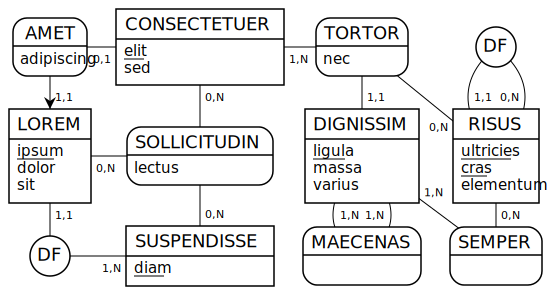

In [432]:
%%mocodo --flex=0
AMET, 11> LOREM, 01 CONSECTETUER: adipiscing
CONSECTETUER: elit, sed
TORTOR, 0N RISUS, 11 DIGNISSIM, 1N CONSECTETUER: nec
DF, 11 RISUS, 0N RISUS

LOREM: ipsum, dolor, sit
SOLLICITUDIN, 0N SUSPENDISSE, 0N CONSECTETUER, 0N LOREM: lectus
DIGNISSIM: ligula, massa, varius
RISUS: ultricies, _cras, elementum

DF, 11 LOREM, 1N SUSPENDISSE
SUSPENDISSE: diam
MAECENAS, 1N DIGNISSIM, 1N DIGNISSIM
SEMPER, 0N RISUS, 1N DIGNISSIM

On commence par transposer:

In [431]:
%%mocodo --no_mcd -r flip:d
AMET, 11> LOREM, 01 CONSECTETUER: adipiscing
CONSECTETUER: elit, sed
TORTOR, 0N RISUS, 11 DIGNISSIM, 1N CONSECTETUER: nec
DF, 11 RISUS, 0N RISUS

LOREM: ipsum, dolor, sit
SOLLICITUDIN, 0N SUSPENDISSE, 0N CONSECTETUER, 0N LOREM: lectus
DIGNISSIM: ligula, massa, varius
RISUS: ultricies, _cras, elementum

DF, 11 LOREM, 1N SUSPENDISSE
SUSPENDISSE: diam
MAECENAS, 1N DIGNISSIM, 1N DIGNISSIM
SEMPER, 0N RISUS, 1N DIGNISSIM

%%mocodo
AMET, 11> LOREM, 01 CONSECTETUER: adipiscing
LOREM: ipsum, dolor, sit
DF, 11 LOREM, 1N SUSPENDISSE

CONSECTETUER: elit, sed
SOLLICITUDIN, 0N SUSPENDISSE, 0N CONSECTETUER, 0N LOREM: lectus
SUSPENDISSE: diam

TORTOR, 0N RISUS, 11 DIGNISSIM, 1N CONSECTETUER: nec
DIGNISSIM: ligula, massa, varius
MAECENAS, 1N DIGNISSIM, 1N DIGNISSIM

DF, 11 RISUS, 0N RISUS
RISUS: ultricies, _cras, elementum
SEMPER, 0N RISUS, 1N DIGNISSIM


Il suffit alors d'insérer un deux-points au début de chacune des trois premières rangées, puis de retransposer dans l'autre sens:

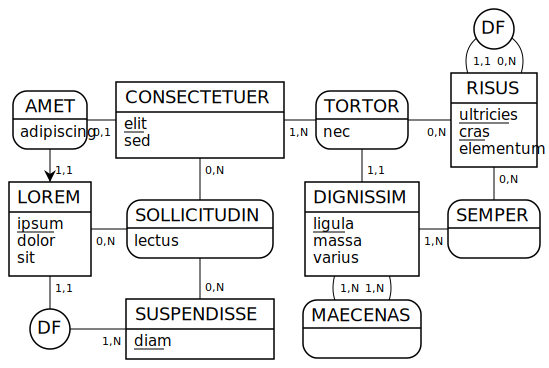

%%mocodo
:
:
:
DF, 11 RISUS, 0N RISUS

AMET, 11> LOREM, 01 CONSECTETUER: adipiscing
CONSECTETUER: elit, sed
TORTOR, 0N RISUS, 11 DIGNISSIM, 1N CONSECTETUER: nec
RISUS: ultricies, _cras, elementum

LOREM: ipsum, dolor, sit
SOLLICITUDIN, 0N SUSPENDISSE, 0N CONSECTETUER, 0N LOREM: lectus
DIGNISSIM: ligula, massa, varius
SEMPER, 0N RISUS, 1N DIGNISSIM

DF, 11 LOREM, 1N SUSPENDISSE
SUSPENDISSE: diam
MAECENAS, 1N DIGNISSIM, 1N DIGNISSIM
:


In [429]:
%%mocodo -r flip:d
:
AMET, 11> LOREM, 01 CONSECTETUER: adipiscing
LOREM: ipsum, dolor, sit
DF, 11 LOREM, 1N SUSPENDISSE

:
CONSECTETUER: elit, sed
SOLLICITUDIN, 0N SUSPENDISSE, 0N CONSECTETUER, 0N LOREM: lectus
SUSPENDISSE: diam

:
TORTOR, 0N RISUS, 11 DIGNISSIM, 1N CONSECTETUER: nec
DIGNISSIM: ligula, massa, varius
MAECENAS, 1N DIGNISSIM, 1N DIGNISSIM

DF, 11 RISUS, 0N RISUS
RISUS: ultricies, _cras, elementum
SEMPER, 0N RISUS, 1N DIGNISSIM


On peut se convaincre en examinant le nouveau texte d'entrée que le résultat aurait été beaucoup plus pénible à obtenir en procédant directement.

## Réarrangement automatique

Il est possible de demander à Mocodo de chercher tout seul une « bonne » permutation des boîtes, ce qui à la main deviendrait vite difficile.

Le critère que nous avons retenu pour évaluer la qualité d'une permutation est double :

1. les liens ne doivent pas se couper ;
2. leur longueur cumulée doit être minimale.

Actuellement, deux algorithmes d'arrangement sont fournis :

- un algorithme exact (`bb`, pour _Branch & Bound_), qui ne trouve que des solutions satisfaisant au premier critère ;
- un algorithme approché (`ga`, pour _Genetic Algorithm_), réservé aux cas où il est impossible d'y satisfaire. L'algorithme va alors chercher des solutions où les liens se coupent seulement le moins possible.

### Méthode exacte (_branch & bound_)

#### Arrangement dans la grille courante

Par défaut, le réarrangement automatique des boîtes s'opère dans les limites de la grille courante ; c'est-à-dire que le MCD résultant aura (au plus) le même nombre de colonnes et de rangées que le texte de départ (ici, $4\times5$) :

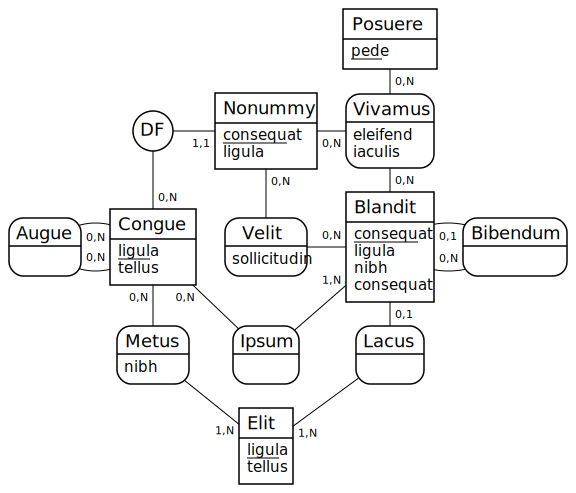

%%mocodo
:
:
:
Posuere: pede
:

:
DF, 11 Nonummy, 0N Congue
Nonummy: consequat, ligula
Vivamus, 0N Posuere, 0N Nonummy, 0N Blandit: eleifend, iaculis
:

Augue, 0N Congue, 0N Congue
Congue: ligula, tellus
Velit, 0N Blandit, 0N Nonummy: sollicitudin
Blandit: consequat, ligula, nibh, consequat
Bibendum, 01 Blandit, 0N Blandit

:
Metus, 1N Elit, 0N Congue: nibh
Ipsum, 1N Blandit, 0N Congue
Lacus, 01 Blandit, 1N Elit
:

:
:
Elit: ligula, tellus
:
:


In [51]:
%%mocodo -u arrange --seed=1 --no_text
Lacus, 01 Blandit, 1N Elit
Elit: ligula, tellus
Metus, 1N Elit, 0N Congue: nibh
Bibendum, 01 Blandit, 0N Blandit

Blandit: consequat, ligula, nibh, consequat
Ipsum, 1N Blandit, 0N Congue
Congue: ligula, tellus
Augue, 0N Congue, 0N Congue

Velit, 0N Blandit, 0N Nonummy: sollicitudin
DF, 11 Nonummy, 0N Congue
Posuere: pede
Vivamus, 0N Posuere, 0N Nonummy, 0N Blandit: eleifend, iaculis

Nonummy: consequat, ligula

On peut quelquefois essayer de réduire cette grille. Par exemple, ce MCD comportant 13 boîtes, celles-ci pourraient théoriquement tenir dans une grille $5\times3=15$. Modifions subrepticement le texte d'entrée à la main pour avoir 3 blocs d'au plus 5 lignes, et vérifions qu'un tel réarrangement est possible:

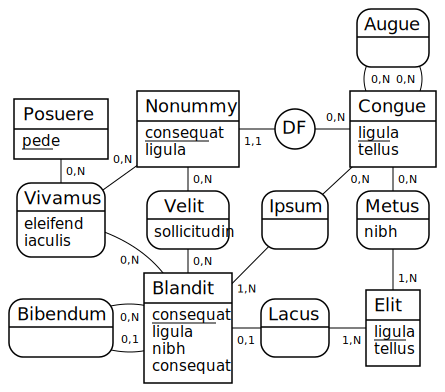

%%mocodo
:
:
:
Augue, 0N Congue, 0N Congue

Posuere: pede
Nonummy: consequat, ligula
DF, 11 Nonummy, 0N Congue
Congue: ligula, tellus

Vivamus, 0N Posuere, 0N Nonummy, 0N Blandit: eleifend, iaculis
Velit, 0N Blandit, 0N Nonummy: sollicitudin
Ipsum, 1N Blandit, 0N Congue
Metus, 1N Elit, 0N Congue: nibh

Bibendum, 01 Blandit, 0N Blandit
Blandit: consequat, ligula, nibh, consequat
Lacus, 01 Blandit, 1N Elit
Elit: ligula, tellus


In [53]:
%%mocodo -u arrange:fit=0 --seed=4 --no_text
Lacus, 01 Blandit, 1N Elit
Elit: ligula, tellus
Metus, 1N Elit, 0N Congue: nibh
Bibendum, 01 Blandit, 0N Blandit
Blandit: consequat, ligula, nibh, consequat

Ipsum, 1N Blandit, 0N Congue
Congue: ligula, tellus
Augue, 0N Congue, 0N Congue
Velit, 0N Blandit, 0N Nonummy: sollicitudin
DF, 11 Nonummy, 0N Congue

Posuere: pede
Vivamus, 0N Posuere, 0N Nonummy, 0N Blandit: eleifend, iaculis
Nonummy: consequat, ligula

Réarranger sur la grille courante est également utile si vous vous rendez compte que votre MCD forme un [graphe chemin](https://fr.wikipedia.org/wiki/Graphe_chemin) :

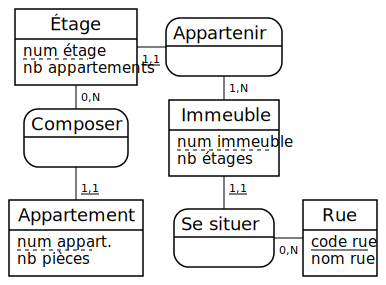

In [165]:
%%mocodo
Étage: num étage, nb appartements
Appartenir, 1N Immeuble, _11 Étage

Composer, 0N Étage, _11 Appartement
Immeuble: num immeuble, nb étages

Appartement: num appart., nb pièces
Se situer, 0N Rue, _11 Immeuble
Rue: code rue, nom rue

Dans ce cas, il vous suffit d'effacer (à la main) les lignes vides avant de lancer le réarrangement :

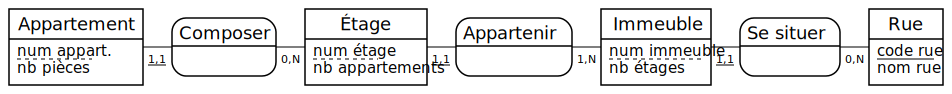

%%mocodo
Appartement: num appart., nb pièces
Composer, 0N Étage, _11 Appartement
Étage: num étage, nb appartements
Appartenir, 1N Immeuble, _11 Étage
Immeuble: num immeuble, nb étages
Se situer, 0N Rue, _11 Immeuble
Rue: code rue, nom rue


In [164]:
%%mocodo -m arrange
Étage: num étage, nb appartements
Appartenir, 1N Immeuble, _11 Étage
Composer, 0N Étage, _11 Appartement
Immeuble: num immeuble, nb étages
Appartement: num appart., nb pièces
Se situer, 0N Rue, _11 Immeuble
Rue: code rue, nom rue

#### Arrangement non contraint

Le réarrangement dit organique consiste à choisir une première boîte au hasard, puis à essayer d'agréger les autres sans se préoccuper de contenir le tout dans une grille prédéterminée. Il est invoqué par l'option `-m arrange_organic`.

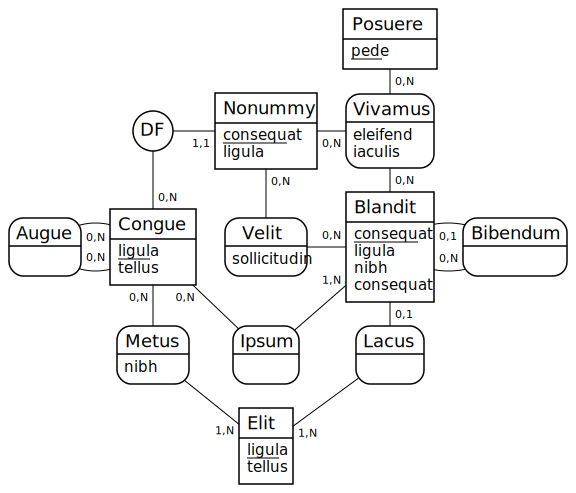

In [15]:
%%mocodo -m arrange_organic --seed=9 --no_text
Lacus, 01 Blandit, 1N Elit
Elit: ligula, tellus
Metus, 1N Elit, 0N Congue: nibh
Bibendum, 01 Blandit, 0N Blandit
Blandit: consequat, ligula, nibh, consequat

Ipsum, 1N Blandit, 0N Congue
Congue: ligula, tellus
Augue, 0N Congue, 0N Congue
Velit, 0N Blandit, 0N Nonummy: sollicitudin
DF, 11 Nonummy, 0N Congue

Posuere: pede
Vivamus, 0N Posuere, 0N Nonummy, 0N Blandit: eleifend, iaculis
Nonummy: consequat, ligula

Cela donne un plongement sur une grille $5\times5$, ce qui est loin d'être optimal. Cependant, l'arrangement organique fournit souvent un bon point de départ pour chercher soi-même une permutation plus esthétique ou mettant en évidence certaines propriétés du MCD, en particulier dans le cas où Mocodo se plaint qu'aucun plongement planaire n'existe sur la grille courante.

#### Arrangement dans une grille équilibrée minimale

**Changement de la version 4.0.** Le reformatage du MCD pour le faire entrer dans une grille minimale n'avait de sens que s'il était suivi d'un réarrangement du MCD. Il y est désormais intégré comme pré-traitement. L'option `--fit` est donc retirée.

**Nouveauté de la version 2.2.** On peut éviter à la fois d'imposer des contraintes dimensionnelles (en modifiant à la main le texte d'entrée) et de les relaxer (en optant pour une croissance organique). On cherche en général à faire tenir le MCD dans la plus petite grille possible, tout en maintenant un rapport « équilibré » entre hauteur et largeur. Par exemple, un MCD de 13 boîtes (entités ou associations) peut tenir dans les grilles:

- $13\times1$;
- $7\times2$, ce qui laisse 1 case vide;
- $5\times3$, ce qui laisse 2 cases vides;
- $4\times4$, ce qui laisse 3 cases vides;
- etc.

Les deux premières grilles étant non équilibrées, on retiendra la plus petite des suivantes, de dimensions $5\times3$.

La table ci-dessous énumère les dimensions des grilles minimales d'équilibre supérieur à 0,5 pour tous les MCD comportant moins de 100 boîtes. On peut y vérifier par exemple que le MCD de taille 13 (en gras) se trouve effectivement aux coordonnées (5, 3).

|  | **1** | **2** | **3** | **4** | **5** | **6** | **7** | **8** | **9** | **10** | **11** | **12** | **13** |
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
| **1** | 1 | 2 | 3 |  |  |  |  |  |  |  |  |  |  |
| **2** |  | 4 | 5, 6 |  |  |  |  |  |  |  |  |  |  |
| **3** |  |  | 7, 8, 9 | 10, 11, 12 | **13**, 14, 15 |  |  |  |  |  |  |  |  |
| **4** |  |  |  | 16 | 17, 18, 19, 20 | 21, 22, 23, 24 | 26, 27, 28 |  |  |  |  |  |  |
| **5** |  |  |  |  | 25 | 29, 30 | 31, 32, 33, 34, 35 | 37, 38, 39, 40 | 43, 44, 45 |  |  |  |  |
| **6** |  |  |  |  |  | 36 | 41, 42 | 46, 47, 48 | 50, 51, 52, 53, 54 | 57, 58, 59, 60 | 65, 66 |  |  |
| **7** |  |  |  |  |  |  | 49 | 55, 56 | 61, 62, 63 | 67, 68, 69, 70 | 73, 74, 75, 76, 77 | 82, 83, 84 | 91 |
| **8** |  |  |  |  |  |  |  | 64 | 71, 72 | 78, 79, 80 | 85, 86, 87, 88 | 92, 93, 94, 95, 96 |  |
| **9** |  |  |  |  |  |  |  |  | 81 | 89, 90 | 97, 98, 99 |  |  |
| **10** |  |  |  |  |  |  |  |  |  | 100 |  |  |  |

**Nouveauté de la version 3.0.** La contrainte d'équilibre est relâchée pour les MCD à 2 et 3 boîtes, qui sont placés respectivement sur des grilles $2\times1$ et $3\times1$ au lieu de $2\times2$.

L'argument `arrange` peut être suffixé d'un `_0` pour imposer un plongement sur la plus petite grille minimale équilibrée, ici donc $5\times3$ :

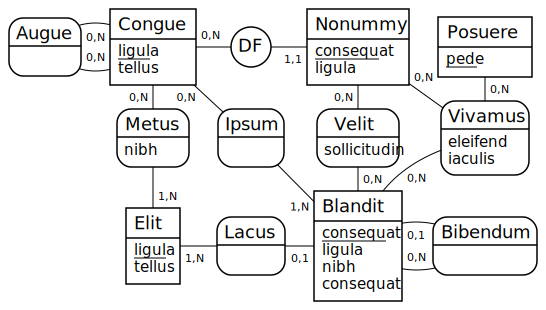

In [17]:
%%mocodo -m arrange_0 --seed 1 --no_text
Lacus, 01 Blandit, 1N Elit
Elit: ligula, tellus
Metus, 1N Elit, 0N Congue: nibh
  
Bibendum, 01 Blandit, 0N Blandit
Blandit: consequat, ligula, nibh, consequat
Ipsum, 1N Blandit, 0N Congue

Congue: ligula, tellus
Augue, 0N Congue, 0N Congue
Velit, 0N Blandit, 0N Nonummy: sollicitudin
  
DF, 11 Nonummy, 0N Congue
Posuere: pede
Vivamus, 0N Posuere, 0N Nonummy, 0N Blandit: eleifend, iaculis
  
Nonummy: consequat, ligula

Si ce réarrangement échoue ou laisse à désirer, il est en fait possible de spécifier n'importe laquelle des grilles suivantes avec l'option `-m arrange_i`, où $i$ est un entier positif. Ci-dessous, `_1` désigne la _première_ des grilles suivant la grille minimale, à savoir $4\times4$.

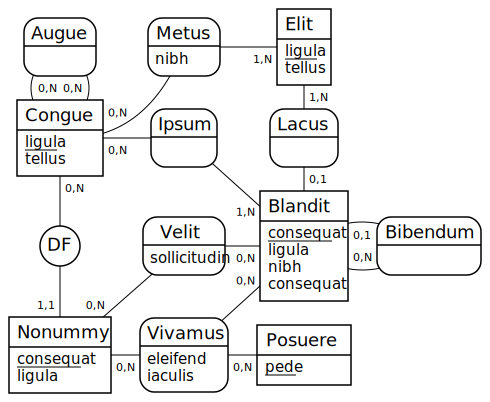

In [30]:
%%mocodo -m arrange_1 --seed 1 --no_text
Lacus, 01 Blandit, 1N Elit
Elit: ligula, tellus
Metus, 1N Elit, 0N Congue: nibh
  
Bibendum, 01 Blandit, 0N Blandit
Blandit: consequat, ligula, nibh, consequat
Ipsum, 1N Blandit, 0N Congue

Congue: ligula, tellus
Augue, 0N Congue, 0N Congue
Velit, 0N Blandit, 0N Nonummy: sollicitudin
  
DF, 11 Nonummy, 0N Congue
Posuere: pede
Vivamus, 0N Posuere, 0N Nonummy, 0N Blandit: eleifend, iaculis
  
Nonummy: consequat, ligula

Et ainsi de suite, `_2` pour la grille $5\times4$ :

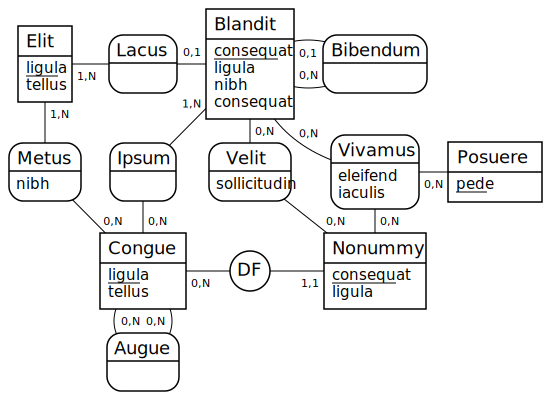

In [33]:
%%mocodo -m arrange_2 --seed 3 --no_text
Lacus, 01 Blandit, 1N Elit
Elit: ligula, tellus
Metus, 1N Elit, 0N Congue: nibh
  
Bibendum, 01 Blandit, 0N Blandit
Blandit: consequat, ligula, nibh, consequat
Ipsum, 1N Blandit, 0N Congue

Congue: ligula, tellus
Augue, 0N Congue, 0N Congue
Velit, 0N Blandit, 0N Nonummy: sollicitudin
  
DF, 11 Nonummy, 0N Congue
Posuere: pede
Vivamus, 0N Posuere, 0N Nonummy, 0N Blandit: eleifend, iaculis
  
Nonummy: consequat, ligula

**Remarques.**
- Quand le suffixe numérique de `arrange` désigne une grille inutilement grande, le réarrangement automatique retombe fréquemment sur une sous-grille de celle-ci.
- Dans [Mocodo online](https://www.mocodo.net), cliquer sur le bouton de réarrangement automatique cherche un plongement planaire non contraint (`arrange_organic`). Avec les touches de modification suivantes, il sera cherché sur une grille prédéfinie (ce qui augmente le risque d'échec) :
  - <kbd>shift</kbd> : la grille courante (`arrange`) ;
  - <kbd>alt</kbd> : la plus petite grille équilibrée (`arrange_0`) ;
  - <kbd>shift</kbd><kbd>alt</kbd> : la première grille suivante (`arrange_1`).
- Changement de la version 4.0. Le reformatage d'un MCD pour le faire entrer dans une grille minimale (option `--fit`) n'avait de sens que s'il était suivi d'un réarrangement. Il y est maintenant intégré. L'option est donc retirée.

 #### Limitations

Pour permettre au programme de rendre plus rapidement de bonnes solutions, on a borné arbitrairement le nombre d'appels à la fonction chargée de construire une permutation à partir du placement de la première boîte. De ce fait, l'algorithme n'est plus exact, en ce sens que la meilleure solution peut occasionnellement lui échapper. Si vous soupçonnez que c'est le cas, faites un autre essai, éventuellement en augmentant la borne (par défaut 10000):
```shell
mocodo --arrange --call_limit=100000
```

D'autre part, le réarrangement exact ne fonctionnera jamais sur les MCD:
  
- non planaires;
- planaires, mais n'admettant aucun plongement planaire dans les limites de la grille spécifiée.

Rappelons qu'un graphe est dit [planaire](https://fr.wikipedia.org/wiki/Graphe_planaire) lorsqu'il en existe au moins un arrangement sans croisement. Le graphe non planaire comportant le plus petit nombre de liens est connu sous le doux nom de [$K_{3,3}$](http://www.nomachetejuggling.com/2011/10/29/why-the-complete-bipartite-graph-k33-is-not-planar/):

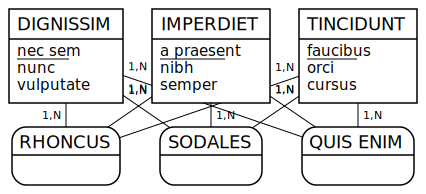

In [80]:
%%mocodo
DIGNISSIM: nec sem, nunc, vulputate
IMPERDIET: a praesent, nibh, semper
TINCIDUNT: faucibus, orci, cursus

RHONCUS, 1N DIGNISSIM, 1N IMPERDIET, 1N TINCIDUNT
SODALES, 1N DIGNISSIM, 1N IMPERDIET, 1N TINCIDUNT
QUIS ENIM, 1N DIGNISSIM, 1N IMPERDIET, 1N TINCIDUNT

Son réarrangement par _Branch & bound_ échouera donc nécessairement :

In [122]:
%%mocodo -r arrange
DIGNISSIM: nec sem, nunc, vulputate
IMPERDIET: a praesent, nibh, semper
TINCIDUNT: faucibus, orci, cursus

RHONCUS, 1N DIGNISSIM, 1N IMPERDIET, 1N TINCIDUNT
SODALES, 1N DIGNISSIM, 1N IMPERDIET, 1N TINCIDUNT
QUIS ENIM, 1N DIGNISSIM, 1N IMPERDIET, 1N TINCIDUNT

Traceback (most recent call last):
  File "/Users/aristide/opt/anaconda3/bin/mocodo", line 8, in <module>
    sys.exit(main())
  File "/Users/aristide/Dropbox/Sites/mocodo/mocodo/__main__.py", line 250, in main
    run()
  File "/Users/aristide/Dropbox/Sites/mocodo/mocodo/__main__.py", line 69, in __call__
    source = self.arrange(source, subargs)
  File "/Users/aristide/Dropbox/Sites/mocodo/mocodo/__main__.py", line 146, in arrange
    raise ValueError(is_constrained)
ValueError: False


In [127]:
%%mocodo -r arrange:grid=organic
DIGNISSIM: nec sem, nunc, vulputate
IMPERDIET: a praesent, nibh, semper
TINCIDUNT: faucibus, orci, cursus

RHONCUS, 1N DIGNISSIM, 1N IMPERDIET, 1N TINCIDUNT
SODALES, 1N DIGNISSIM, 1N IMPERDIET, 1N TINCIDUNT
QUIS ENIM, 1N DIGNISSIM, 1N IMPERDIET, 1N TINCIDUNT

Mocodo Err.41 - Impossible de calculer une mise en page planaire sur la grille impartie.


Comme on voit, Mocodo ne cherche pas à savoir si la non-planarité est intrinsèque au graphe, ou résulte des dimensions de la grille imposée pour le plongement. Pour en avoir le cœur net, tentez un arrangement non contraint :

In [126]:
%%mocodo -r arrange:grid=0
DIGNISSIM: nec sem, nunc, vulputate
IMPERDIET: a praesent, nibh, semper
TINCIDUNT: faucibus, orci, cursus

RHONCUS, 1N DIGNISSIM, 1N IMPERDIET, 1N TINCIDUNT
SODALES, 1N DIGNISSIM, 1N IMPERDIET, 1N TINCIDUNT
QUIS ENIM, 1N DIGNISSIM, 1N IMPERDIET, 1N TINCIDUNT

Mocodo Err.9 - Failed to calculate a planar layout on the given grid.


### Méthode heuristique (algorithme génétique)

Dans tous ces cas, on pourra se rabattre sur l'heuristique. Celle-ci, au lieu d'interdire les croisements, cherche simplement à en minimiser le nombre. L'algorithme est invoqué en précisant à part `--arrangement ga` (pour _Genetic Algorithm_). Les éventuels suffixes de `arrange` sont alors ignorés.

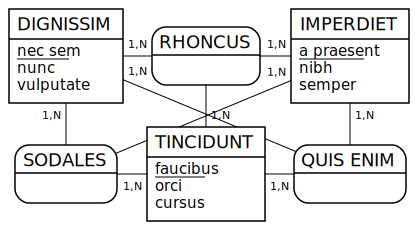

%%mocodo
DIGNISSIM: nec sem, nunc, vulputate
RHONCUS, 1N DIGNISSIM, 1N IMPERDIET, 1N TINCIDUNT
IMPERDIET: a praesent, nibh, semper

SODALES, 1N DIGNISSIM, 1N IMPERDIET, 1N TINCIDUNT
TINCIDUNT: faucibus, orci, cursus
QUIS ENIM, 1N DIGNISSIM, 1N IMPERDIET, 1N TINCIDUNT


In [42]:
%%mocodo -m arrange --arrangement=ga --seed=42
DIGNISSIM: nec sem, nunc, vulputate
IMPERDIET: a praesent, nibh, semper
TINCIDUNT: faucibus, orci, cursus

RHONCUS, 1N DIGNISSIM, 1N IMPERDIET, 1N TINCIDUNT
SODALES, 1N DIGNISSIM, 1N IMPERDIET, 1N TINCIDUNT
QUIS ENIM, 1N DIGNISSIM, 1N IMPERDIET, 1N TINCIDUNT

L'amélioration ne saute pas forcément aux yeux, mais il n'y a plus que 3 croisements au lieu de 9. Ce plongement constitue en tout cas un bon point de départ pour un réarrangement manuel. Pour arriver à une représentation lisible, il ne reste plus qu'à insérer quelques boîtes invisibles:

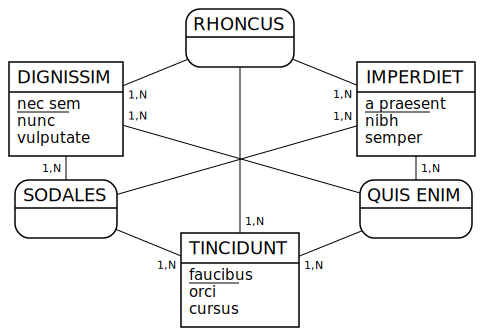

In [43]:
%%mocodo
RHONCUS, 1N DIGNISSIM, 1N IMPERDIET, 1N TINCIDUNT

DIGNISSIM: nec sem, nunc, vulputate
:::
IMPERDIET: a praesent, nibh, semper

SODALES, 1N DIGNISSIM, 1N IMPERDIET, 1N TINCIDUNT
:::
QUIS ENIM, 1N DIGNISSIM, 1N IMPERDIET, 1N TINCIDUNT

TINCIDUNT: faucibus, orci, cursus

**NB.** De nombreux paramètres permettent de régler le fonctionnement de l'algorithme génétique :

- `population_size` (défaut : 1000)
- `max_generations` (défaut : 300)
- `plateau` (défaut : 30)
- `crossover_rate` (défaut : 0.9)
- `mutation_rate` (défaut : 0.06)
- `sample_size` (défaut : 7)

Réservés aux spécialistes, ils ne sont pas décrits dans cette documentation.

## Conversion dans d'autres formats graphiques

Mocodo génère systématiquement une sortie au format SVG :

In [104]:
%%mocodo --no_mcd --svg_to png pdf
CLIENT: Réf. client, Nom, Prénom, Adresse
PASSER, 0N CLIENT, 11 COMMANDE
COMMANDE: Num. commande, Date, Montant
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantité
PRODUIT: Réf. produit, Libellé, Prix unitaire

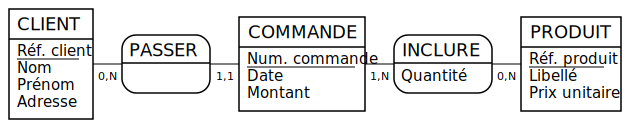

In [105]:
display.SVG("mocodo_notebook/sandbox.svg")

**Nouveauté de la version 3.0.** Avec l'option `--svg_to` suivie de `pdf` et/ou `png` (ou en cochant les cases correspondantes dans l'onglet Options de la version web), Mocodo convertit désormais ce SVG en PDF et PNG. Le premier format est idéal pour l'inclusion dans des documents destinés à être projetés, diffusés ou imprimés :

In [106]:
display.IFrame("mocodo_notebook/sandbox.pdf", width="100%", height="100%")

Le second est un format bitmap, donc avec une certaine perte de qualité :

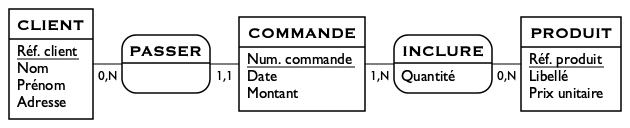

In [107]:
display.Image("mocodo_notebook/sandbox.png")

Attention, dans un cas comme dans l'autre, seules les polices de caractères les plus courantes seront composées correctement sur toutes les plateformes.

**Changement de la version 4.0.** Ces fonctionnalités ne sont plus accessibles avec les options `--pdf` et `--png` (retirées), mais comme arguments de la nouvelle option `--svg_to`.

# Conversion en relationnel

Le passage au relationnel se fait en deux étapes:
- la création d'une représentation **interne** complète du MLD;
- la traduction de celle-ci en une représentation **externe** dans le ou les formats de sortie souhaités.

## Construction de la représentation interne

L'algorithme de base réalise la séquence d'opérations suivante :

1. Pour chaque entité, une relation (table) de même nom et de mêmes attributs est créée. Le ou les identifiants de l'entité constituent la clé primaire de la relation.
2. Toute relation issue d'une entité faible est renforcée, c'est-à-dire que la clé primaire de l'entité qu'elle détermine fonctionnellement vient s'adjoindre à sa clé primaire, au besoin de façon récursive.
3. Les associations sont traitées ainsi:
  1. si toutes les pattes de l'association portent la cardinalité maximale N, une relation de même nom et de mêmes attributs est créée. Sa clé primaire est constituée de l'ensemble des clés primaires des relations issues des entités mises en jeu;
  2. dans le cas contraire, c'est-à-dire si l'une des pattes de l'association porte la cardinalité (1,1), ou à défaut (0,1), l'entité distinguée se voit adjoindre:
    1. en tant que clés étrangères, l'ensemble des clés primaires des autres entités mises en jeu;
    2. en tant que simples attributs, l'ensemble des attributs de l'association.

**Remarque.** Un couple de cardinalités non standard, c'est-à-dire distinct de (0,1), (1,1), (0,N) et (1,N), est traité comme (0,1) si son deuxième symbole est un 1, et comme (0,N) sinon. Cela couvre en particulier les cas (\*, 1), (\*,N), (?,?) et (X,X).

### Traitement des associations non DF

Illustrons le premier cas du troisième point sur un MCD comportant des associations triple, double et réflexive dont toutes les cardinalités maximales sont à N.

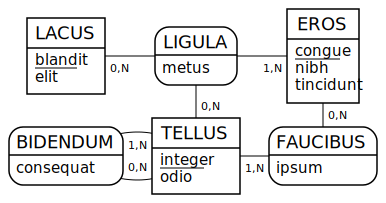

In [48]:
%%mocodo --mld
LACUS: blandit, elit
LIGULA, 0N LACUS, 1N EROS, 0N TELLUS: metus
EROS: congue, nibh, tincidunt  

BIDENDUM, 0N TELLUS, 1N TELLUS: consequat
TELLUS: integer, odio
FAUCIBUS, 1N TELLUS, 0N EROS: ipsum

Notez la [désambiguïsation automatique par numérotation](#disambiguation_by_number) du deuxième attribut de BIBENDUM.

### Traitement des associations DF

Illustrons l'autre cas sur un MCD quasiment identique, à ceci près que certaines cardinalités maximales ont été ramenées à 1. En tant que dépendances fonctionnelles, toutes les associations vont alors disparaître.

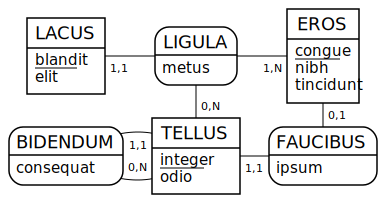

In [49]:
%%mocodo --mld
LACUS: blandit, elit
LIGULA, 11 LACUS, 1N EROS, 0N TELLUS: metus
EROS: congue, nibh, tincidunt  

BIDENDUM, 0N TELLUS, 11 TELLUS: consequat
TELLUS: integer, odio
FAUCIBUS, 11 TELLUS, 01 EROS: ipsum

Notez les points suivants:
- la cardinalité (1,1) est par défaut prioritaire sur (0,1) lors du traitement de l'association FAUCIBUS;
- Mocodo n'impose pas de borne supérieure à l'arité d'une association de dépendance fonctionnelle, ici par exemple LIGULA est ternaire (alternative: `-m split`);
- Mocodo n'interdit pas à une association de dépendance fonctionnelle de porter des attributs (alternative: `-m drain`).

Les deux alternatives mentionnées, plus orthodoxes mais plus lourdes, produisent de toute façon le même schéma relationnel.

Autre point litigieux: dans les dépendances fonctionnelles à double sens ((1,1) des deux côtés), la priorité est donnée à la première des entités énumérées dans l'association. Même chose quand deux (0,1) sont en concurrence.

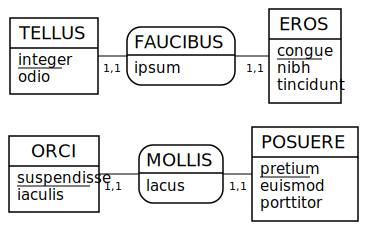

In [50]:
%%mocodo --mld
TELLUS: integer, odio
FAUCIBUS, 11 TELLUS, 11 EROS: ipsum
EROS: congue, nibh, tincidunt  

ORCI: suspendisse, iaculis
MOLLIS, 11 POSUERE, 11 ORCI: lacus
POSUERE: pretium, euismod, porttitor

Les traitements alternatifs (migration dans les deux sens, fusion en une seule table, etc.)  ne sont pas pris en charge par Mocodo.

### Traitement des entités faibles (identification relative)

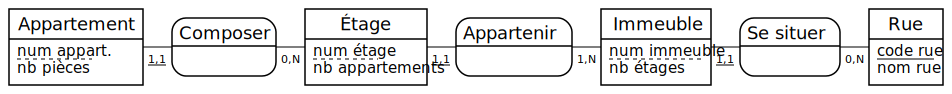

In [51]:
%%mocodo --mld --relations diagram
Appartement: num appart., nb pièces
Composer, 0N Étage, _11 Appartement
Étage: num étage, nb appartements
Appartenir, 1N Immeuble, _11 Étage
Immeuble: num immeuble, nb étages
Se situer, 0N Rue, _11 Immeuble
Rue: code rue, nom rue

Dans ce joli exemple dû à Idris NEUMANN, [_Initiation à la conception de bases de données relationnelles avec MERISE_](http://ineumann.developpez.com/tutoriels/merise/initiation-merise/#LIV-A), les renforcements successifs aboutissent à faire entrer l'identifiant de RUE dans celui de APPARTEMENT, alors même que ces entités sont séparées par non moins de trois associations.

Ce processus apparaît clairement sur le [diagramme relationnel](#Diagramme-relationnel) généré par la commande précédente:

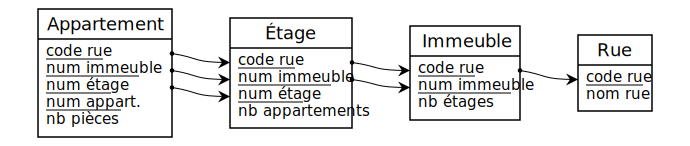

In [52]:
%mocodo --input sandbox.mld

Les renforcements en cascade sont correctement gérés dans tous les cas, et les renforcements cycliques produisent un message d'erreur.

In [61]:
%%mocodo
Pick, 0N Land, _11 Peer
Land: true, hold

Peer: foot, city
Zone, 1N Peer, _11 Land

Mocodo Err.17 - Cycle d'entités faibles dans "Land", "Peer".


### Rétablissement explicite de la sémantique des DF disparues

Mocodo permet de modifier légèrement le nom d'une clé étrangère, de façon à réintroduire la sémantique perdue lors de la disparition de l'association de dépendance fonctionnelle par laquelle elle a migré.

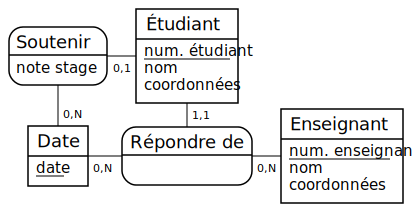

In [62]:
%%mocodo --mld
Soutenir, 01 Étudiant, 0N Date: note stage
Étudiant: num. étudiant, nom, coordonnées

Date: date
Répondre de, 0N Date, 11 Étudiant, 0N Enseignant
Enseignant: num. enseignant, nom, coordonnées

Par exemple, ci-dessus, la conversion en relationnel produit dans la relation ÉTUDIANT des clés étrangères _date_ et _date.1_ qui ne peuvent être laissées en l'état. Par ailleurs, on peut souhaiter expliciter la raison pour laquelle un numéro d'enseignant apparaît dans la table ÉTUDIANT.

Dans les deux cas, il suffit d'employer le système d'annotation de pattes introduit [plus haut](#Afficher-l'explication-des-cardinalit%C3%A9s). Le nom entre crochets s'appelle alors un **rôle**.

In [94]:
%%mocodo --mld --no_mcd
Soutenir, 01 Étudiant, 0N [soutenance] Date: note stage
Étudiant: num. étudiant, nom, coordonnées

Date: date
Répondre de, 0N [visite] Date, 11 Étudiant, 0N [responsable] Enseignant
Enseignant: num. enseignant, nom, coordonnées

De façon moins cruciale, la technique s'applique aussi aux autres types d'association:

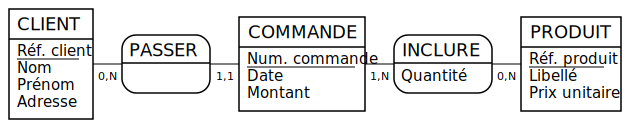

In [63]:
%%mocodo --mld
CLIENT: Réf. client, Nom, Prénom, Adresse
PASSER, 0N [ayant commandé] CLIENT, 11 [note ignorée] COMMANDE
COMMANDE: Num. commande, Date, Montant
INCLURE, 1N [passée] COMMANDE, 0N [commandé] PRODUIT: Quantité
PRODUIT: Réf. produit, Libellé, Prix unitaire

Pour désactiver cette fonctionnalité (notamment dans le cas où vous annotez chaque cardinalité d'une explication destinée aux novices), passez l'option `--disambiguation=numbers_only`.

### Conversion forcée d'une association DF en table

Le traitement régulier d'une association DF (présence d'une cardinalité (1,1) ou, à défaut, (0,1)) ne la convertit pas en table. On a cependant la possibilité de forcer cette conversion en préfixant son nom d'un signe « `+` ».

**Nouveauté de la version 4.0.** Auparavant, il fallait mettre entre crochets droits le nom de l'association. La nouvelle notation est cohérente avec celle utilisée pour [empêcher la suppression d'une table réduite à sa clé primaire](#Suppression-des-tables-indépendantes-réduites-à-leur-clé-primaire).

Par exemple, supposons une cardinalité (0,1) dans laquelle le 0 est grand devant le 1 en termes de fréquence d'apparition : par défaut, la plupart des occurrences de la clé étrangère ainsi constituée restent vides. Forcer la création d'une table dédiée permettra d'économiser de l'espace de stockage.

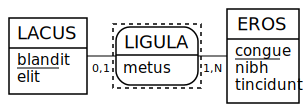

In [64]:
%%mocodo --relations html_verbose
LACUS: blandit, elit
+LIGULA, 01 LACUS, 1N EROS: metus
EROS: congue, nibh, tincidunt

In [65]:
display.HTML("mocodo_notebook/sandbox_verbose.html")

Cliquez sur LIGULA ci-dessus pour voir mentionner le fait que la création de la table a été forcée manuellement.

La nouvelle notation fonctionne quelles que soient les cardinalités de l'association. Si cette dernière devait déjà donner lieu à la création d'une table, l'indication est visualisée, mais ignorée lors du passage au relationnel.

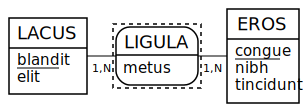

In [68]:
%%mocodo --relations html_verbose
LACUS: blandit, elit
+LIGULA, 1N LACUS, 1N EROS: metus
EROS: congue, nibh, tincidunt

In [69]:
display.HTML("mocodo_notebook/sandbox_verbose.html")

**Limitation.** Cette conversion forcée ne fonctionne si l'association est appelée « DF », qui clairement ne constituerait pas un bon nom de table.

### Réduction de clé primaire (ou agrégation, ou pseudo-entité)

Il arrive qu'un sous-ensemble strict de l'ensemble des identifiants des entités mises en jeu dans une association dont toutes les pattes portent la cardinalité N, suffise à constituer la clé primaire de la table issue de cette association : cela se fait facilement au niveau relationnel en privant de leur caractère identifiant les clés qui n'appartiennent pas à ce sous-ensemble.

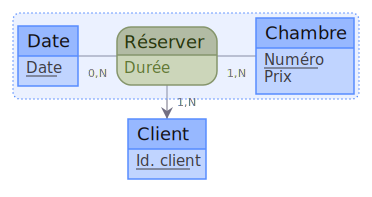

**Chambre** (<ins>Numéro</ins>, Prix)<br>
**Réserver** (<ins>_#Numéro_</ins>, <ins>Date</ins>, Id. client, Durée)


In [46]:
%%mocodo --mld --colors ocean
Date: Date
Réserver, /1N Client, 1N Chambre, 0N Date: Durée
Chambre: Numéro, Prix

Client: Id. client

C'est plus ou moins équivalent à la notion traditionnelle d'agrégation ou pseudo-entité.

Le traitement se généralise naturellement aux agrégats réduits à une seule entité :

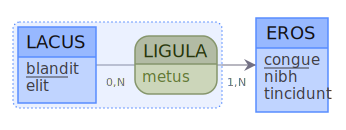

**EROS** (<ins>congue</ins>, nibh, tincidunt)<br>
**LACUS** (<ins>blandit</ins>, elit)<br>
**LIGULA** (<ins>_#blandit_</ins>, _#congue_, metus)


In [124]:
%%mocodo --mld --colors ocean
LACUS: blandit, elit
LIGULA, 0N LACUS, /1N EROS: metus
EROS: congue, nibh, tincidunt

TODO: ça doit être faux. Voir une bonne solution deux cellules plus loin.

In [126]:
%mocodo --input sandbox -c chen:layout=circo defer --colors=ocean

Version équivalente avec entité faible :

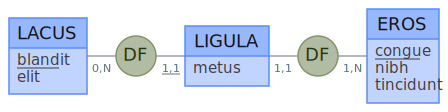

**EROS** (<ins>congue</ins>, nibh, tincidunt)<br>
**LACUS** (<ins>blandit</ins>, elit)<br>
**LIGULA** (<ins>_#blandit_</ins>, metus, _#congue_)


In [420]:
%%mocodo --mld --colors ocean
LACUS: blandit, elit
DF, 0N LACUS, _11 LIGULA
LIGULA: _metus
DF, 11 LIGULA, 1N EROS
EROS: congue, nibh, tincidunt

In [421]:
%mocodo --input sandbox -c chen:layout=circo defer --colors=ocean

### Traitement de l'héritage

#### Sémantique de la flèche

- Le sens de la flèche détermine si la migration d'attributs se fait de la mère vers les filles (`>`) ou l'inverse (`<`).
- Son épaisseur détermine si la migration est « minimale » (`-`) ou « maximale » (`=`).

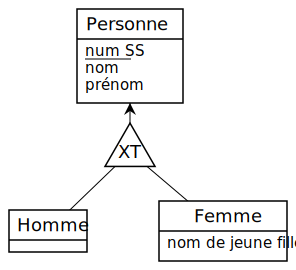

In [72]:
%%mocodo --mld
Personne: num SS, nom, prénom

/XT\ Personne <- Homme, Femme: sexe

Homme: 
:
Femme: nom de jeune fille

Ci-dessus, le passage au relationnel produit une seule table :
- _num SS_ est l'identifiant ;
- _nom_ et _prénom_ sont des champs communs à toutes les occurrences ;
- _sexe_ permet de préciser si une ligne donnée correspond à un homme et/ou une femme. Si le type d'héritage est total et exclusif, un booléen « non nullable » (`NOT NULL` en SQL) fera l'affaire ; s'il n'y a pas totalité, certaines personnes ne sont ni homme, ni femme, et ce booléen est « nullable » ; s'il n'y a pas exclusion, certaines personnes peuvent être à la fois homme et femme, et dans ce cas on peut choisir de coder le type par un entier que l'on interprétera en binaire.
- _nom de jeune fille_ est un attribut spécifique aux femmes. Notez qu'il peut être nul, non seulement pour les occurrences « non femmes », mais aussi pour les occurrences « femmes » célibataires. Cela montrer l'intérêt de disposer d'un champ _sexe_ séparé.

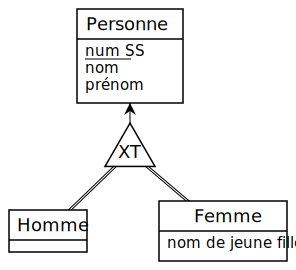

In [73]:
%%mocodo --mld
Personne: num SS, nom, prénom

/XT\ Personne <= Homme, Femme: sexe

Homme: 
:
Femme: nom de jeune fille

Ci-dessus, on a doublé la flèche pour réaliser une migration « maximale » des entités-filles vers l'entité-mère. Notez le doublement des pattes qui distinguent les entités-filles. Deux nouveaux champs sont apparus : _Homme_ et _Femme_, censés être de type booléen. Selon le type d'héritage, ils sont ici plus ou moins redondants avec _sexe_ (si c'est `/XT\`, _sexe_ est préférable, mais si c'est `/\`, _sexe_ peut être supprimé).

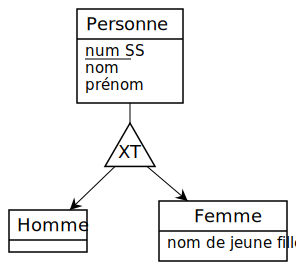

In [74]:
%%mocodo --mld
Personne: num SS, nom, prénom

/XT\ Personne -> Homme, Femme: sexe

Homme: 
:
Femme: nom de jeune fille

Ci-dessus, on a réalisé une migration « minimale » de la mère vers les filles. Notez l'inversion du sens des flèches sur le schéma conceptuel.

- Une table _Personne_ accueille les attributs communs. Notez la présence du champ _sexe_.
- Une table _Femme_ complète ces informations par l'attribut spécifique _nom de jeune fille_.
- La table _Homme_, réduite à sa clé primaire, a été supprimée.

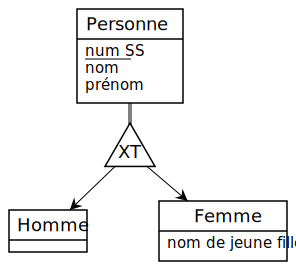

In [75]:
%%mocodo --mld
Personne: num SS, nom, prénom

/XT\ Personne => Homme, Femme: sexe

Homme: 
:
Femme: nom de jeune fille

Avec une migration « maximale » vers les entités-filles, les attributs communs sont « déplacés » dans chacune des tables-filles. Aucune table-mère n'est créée.

Cela n'est possible que si l'héritage est total (`/T\` ou `/XT\`) ; dans le cas contraire, certaines occurrences (celles qui ne sont ni homme, ni femme) seraient perdues. Mocodo lève alors une erreur :

In [76]:
%%mocodo --mld
Personne: num SS, nom, prénom

/X\ Personne => Homme, Femme: sexe

Homme: 
:
Femme: nom de jeune fille

Mocodo Err.25 - La totalité (/T\ or /XT\) est requise pour définir l'héritage « => » sur
l'entité-mère « Personne ».


#### Héritage et associations externes

Trois des quatre mécanismes de passage au relationnel décrits ci-dessus conduisent à la disparition d'entités. Pour assurer que les jointures restent possibles, il faut alors veiller à « recoller » les références qui transitaient par ces entités. On se donne ci-dessous un MCD où les entités d'un héritage sont associées de façon diverses à des entités externes, et on étudie les tables et le diagramme relationnel produits selon le mécanisme de passage au relationnel demandé.

**Aide.** Cliquez sur le nom des tables pour lire les explications détaillées. Survolez le libellé des attributs pour afficher leur catégorie attribuée en interne par Mocodo (à des fins de débogage).

Voici un éventail de cas possibles pour le mécanisme de migration `<-` vers une entité-mère, avec disparition des entités-filles (le cas `<=`, essentiellement identique, n'est pas donné).

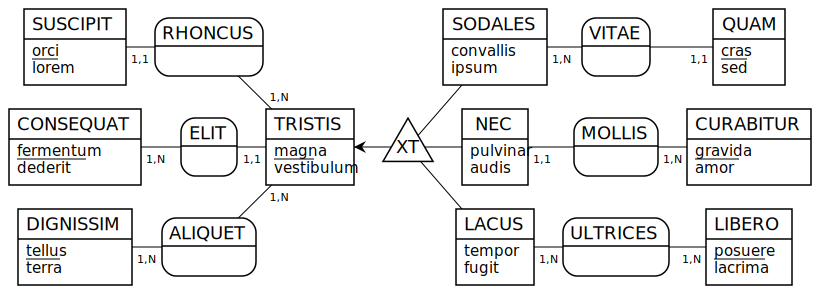

In [77]:
%%mocodo --relations diagram html_verbose
SUSCIPIT: orci, lorem
RHONCUS, 1N TRISTIS, 11 SUSCIPIT
:
:
SODALES: convallis, ipsum
VITAE, 11 QUAM, 1N SODALES
QUAM: cras, sed

CONSEQUAT: fermentum, dederit
ELIT, 11 TRISTIS, 1N CONSEQUAT
TRISTIS: magna, vestibulum
/XT\ TRISTIS <- SODALES, NEC, LACUS: type
NEC: pulvinar, audis
MOLLIS, 1N CURABITUR, 11 NEC
CURABITUR: gravida, amor

DIGNISSIM: tellus, terra
ALIQUET, 1N TRISTIS, 1N DIGNISSIM
:
:
LACUS: tempor, fugit
ULTRICES, 1N LIBERO, 1N LACUS
LIBERO: posuere, lacrima

In [78]:
display.HTML("mocodo_notebook/sandbox_verbose.html")

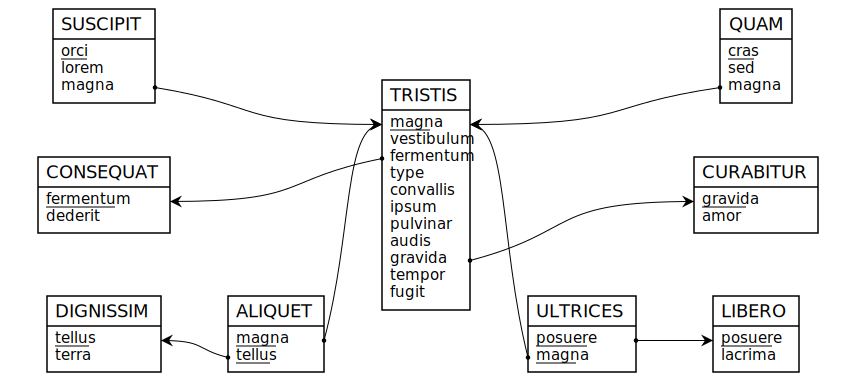

In [79]:
%mocodo --input sandbox.mld

C'est la partie droite de ce diagramme relationnel qui est intéressante. Notez que la disparition des entités-filles n'empêche pas de lier _Quam_, _Curabitur_ et _Ultrices_ à la table-mère _Tristis_.

Changeons maintenant le sens de la flèche :

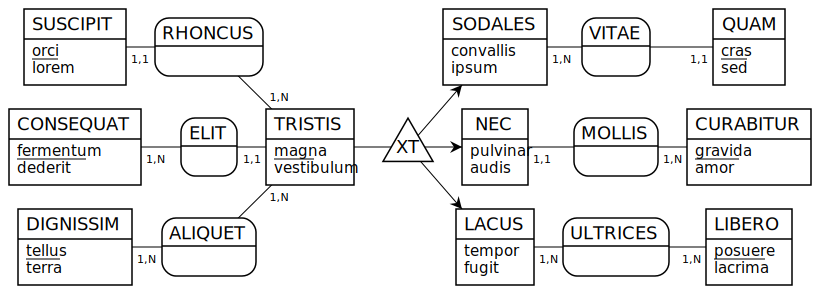

In [80]:
%%mocodo --relations diagram html_verbose
SUSCIPIT: orci, lorem
RHONCUS, 1N TRISTIS, 11 SUSCIPIT
:
:
SODALES: convallis, ipsum
VITAE, 11 QUAM, 1N SODALES
QUAM: cras, sed

CONSEQUAT: fermentum, dederit
ELIT, 11 TRISTIS, 1N CONSEQUAT
TRISTIS: magna, vestibulum
/XT\ TRISTIS -> SODALES, NEC, LACUS: type
NEC: pulvinar, audis
MOLLIS, 1N CURABITUR, 11 NEC
CURABITUR: gravida, amor

DIGNISSIM: tellus, terra
ALIQUET, 1N TRISTIS, 1N DIGNISSIM
:
:
LACUS: tempor, fugit
ULTRICES, 1N LIBERO, 1N LACUS
LIBERO: posuere, lacrima

In [81]:
display.HTML("mocodo_notebook/sandbox_verbose.html")

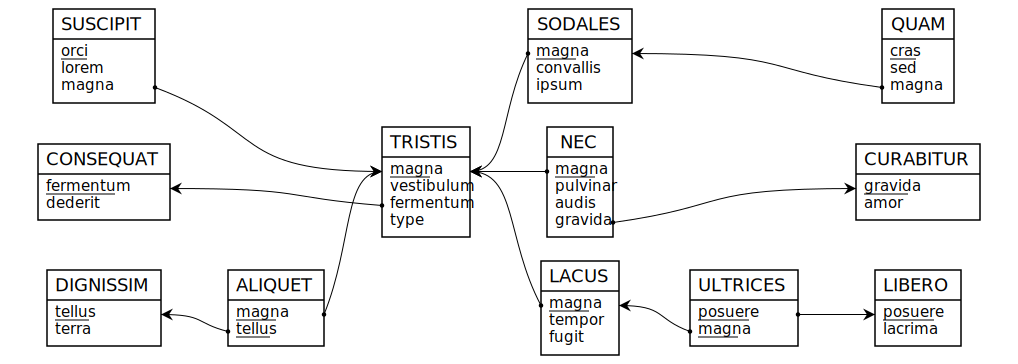

In [82]:
%mocodo --input sandbox.mld

Ce cas est facile, puisque toutes les entités ont donné lieu à la création d'une table.

C'est plus compliqué si l'on demande une migration « maximale » vers les entités-filles (avec disparition de l'entité-mère) :

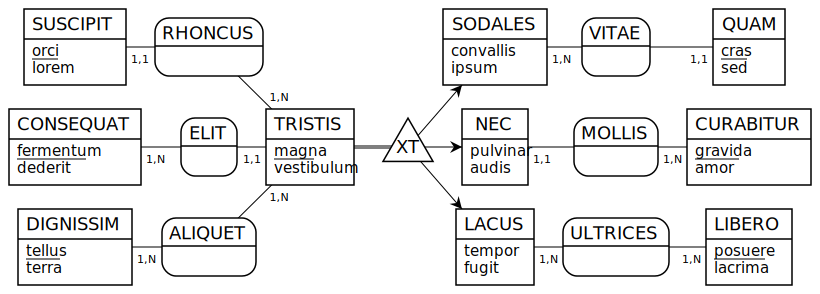

In [83]:
%%mocodo --relations diagram html_verbose
SUSCIPIT: orci, lorem
RHONCUS, 1N TRISTIS, 11 SUSCIPIT
:
:
SODALES: convallis, ipsum
VITAE, 11 QUAM, 1N SODALES
QUAM: cras, sed

CONSEQUAT: fermentum, dederit
ELIT, 11 TRISTIS, 1N CONSEQUAT
TRISTIS: magna, vestibulum
/XT\ TRISTIS => SODALES, NEC, LACUS: type
NEC: pulvinar, audis
MOLLIS, 1N CURABITUR, 11 NEC
CURABITUR: gravida, amor

DIGNISSIM: tellus, terra
ALIQUET, 1N TRISTIS, 1N DIGNISSIM
:
:
LACUS: tempor, fugit
ULTRICES, 1N LIBERO, 1N LACUS
LIBERO: posuere, lacrima

In [84]:
display.HTML("mocodo_notebook/sandbox_verbose.html")

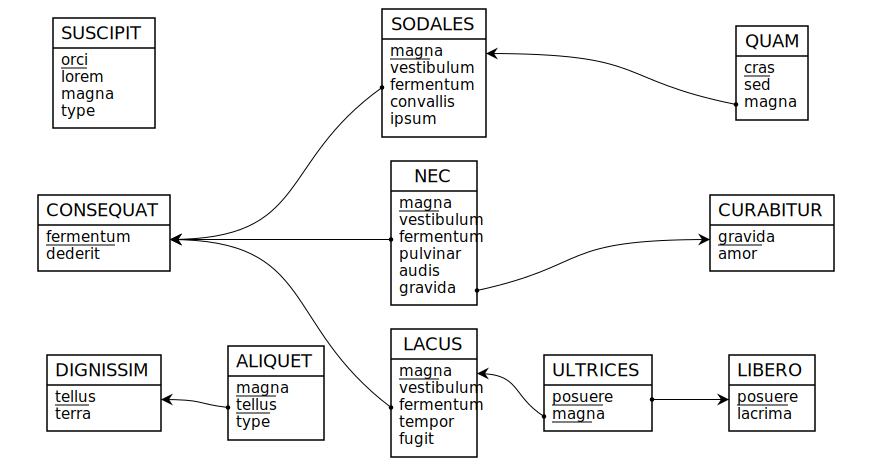

In [85]:
%mocodo --input sandbox.mld

On remarque que la clé étrangère _fermentum_ est correctement reproduite dans les tables-filles, mais que les tables _Suscipit_ et _Aliquet_ ne sont plus liées au reste du MCD. L'intégrité référentielle du champ _magna_ n'est plus assurée. Notez cependant que le champ _type_ défini avec l'héritage migre jusque dans ces tables. Ainsi, _type_ permet de savoir si la valeur de _magna_ dans une occurrence de _Suscipit_ réfère à une occurrence de _Sodales_, de _Nec_ ou de _Lacus_.

#### Héritage et associations internes

On passe maintenant en revue, sans commentaire, le traitement des différentes forme d'héritage lorsque des associations lient l'entité-mère et les entités-filles.

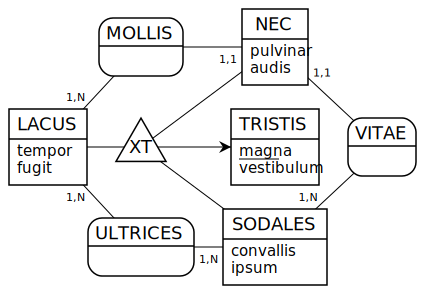

In [86]:
%%mocodo --relations diagram html_verbose
:
MOLLIS, 1N [via mollis] LACUS, 11 NEC
NEC: pulvinar, audis
:

LACUS: tempor, fugit
/XT\ TRISTIS <- SODALES, NEC, LACUS: type
TRISTIS: magna, vestibulum
VITAE, 11 NEC, 1N [via vitae] SODALES

:
ULTRICES, 1N [sodales] SODALES, 1N [lacus] LACUS
SODALES: convallis, ipsum
:

In [87]:
display.HTML("mocodo_notebook/sandbox_verbose.html")

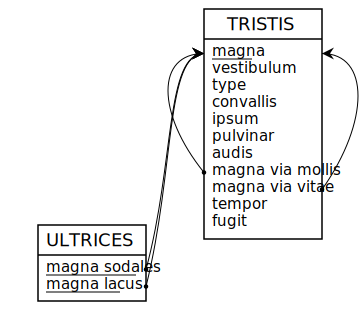

In [88]:
%mocodo --input sandbox.mld

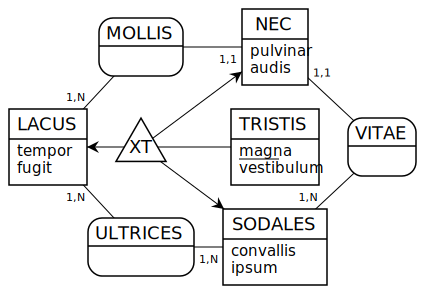

In [89]:
%%mocodo --relations diagram html_verbose
:
MOLLIS, 1N [via mollis] LACUS, 11 NEC
NEC: pulvinar, audis
:

LACUS: tempor, fugit
/XT\ TRISTIS -> SODALES, NEC, LACUS: type
TRISTIS: magna, vestibulum
VITAE, 11 NEC, 1N [via vitae] SODALES

:
ULTRICES, 1N [sodales] SODALES, 1N [lacus] LACUS
SODALES: convallis, ipsum
:

In [90]:
display.HTML("mocodo_notebook/sandbox_verbose.html")

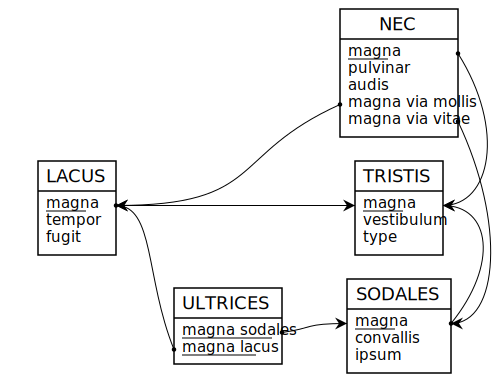

In [91]:
%mocodo --input sandbox.mld

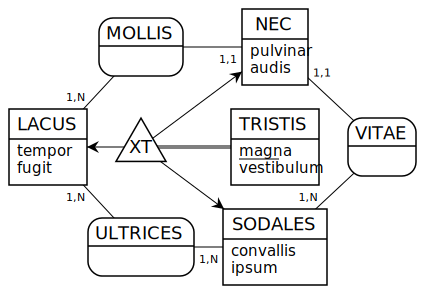

In [92]:
%%mocodo --relations diagram html_verbose
:
MOLLIS, 1N [via mollis] LACUS, 11 NEC
NEC: pulvinar, audis
:

LACUS: tempor, fugit
/XT\ TRISTIS => SODALES, NEC, LACUS: type
TRISTIS: magna, vestibulum
VITAE, 11 NEC, 1N [via vitae] SODALES

:
ULTRICES, 1N [sodales] SODALES, 1N [lacus] LACUS
SODALES: convallis, ipsum
:

In [93]:
display.HTML("mocodo_notebook/sandbox_verbose.html")

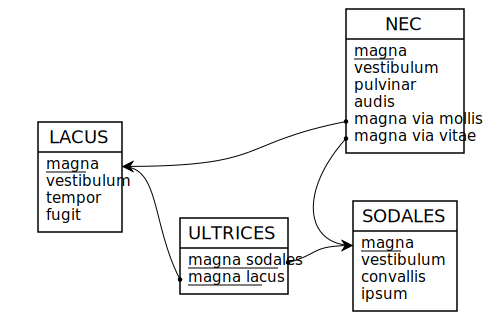

In [94]:
%mocodo --input sandbox.mld

### Suppression des tables indépendantes réduites à leur clé primaire

**Nouveauté de la version 3.1.** À partir de la version 2.3.5, les tables réduites à une clé primaire non composite étaient supprimées. Dans le diagramme relationnel, les éventuelles clés étrangères correspondantes perdaient leur caractère étranger.

Ce mécanisme est maintenant étendu :
- aux tables réduites à leur clé primaire, même composite, pourvu qu'aucun de ses composants ne soit clé étrangère ;
- à tous les formats de sortie : précédemment, la suppression de ces tables n'était effective que dans le diagramme relationnel ; dans les autres formats, elles étaient juste passées en commentaire, tandis que leur clé primaire, lorsqu'elle migrait dans une autre table, n'en était pas moins préfixée d'un dièse.

Ainsi, dans le MLD ci-dessous :
- la table DATE est supprimée (auparavant, elle était simplement masquée) ;
- la table POSITION est également supprimée (auparavant, elle était conservée) ;
- les clés des tables supprimées (_Date_, _Latitude_, _Longitude_) ne sont plus marquées comme étrangères dans ÉLÈVE ou ÉVALUER ;
- la table ENSEIGNER est toujours conservée : quoique réduite à sa clé primaire, les composants de celle-ci sont des clés étrangères.

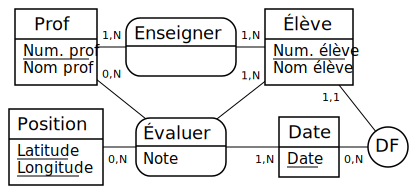

In [95]:
%%mocodo --mld --relations markdown_verbose
Prof: Num. prof, Nom prof
Enseigner, 1N Prof, 1N Élève
Élève: Num. élève, Nom élève

Position: Latitude, _Longitude
Évaluer, 1N Élève, 0N Prof, 0N Position, 1N Date: Note
Date: Date
DF, 11 Élève, 0N Date

Les sorties « verbeuses » en HTML et Markdown expliquent le traitement des champs concernés (ci-dessous, ÉLÈVE / Date, ÉVALUER / Latitude, Longitude et Date) et ajoutent une note de fin justifiant les suppressions (ci-dessous, NB).

In [97]:
display.Markdown("mocodo_notebook/sandbox_verbose.md")

**Enseigner** (<ins>_#Num. prof_</ins>, <ins>_#Num. élève_</ins>)  
- Le champ _Num. prof_ fait partie de la clé primaire de la table. C'est une clé étrangère qui a migré directement à partir de l'entité _Prof_.  
- Le champ _Num. élève_ fait partie de la clé primaire de la table. C'est une clé étrangère qui a migré directement à partir de l'entité _Élève_.  

**Prof** (<ins>Num. prof</ins>, Nom prof)  
- Le champ _Num. prof_ constitue la clé primaire de la table. C'était déjà un identifiant de l'entité _Prof_.  
- Le champ _Nom prof_ était déjà un simple attribut de l'entité _Prof_.  

**Élève** (<ins>Num. élève</ins>, Nom élève, _#Date_)  
- Le champ _Num. élève_ constitue la clé primaire de la table. C'était déjà un identifiant de l'entité _Élève_.  
- Le champ _Nom élève_ était déjà un simple attribut de l'entité _Élève_.  
- Le champ _Date_ a migré par l'association de dépendance fonctionnelle _DF_ à partir de l'entité _Date_ en perdant son caractère identifiant. De plus, comme la table créée à partir de cette entité a été supprimée, il n'est pas considéré comme clé étrangère.  

**Évaluer** (<ins>_#Num. élève_</ins>, <ins>_#Num. prof_</ins>, <ins>_#Latitude_</ins>, <ins>_#Longitude_</ins>, <ins>_#Date_</ins>, Note)  
- Le champ _Num. élève_ fait partie de la clé primaire de la table. C'est une clé étrangère qui a migré directement à partir de l'entité _Élève_.  
- Le champ _Num. prof_ fait partie de la clé primaire de la table. C'est une clé étrangère qui a migré directement à partir de l'entité _Prof_.  
- Les champs _Latitude_ et _Longitude_ font partie de la clé primaire de la table. Leur table d'origine (_Position_) ayant été supprimée, ils ne sont pas considérés comme clés étrangères.  
- Le champ _Date_ fait partie de la clé primaire de la table. Sa table d'origine (_Date_) ayant été supprimée, il n'est pas considéré comme clé étrangère.  
- Le champ _Note_ était déjà un simple attribut de l'association _Évaluer_.  

---

**NB.** Les tables _Date_ et _Position_ ont été supprimées car elles étaient réduites à la clé primaire de leur entité d'origine.

Ce mécanisme est également devenu débrayable. Si l'on souhaite conserver une table indépendante réduite à sa clé primaire, on préfixe du signe « + » l'entité correspondante (ci-dessous, POSITION). Pour les tables non supprimables, ce préfixe est simplement ignoré (ci-dessous, PROF).

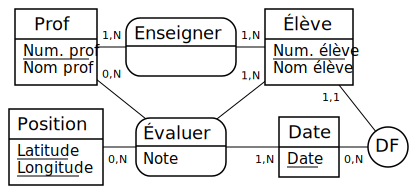

In [98]:
%%mocodo --mld
+Prof: Num. prof, Nom prof
Enseigner, 1N Prof, 1N Élève
Élève: Num. élève, Nom élève

+Position: Latitude, _Longitude
Évaluer, 1N Élève, 0N Prof, 0N Position, 1N Date: Note
Date: Date
DF, 11 Élève, 0N Date

Pour une discussion sur cette problématique, cf. [issue #66](https://github.com/laowantong/mocodo/issues/66).

### Traitement des idenfiants alternatifs

Rappelons que les identifiants alternatifs sont des sous-ensembles d'attributs minimaux assurant l'unicité de chacune de leur occurrence, mais non retenus comme identifiant principal.

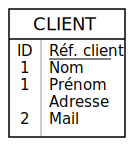

In [96]:
%%mocodo
CLIENT: Réf. client, 1_Nom, 1_Prénom, Adresse, 2_Mail

Au niveau logique (_i.e._, relationnel), cette contrainte d'unicité est suggérée visuellement par un exposant :

In [97]:
%%mocodo -c rel
CLIENT: Réf. client, 1_Nom, 1_Prénom, Adresse, 2_Mail

**CLIENT** (<ins>Réf. client</ins>, Nom<sup>u1</sup>, Prénom<sup>u1</sup>, Adresse, Mail<sup>u2</sup>)


Au niveau physique (_i.e._, SQL), par l'ajout de contraintes `UNIQUE` :

In [100]:
%%mocodo -c rel:postgresql rel:sqlite quiet
CLIENT: Réf. client, 1_Nom, 1_Prénom, Adresse, 2_Mail

Voici les deux dernières lignes du fichier Postgresql généré :

In [99]:
display.Code("\n".join(Path("mocodo_notebook/sandbox_postgresql.sql").read_text().splitlines()[-2:]), language="SQL")

ALTER TABLE CLIENT ADD CONSTRAINT client_u1 UNIQUE (nom, prénom);
ALTER TABLE CLIENT ADD CONSTRAINT client_u2 UNIQUE (mail);

Et l'[équivalent sous SQLite](https://stackoverflow.com/a/61506734/173003) :

In [88]:
display.Code("\n".join(Path("mocodo_notebook/sandbox_sqlite.sql").read_text().splitlines()[-2:]), language="SQL")

CREATE UNIQUE INDEX "client_u1" ON "CLIENT" ("nom", "prénom");
CREATE UNIQUE INDEX "client_u2" ON "CLIENT" ("mail");

Les identifiants alternatifs non disjoints sont également pris en charge :

In [92]:
%%mocodo --no_mcd -c rel
FOO: foo, 1_bar, 12_biz, 2_buz, 3_qux, 123_quux

**FOO** (<ins>foo</ins>, bar<sup>u1</sup>, biz<sup>u1 u2</sup>, buz<sup>u2</sup>, qux<sup>u3</sup>, quux<sup>u1 u2 u3</sup>)


In [93]:
display.Code("\n".join(Path("mocodo_notebook/sandbox_postgresql.sql").read_text().splitlines()[-3:]), language="SQL")

ALTER TABLE FOO ADD CONSTRAINT foo_u1 UNIQUE (bar, biz, quux);
ALTER TABLE FOO ADD CONSTRAINT foo_u2 UNIQUE (biz, buz, quux);
ALTER TABLE FOO ADD CONSTRAINT foo_u3 UNIQUE (qux, quux);

## Construction de représentations externes

La représentation interne peut être dérivée en représentation externe par l'application d'une spécification de format, ou **gabarit** (_template_ en anglais). Les schémas relationnels affichés au-dessous des diagrammes conceptuels dans la présente section sont un exemple de sortie au format HTML.

### Gabarits inclus dans la distribution

#### Formats linéaires

Dans sa représentation la plus compacte, un schéma relationnel s'écrit comme une suite de lignes de la forme:

    RELATION ( clé_primaire, attribut_1, attribut_2, ...)

Sauf mention contraire, les MLD affichés dans ce document ont été produits par Mocodo au format HTML. Pour un autre exemple, voici la génération et l'affichage d'une sortie $\mathrm\LaTeX$:

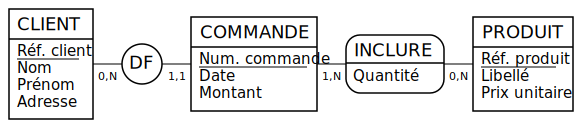

In [104]:
%%mocodo --relations latex
CLIENT: Réf. client, Nom, Prénom, Adresse
DF, 0N CLIENT, 11 COMMANDE
COMMANDE: Num. commande, Date, Montant
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantité
PRODUIT: Réf. produit, Libellé, Prix unitaire

In [105]:
display.Code("mocodo_notebook/sandbox.tex")

% Copy this before \begin{document}

\usepackage[normalem]{ulem}
\newenvironment{mld}
  {\par\begin{minipage}{\linewidth}\begin{tabular}{rp{0.7\linewidth}}}
  {\end{tabular}\end{minipage}\par}
\newcommand{\relat}[1]{\textsc{#1}}
\newcommand{\attr}[1]{\emph{#1}}
\newcommand{\prim}[1]{\uline{#1}}
\newcommand{\foreign}[1]{\#\textsl{#1}}

% Copy that after \begin{document}

\begin{mld}
  Client & (\prim{Réf. client}, \attr{Nom}, \attr{Prénom}, \attr{Adresse})\\
  Commande & (\prim{Num. commande}, \attr{Date}, \attr{Montant}, \foreign{Réf. client})\\
  Inclure & (\foreign{\prim{Num. commande}}, \foreign{\prim{Réf. produit}}, \attr{Quantité})\\
  Produit & (\prim{Réf. produit}, \attr{Libellé}, \attr{Prix unitaire})\\
\end{mld}

Les formats linéaires actuellement pris en charge par Mocodo sont les suivants:

| Nom | Argument | Usage du fichier généré |
|--|--|--|
| [HTML](http://fr.wikipedia.org/wiki/HTML) | html | À ouvrir directement avec un navigateur internet ou un programme de traitement de texte (dont Microsoft Word, OpenOffice, Apple Pages, etc.). Implicite dans un Notebook. |
| [$\mathrm\LaTeX$](http://fr.wikipedia.org/wiki/LaTeX) | latex | À compiler sous $\mathrm\LaTeX$ pour une sortie de haute qualité aux formats PDF ou PostScript. |
| [Markdown](http://fr.wikipedia.org/wiki/Markdown) | markdown |  À coller dans une cellule de Notebook, dans un champ textuel de GitHub ou Stack Overflow, ou à ouvrir avec l'un des nombreux éditeurs Markdown existants. |
| [Texte brut](http://fr.wikipedia.org/wiki/Fichier_texte) | text | À ouvrir directement avec un éditeur de texte Unicode. |

#### Formats linéaires avec explications

Deux de ces formats, HTML et Markdown, disposent d'une version augmentée d'explications détaillées du mécanisme du passage au relationnel. Ce type de sortie, adaptable par l'enseignant, peut être utile aux étudiants qui souhaitent réviser ou travailler en autonomie.

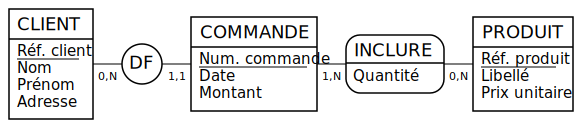

In [106]:
%%mocodo --relations markdown_verbose
CLIENT: Réf. client, Nom, Prénom, Adresse
DF, 0N CLIENT, 11 COMMANDE
COMMANDE: Num. commande, Date, Montant
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantité
PRODUIT: Réf. produit, Libellé, Prix unitaire

In [107]:
display.Markdown("mocodo_notebook/sandbox_verbose.md")

**CLIENT** (<ins>Réf. client</ins>, Nom, Prénom, Adresse)  
- Le champ _Réf. client_ constitue la clé primaire de la table. C'était déjà un identifiant de l'entité _CLIENT_.  
- Les champs _Nom_, _Prénom_ et _Adresse_ étaient déjà de simples attributs de l'entité _CLIENT_.  

**COMMANDE** (<ins>Num. commande</ins>, Date, Montant, _#Réf. client_)  
- Le champ _Num. commande_ constitue la clé primaire de la table. C'était déjà un identifiant de l'entité _COMMANDE_.  
- Les champs _Date_ et _Montant_ étaient déjà de simples attributs de l'entité _COMMANDE_.  
- Le champ _Réf. client_ est une clé étrangère. Il a migré par l'association de dépendance fonctionnelle _DF_ à partir de l'entité _CLIENT_ en perdant son caractère identifiant.  

**INCLURE** (<ins>_#Num. commande_</ins>, <ins>_#Réf. produit_</ins>, Quantité)  
- Le champ _Num. commande_ fait partie de la clé primaire de la table. C'est une clé étrangère qui a migré directement à partir de l'entité _COMMANDE_.  
- Le champ _Réf. produit_ fait partie de la clé primaire de la table. C'est une clé étrangère qui a migré directement à partir de l'entité _PRODUIT_.  
- Le champ _Quantité_ était déjà un simple attribut de l'association _INCLURE_.  

**PRODUIT** (<ins>Réf. produit</ins>, Libellé, Prix unitaire)  
- Le champ _Réf. produit_ constitue la clé primaire de la table. C'était déjà un identifiant de l'entité _PRODUIT_.  
- Les champs _Libellé_ et _Prix unitaire_ étaient déjà de simples attributs de l'entité _PRODUIT_.

Tout ce texte est généré automatiquement, mais avec des raffinements destinés à le rendre plus lisible pour un humain. Par exemple, les trois attributs non identifiants de l'entité CLIENT sont décrits en une seule ligne au lieu de trois.

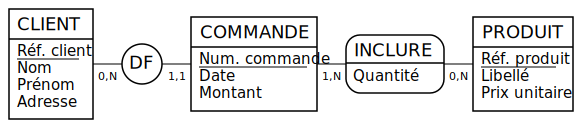

In [108]:
%%mocodo --relations html_verbose
CLIENT: Réf. client, Nom, Prénom, Adresse
DF, 0N CLIENT, 11 COMMANDE
COMMANDE: Num. commande, Date, Montant
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantité
PRODUIT: Réf. produit, Libellé, Prix unitaire

In [109]:
display.HTML("mocodo_notebook/sandbox_verbose.html")

**Nouveautés de la version 3.**
- Dans la version HTML du schéma relationnel expliqué, les explications sont maintenant divulguées à la demande (balise `<details>`). Cliquez sur CLIENT pour afficher l'explication.
- À des fins de débogage, le survol d'un champ affiche son type interne à Mocodo et, éventuellement, sa table d'origine. Par exemple, survoler #_Réf. client_ affiche `foreign_key (CLIENT)`.

#### Diagramme relationnel

La plupart des SGBD offrent une représentation hybride (graphique / texte) de la base, sous la forme d'un ensemble de tables rectangulaires liées par des flèches. Mocodo génère un fichier d'extension `.mld` qu'il est capable de reprendre en entrée pour tracer ce type de graphe.

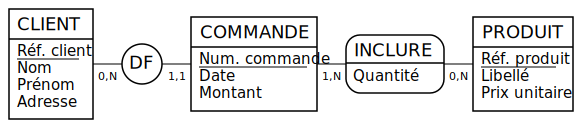

In [110]:
%%mocodo --mld --relations diagram
CLIENT: Réf. client, Nom, Prénom, Adresse
DF, 0N CLIENT, 11 COMMANDE
COMMANDE: Num. commande, Date, Montant
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantité
PRODUIT: Réf. produit, Libellé, Prix unitaire

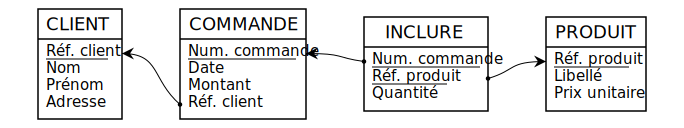

In [111]:
%mocodo --input sandbox.mld

In [112]:
display.Code("mocodo_notebook/sandbox.mld", language="text")

%%mocodo
:
CLIENT: Réf. client, Nom, Prénom, Adresse
:
COMMANDE: Num. commande, Date, Montant, #Réf. client > CLIENT > Réf. client
:
INCLURE: #Num. commande > COMMANDE > Num. commande, _#Réf. produit > PRODUIT > Réf. produit, Quantité
:
PRODUIT: Réf. produit, Libellé, Prix unitaire
:

Si l'on ouvre le fichier généré (_cf._ ci-dessus), on constate que la syntaxe d'un MLD est la même que celle d'un MCD, à ceci près que les associations sont remplacées par des liens allant de l'attribut `a1` de l'entité `E1` à l'attribut `a2` de l'entité `E2`, et qui se notent: `E1: ... a1 > E2 > a2` (nouveauté de la version 4.0 : les versions précédentes notaient `E1: ... a1->E2->a2`).

Les boîtes invisibles automatiquement insérées une colonne sur deux aèrent le résultat de façon à laisser de la place aux flèches.

Remarquons que cette opération est [idempotente](https://fr.wikipedia.org/wiki/Idempotence) pour le MLD :

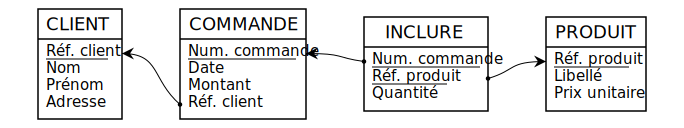

In [113]:
%%mocodo --mld --relations diagram
:
CLIENT: Réf. client, Nom, Prénom, Adresse
:
COMMANDE: Num. commande, Date, Montant, #Réf. client > CLIENT > Réf. client
:
INCLURE: #Num. commande > COMMANDE > Num. commande, _#Réf. produit > PRODUIT > Réf. produit, Quantité
:
PRODUIT: Réf. produit, Libellé, Prix unitaire
:

Mais cette fois, comme le « MCD » d'entrée ne comporte aucune association, le diagramme relationnel généré ne comporte aucune flèche.

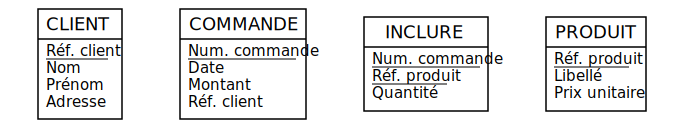

In [114]:
%mocodo --input sandbox.mld

In [115]:
display.Code("mocodo_notebook/sandbox.mld", language="text")

%%mocodo
:
CLIENT: Réf. client, Nom, Prénom, Adresse
:
COMMANDE: Num. commande, Date, Montant, Réf. client
:
INCLURE: Num. commande, _Réf. produit, Quantité
:
PRODUIT: Réf. produit, Libellé, Prix unitaire
:

Le reprendre comme texte d'entrée produit donc le même diagramme, mais sans les flèches. Leur rétablissement pourrait faire l'objet d'un exercice facile.

Sous _Mocodo online_, vous obtiendrez le premier diagramme relationnel en trois étapes:

1. générez les relations correspondant au MCD de départ (vous aurez coché « diagramme relationnel » dans le menu « Options »);
2. copiez-collez la sortie « diagramme relationnel » à la place du texte d'entrée;
3. regénérez les relations.

Les relations sont placées dans le même ordre que les boîtes du MCD d'origine, mais vous devrez souvent les réorganiser (automatiquement ou manuellement) pour obtenir un résultat plus esthétique.

Le diagramme relationnel sans flèches s'obtient en répétant les étapes 2 et 3.

Les versions successives des différents fichiers étant écrasées à chaque regénération, veillez à télécharger l'archive après chaque étape si vous souhaitez garder l'ensemble.

**Limitation.** Les clés étrangères composites sont actuellement représentées comme si elles étaient séparées (autant de flèches que de parties).

#### Sorties SQL

Mocodo est livré avec des fichiers de spécification pour les dialectes SQL suivants:

| SGBD | Argument | Suffixe et extension |
|:--|:--|--:|
| [MySQL](https://www.mysql.fr) | `-c rel:mysql` | `"_mysql.sql"` |
| [Oracle](http://oracle.com) | `-c rel:oracle` | `"_oracle.sql"` |
| [PostgreSQL](http://postgresql.org) | `-c rel:postgresql` | `"_postgresql.sql"` |
| [SQLite](http://sqlite.org) | `-c rel:sqlite` | `"_sqlite.sql"` |

Notez que les contraintes de clés étrangères sont ajoutées **après** création de l'ensemble des tables, sauf pour SQLite, qui n'impose pas d'ordre de création spécifique, et qui de toute façon ne prend pas en charge ce type d'altération _a posteriori_.

Le type de données peut être inséré entre crochets droits après chaque attribut:

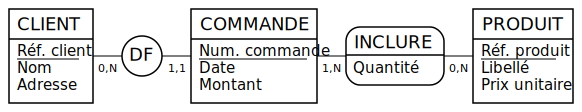

In [116]:
%%mocodo --title=client_commande_produit --relations mysql
CLIENT: Réf. client [varchar(8)], Nom [varchar(20)], Adresse [varchar(40)]
DF, 0N CLIENT, 11 COMMANDE
COMMANDE: Num. commande [tinyint(4)], Date [date], Montant [decimal(5,2) DEFAULT '0.00']
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantité [tinyint(4)]
PRODUIT: Réf. produit [varchar(8)], Libellé [varchar(20)], Prix unitaire [decimal(5,2)]

Quoique ces informations supplémentaires ne soient pas apparues dans le diagramme conceptuel, elles ont été exploitées par la commande, qui a produit dans le répertoire `mocodo_notebook` un fichier directement exécutable par MySQL:

In [117]:
display.Code(filename="mocodo_notebook/sandbox_mysql.sql", language="mysql")

CREATE DATABASE IF NOT EXISTS `CLIENT_COMMANDE_PRODUIT`;
USE `CLIENT_COMMANDE_PRODUIT`;

CREATE TABLE `CLIENT` (
  `réf_client` varchar(8),
  `nom` varchar(20),
  `adresse` varchar(40),
  PRIMARY KEY (`réf_client`)
) ENGINE=InnoDB DEFAULT CHARSET=UTF8MB4;

CREATE TABLE `COMMANDE` (
  `num_commande` tinyint(4),
  `date` date,
  `montant` decimal(5,2) DEFAULT '0.00',
  `réf_client` varchar(8),
  PRIMARY KEY (`num_commande`)
) ENGINE=InnoDB DEFAULT CHARSET=UTF8MB4;

CREATE TABLE `INCLURE` (
  `num_commande` tinyint(4),
  `réf_produit` varchar(8),
  `quantité` tinyint(4),
  PRIMARY KEY (`num_commande`, `réf_produit`)
) ENGINE=InnoDB DEFAULT CHARSET=UTF8MB4;

CREATE TABLE `PRODUIT` (
  `réf_produit` varchar(8),
  `libellé` varchar(20),
  `prix_unitaire` decimal(5,2),
  PRIMARY KEY (`réf_produit`)
) ENGINE=InnoDB DEFAULT CHARSET=UTF8MB4;

ALTER TABLE `COMMANDE` ADD FOREIGN KEY (`réf_client`) REFERENCES `CLIENT` (`réf_client`);
ALTER TABLE `INCLURE` ADD FOREIGN KEY (`réf_produit`) REFERENCES `PRODUIT` (`réf_produit`);
ALTER TABLE `INCLURE` ADD FOREIGN KEY (`num_commande`) REFERENCES `COMMANDE` (`num_commande`);

**Nouveauté de la version 2.0.17.** Les clés étrangères composites sont gérées (cf. [issue 14](https://github.com/laowantong/mocodo/issues/14)) et les types manquants remplacés par `VARCHAR(`[`42`](https://fr.wikipedia.org/wiki/La_grande_question_sur_la_vie,_l%27univers_et_le_reste)):

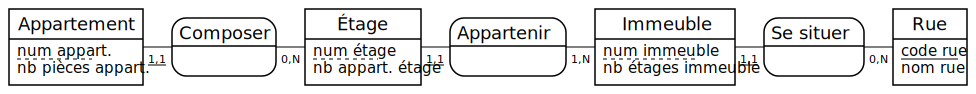

In [118]:
%%mocodo --title=appartements --relations sqlite
Appartement: num appart., nb pièces appart.
Composer, 0N Étage, _11 Appartement
Étage: num étage, nb appart. étage
Appartenir, 1N Immeuble, _11 Étage
Immeuble: num immeuble, nb étages immeuble
Se situer, 0N Rue, _11 Immeuble
Rue: code rue, nom rue

In [119]:
display.Code("mocodo_notebook/sandbox_sqlite.sql")

.open "APPARTEMENTS";

CREATE TABLE "APPARTEMENT" (
  "code_rue" VARCHAR(42),
  "num_immeuble" VARCHAR(42),
  "num_étage" VARCHAR(42),
  "num_appart" VARCHAR(42),
  "nb_pièces_appart" VARCHAR(42),
  PRIMARY KEY ("code_rue", "num_immeuble", "num_étage", "num_appart"),
  FOREIGN KEY ("code_rue", "num_immeuble", "num_étage") REFERENCES "ÉTAGE" ("code_rue", "num_immeuble", "num_étage")
);

CREATE TABLE "IMMEUBLE" (
  "code_rue" VARCHAR(42),
  "num_immeuble" VARCHAR(42),
  "nb_étages_immeuble" VARCHAR(42),
  PRIMARY KEY ("code_rue", "num_immeuble"),
  FOREIGN KEY ("code_rue") REFERENCES "RUE" ("code_rue")
);

CREATE TABLE "RUE" (
  "code_rue" VARCHAR(42),
  "nom_rue" VARCHAR(42),
  PRIMARY KEY ("code_rue")
);

CREATE TABLE "ÉTAGE" (
  "code_rue" VARCHAR(42),
  "num_immeuble" VARCHAR(42),
  "num_étage" VARCHAR(42),
  "nb_appart_étage" VARCHAR(42),
  PRIMARY KEY ("code_rue", "num_immeuble", "num_étage"),
  FOREIGN KEY ("code_rue", "num_immeuble") REFERENCES "IMMEUBLE" ("code_rue", "num_immeuble")
);

#### Graphe des dépendances

**Nouveauté de la version 3.1.** On dit que la table A **dépend** de la table B lorsque A possède une clé étrangère qui est clé primaire de B. Mocodo peut désormais générer un graphe des dépendances au format Graphviz. Considérons par exemple le MCD suivant :

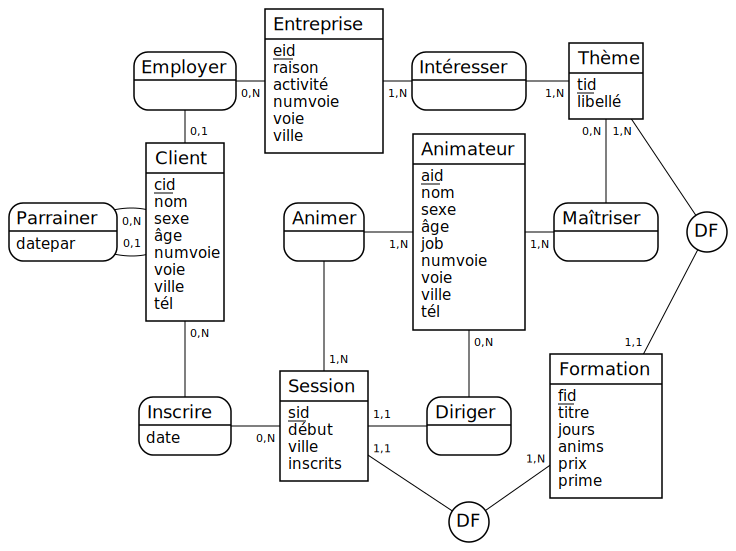

In [422]:
%%mocodo
:
Employer, 01 Client, 0N Entreprise
Entreprise: eid, raison, activité, numvoie, voie, ville
Intéresser, 1N Entreprise, 1N Thème
Thème: tid, libellé
:
    
Parrainer, 01 Client, 0N Client: datepar
Client: cid, nom, sexe, âge, numvoie, voie, ville, tél
Animer, 1N Session, 1N Animateur
Animateur: aid, nom, sexe, âge, job, numvoie, voie, ville, tél
Maîtriser, 1N Animateur, 0N Thème
DF, 11 Formation, 1N Thème

:
Inscrire, 0N Client, 0N Session: date
Session: sid, début, ville, inscrits
Diriger, 11 Session, 0N Animateur
Formation: fid, titre, jours, anims, prix, prime
:

:::
DF, 11 Session, 1N Formation
::

Supposons que l'on doive importer la base de données correspondante à partir d'un ensemble de fichiers CSV (ou autres). Si l'on veut éviter de désactiver tous les contrôles de clés étrangères (en faisant, p. ex. sous MySQL, `SET FOREIGN_KEY_CHECKS = 0`), il conviendra de lire ces fichiers dans un [ordre topologique](https://fr.wikipedia.org/wiki/Tri_topologique) quelconque. Mocodo peut générer un graphe des dépendances qui met cet ordre en évidence :

In [423]:
%mocodo --input sandbox -c rel:dependencies defer:svg --no_mcd

Même si notre graphe des dépendances n'est pas forcément un  [graphes sans circuits](https://fr.wikipedia.org/wiki/Graphe_orienté_acyclique) (ici, p. ex., il y a une boucle de CLIENT à CLIENT), remplir les tables de gauche à droite et de haut en bas (Thème, Entreprise, Animateur, Formation, etc.) minimisera le recours à la désactivation des contraintes de clés étrangères.

### Modification ou création de nouveaux gabarits

L'algorithme de génération d'une sortie dans tel ou tel format est totalement découplé de son entrée. Cela signifie que vous pouvez modifier ou créer un format sans écrire une seule ligne de code, mais en remplissant une espèce de formulaire, ou gabarit, qui est un simple fichier JSON. Si vous n'avez aucune velléité de le faire, vous pouvez sauter cette section. Sinon, accrochez-vous, ça va devenir un peu technique.

#### Algorithme

Pour apprendre à spécifier un format, le mieux est d'étudier les gabarits livrés dans le dossier `relation_templates`. Les quelques indications données ici devraient suffire à vous épargner la lecture du code proprement dit.

Chaque gabarit est un fichier JSON associant des clés prédéfinies à des valeurs librement modifiables. Dans sa forme la plus simple, à savoir le format « texte brut », le fichier (`text.json`) se réduit à trois lignes:

```json
{
  "extension": ".txt"
}
```

La clé `"extension"` est en effet la seule clé obligatoire d'un tel fichier. Ici, elle est associée à la valeur `".txt"`.

Les autres clés possibles, toutes facultatives, appartiennent à quatre catégories:

| Catégorie | Forme de la clé | Valeur associée | Description |
|--|--|--|--|
| Transformation | `"transform_..."` | objet | Opère une recherche-remplacement, éventuellement itérée (jusqu'à ce qu'aucun remplacement ne soit plus possible), sur une partie du texte déjà généré. Les champs `"search"` et `"replace`" sont obligatoires, le champ `"iterated"` (booléen) est facultatif. La syntaxe est celle des [expressions régulières de Python](https://docs.python.org/3/library/re.html#regular-expression-syntax). |
| Composition | `"compose_..."` | chaîne de format | Interpole dans une chaîne certains identificateurs prédéfinis par une valeur dépendant du contexte en cours. La syntaxe est celle utilisée par la [méthode `.format()` de Python](https://docs.python.org/3/library/string.html#format-string-syntax). |
| Concaténation | `"..._separator"` | chaîne | Concatène une liste de chaînes en les séparant par une chaîne donnée. |
| clé de tri | `"..._sorting_key"` | objet | Extrait la clé de tri pour la liste concernée. L'expression régulière `"search"` contient une ou des parenthèses capturantes qui sont ensuite rappelées dans l'expression `"replace"` |

Voici les différentes opérations effectuées par l'algorithme, dans l'ordre de son déroulement:

1. Toutes les clés absentes du gabarit sont ajoutées, avec des valeurs par défaut pertinentes.
2. `"transform_attribute"` applique une première transformation à chaque attribut (identificateur `attribute`). Il s'agit en général de supprimer ou remplacer les caractères interdits par le format-cible. Le résultat est référencé par un nouvel identificateur, appelé `"raw_label"`.
3. Différentes capitalisations de ce libellé sont ajoutées sous les noms de `"raw_label_lowercase"` (minuscules),  `"raw_label_uppercase"` (majuscules) et  `"raw_label_titlecase"` (majuscules initiales).
4. `"compose_label_disambiguated_by_note"` crée sous le nom de `"label"` une copie de `"raw_label"`, en introduisant en plus dans les clés étrangères les notes des pattes correspondantes. La valeur par défaut est `"{raw_label} {leg_note}"`, mais pour plus de liberté on peut très bien imaginer de remplacer le label par l'note elle-même (avec `"{leg_note}"`). Cette composition est optionnelle: pour la désactiver, passer l'option `disambiguation=numbers_only`.
4. <a id='disambiguation_by_number'></a>`"compose_label_disambiguated_by_number"` différencie les libellés homonymes d'une même relation en leur ajoutant un numéro. Par exemple, et c'est la valeur par défaut, pour suffixer le libellé par un point suivi de ce numéro, on écrira: `"{label}.{disambiguation_number}"`. L'identificateur `"label"` est mis à jour avec le résultat. C'est lui que l'utilisateur utilisera en général dans la suite de l'algorithme, mais il a encore accès aux variantes précédentes.
5. Différentes capitalisations de ce libellé sont ajoutées: `"label_lowercase"`, `"label_uppercase"` et  `"label_titlecase"`.
6. `"transform_title"` reçoit le nom du MCD. Le résultat et ses capitalisations sont associés aux identificateurs `"title"`, `"title_lowercase"`, `"title_uppercase"` et  `"title_titlecase"`.
7. Ensuite, pour chacune des relations créées dans la représentation interne:

  1. `"transform_relation_name"` applique une transformation au nom de la relation et l'associe, avec ses capitalisations, aux identificateurs `"this_relation_name"`, `"this_relation_name_lowercase"`, `"this_relation_name_uppercase"` et  `"this_relation_name_titlecase"`.
  2. Le numéro d'ordre de la relation est associé à l'identificateur `"this_relation_number"`.
  3. Pour chaque colonne de la relation en cours:

    1. Si l'attribut a migré depuis une entité, le nom de la relation correspondante est associé, avec ses capitalisations, aux identificateurs `"primary_relation_name"`, `"primary_relation_name_lowercase"`, `"primary_relation_name_uppercase"` et  `"primary_relation_name_titlecase"`. Dans le cas contraire, tous ces identificateurs sont associés à la chaîne vide.
    2. Si l'attribut a migré par une association, le nom de celle-ci est associé, avec ses capitalisations, aux identificateurs `"association_name"`, `"association_name_lowercase"`, `"association_name_uppercase"` et  `"association_name_titlecase"`. Dans le cas contraire, tous ces identificateurs sont associés à la chaîne vide.
    3. la composition `"compose_[attribute_nature]"` est appliquée, _cf._ le paragraphe [Composition des attributs selon leur nature](#Composition-des-attributs-selon-leur-nature). Le résultat est accumulé dans une liste de colonnes, en deux versions: dans l'ordre de leur énumération, ou triée selon la clé spécifiée dans `"column_sorting_key"`.
  4. `"column_separator"` joint chacune de ces listes de chaînes et associe le résultat à l'identificateur `"columns"` et `"sorted_columns"` (respectivement).
  5. `"compose_relation"` construit une relation complète avec tous ses attributs. Par exemple, et c'est la valeur par défaut, `"{this_relation_name} ({columns})"` est utilisé dans les [formats linéaires](#Formats-lin%C3%A9aires).
  6. `"transform_forced_relation"` est appliqué aux associations DF dont la conversion en table a été forcée manuellement.
  7. `"transform_relation"` est appliqué systématiquement, et le résultat est accumulé dans une liste de relations, en deux versions: dans l'ordre de leur énumération, ou triée selon la clé spécifiée dans `"relation_sorting_key"`.
8. `"relation_separator"` joint chacune de ces listes de chaînes et associe le résultat à l'identificateur `"relations"` et `"sorted_relations"` (respectivement).
9. `"compose_relational_schema"` construit un schéma relationnel complet avec son titre et toutes ses relations. La valeur par défaut est simplement `"{relations}"`.
10. `"transform_relational_schema"` applique une dernière transformation au schéma complet, et renvoie le résultat final.

#### Identificateurs disponibles pour la composition de chaînes

Mocodo _offline_ est livré avec un gabarit spécialement conçu pour vous aider à en créer de nouveaux. Il vous permet de tester sur n'importe quel MCD la génération d'un objet JSON contenant la valeur de tous les identificateurs disponibles pour la composition au niveau de chaque attribut.

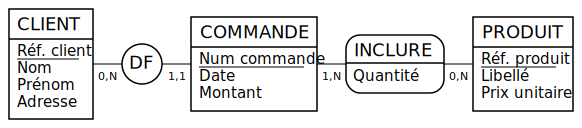

In [153]:
%%mocodo --title client_commande_produit --relations json
CLIENT: Réf. client, Nom, Prénom, Adresse
DF, 0N CLIENT, 11 COMMANDE
COMMANDE: Num. commande, Date, Montant
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantité
PRODUIT: Réf. produit, Libellé, Prix unitaire

Le contexte d'un attribut donne accès à 32 identificateurs:

- 4 spécifiques à la base;
- 5 spécifiques à la relation;
- 23 spécifiques à l'attribut.

S'y ajoutent `"columns"`, `"sorted_columns"`, et `"relations"`, `"sorted_relations"`, qui n'ont de sens que dans le contexte de `"compose_relation"` et `"compose_relational_schema"`(respectivement).

Le fichier JSON est trop long pour être listé dans son intégralité ici, mais en voici le début, qui concerne la clé primaire _Réf. client_ de la relation _Client_ de la base _client_commande_produit_.

In [154]:
display.Code("mocodo_notebook/sandbox.json")

{
  "title": "client_commande_produit",
  "title_lowercase": "client_commande_produit",
  "title_uppercase": "CLIENT_COMMANDE_PRODUIT",
  "title_titlecase": "Client_commande_produit",
  "relations": [
    {
      "this_relation_name": "CLIENT",
      "this_relation_name_lowercase": "client",
      "this_relation_name_uppercase": "CLIENT",
      "this_relation_name_titlecase": "Client",
      "is_forced": "False",
      "columns": [
        {
          "attribute": "Réf. client",
          "raw_label": "Réf. client",
          "raw_label_lowercase": "réf. client",
          "raw_label_uppercase": "RÉF. CLIENT",
          "raw_label_titlecase": "Réf. client",
          "disambiguation_number": null,
          "label": "Réf. client",
          "label_lowercase": "réf. client",
          "label_uppercase": "RÉF. CLIENT",
          "label_titlecase": "Réf. client",
          "primary": true,
          "nature": "primary_key",
          "data_type": null,
          "association_name": null,
          "association_name_lower_case": null,
          "association_name_uppercase": null,
          "association_name_titlecase": null,
          "leg_note": null,
          "outer_source": null,
          "outer_source_lowercase": null,
          "outer_source_uppercase": null,
          "outer_source_titlecase": null
        },
        {
          "attribute": "Nom",
          "raw_label": "Nom",
          "raw_label_lowercase": "nom",
          "raw_label_uppercase": "NOM",
          "raw_label_titlecase": "Nom",
          "disambiguation_number": null,
          "label": "Nom",
          "label_lowercase": "nom",
          "label_uppercase": "NOM",
          "label_titlecase": "Nom",
          "primary": false,
          "nature": "normal_attribute",
          "data_type": null,
          "association_name": null,
          "association_name_lower_case": null,
          "association_name_uppercase": null,
          "association_name_titlecase": null,
          "leg_note": null,
          "outer_source": null,
          "outer_source_lowercase": null,
          "outer_source_uppercase": null,
          "outer_source_titlecase": null
        },
        {
          "attribute": "Prénom",
          "raw_label": "Prénom",
          "raw_label_lowercase": "prénom",
          "raw_label_uppercase": "PRÉNOM",
          "raw_label_titlecase": "Prénom",
          "disambiguation_number": null,
          "label": "Prénom",
          "label_lowercase": "prénom",
          "label_uppercase": "PRÉNOM",
          "label_titlecase": "Prénom",
          "primary": false,
          "nature": "normal_attribute",
          "data_type": null,
          "association_name": null,
          "association_name_lower_case": null,
          "association_name_uppercase": null,
          "association_name_titlecase": null,
          "leg_note": null,
          "outer_source": null,
          "outer_source_lowercase": null,
          "outer_source_uppercase": null,
          "outer_source_titlecase": null
        },
        {
          "attribute": "Adresse",
          "raw_label": "Adresse",
          "raw_label_lowercase": "adresse",
          "raw_label_uppercase": "ADRESSE",
          "raw_label_titlecase": "Adresse",
          "disambiguation_number": null,
          "label": "Adresse",
          "label_lowercase": "adresse",
          "label_uppercase": "ADRESSE",
          "label_titlecase": "Adresse",
          "primary": false,
          "nature": "normal_attribute",
          "data_type": null,
          "association_name": null,
          "association_name_lower_case": null,
          "association_name_uppercase": null,
          "association_name_titlecase": null,
          "leg_note": null,
          "outer_source": null,
          "outer_source_lowercase": null,
          "outer_source_uppercase": null,
          "outer_source_titlecase": null
        }
      ]
    },
    {
      "this_relation_name": "COMMANDE",
      "this_relation_name_lowercase": "comm

Ce fragment est à première vue très redondant. En cas de doute, reportez-vous aux tests `relations_tests.py` dans le code-source pour un éventail de cas discriminants.

#### Composition des attributs selon leur nature

**Avertissement.** Cette section décrit la version 2 et n'a pas été complétée pour Mocodo 3.

La composition appliquée à un attribut est au cœur de la construction d'une représentation externe. À cette étape, la représentation interne a permis de distinguer 9 catégories d'attributs, 6 courantes et 3 exceptionnelles. Avant de pouvoir exploiter cette classification, il faut la comprendre en détail. Nous allons la présenter à travers deux exemples, le premier répertoriant tous les cas courants, le second tous les cas exceptionnels.

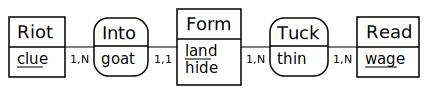

In [155]:
%%mocodo --relations html_verbose
Riot: clue
Into, 11 Form, 1N Riot: goat
Form: land, hide
Tuck, 1N Read, 1N Form: thin
Read: wage

In [156]:
display.HTML("mocodo_notebook/sandbox_verbose.html")

| Identificateur | Attribut concerné | Défaut | Exemple | 
|--|--|--|--|
| `compose_primary_key` | identifiant resté sur place lors de la transformation d'une entité en table | `"_{label}_"` | _land_ de **Form** |
| `compose_normal_attribute` | simple attribut resté sur place lors de la transformation d'une entité en table | `"{label}"` | _hide_ de **Form** |
| `compose_foreign_key` | clé étrangère ayant migré par une dépendance fonctionnelle disparue, tout en perdant son caractère identifiant | `"#{label}"` | _clue_ de **Form** |
| `compose_foreign_attribute` | attribut étranger ayant migré d'une dépendance fonctionnelle disparue | même valeur que `compose_normal_attribute` | _goat_ de **Form** |
| `compose_foreign_primary_key` | clé étrangère primaire migré dans une association devenue table, tout en gardant son caractère identifiant  | `"_#{label}_"` | _wage_ et _land_ de **Tuck** |
| `compose_association_attribute` | simple attribut resté sur place lors de la transformation d'une association en table | même valeur que `compose_normal_attribute` | _thin_ de **Tuck** |

In [105]:
%%mocodo -c rel:html_verbose
Riot: clue
Walk, 1N Riot, _11 Hour
Hour: book
Poll, 1N Cast, /1N Hour
Cast: mere
+Army, 11 Busy, 01 Cast
Busy: fail

In [158]:
display.HTML("mocodo_notebook/sandbox_verbose.html")

| Identificateur | Attribut concerné | Défaut | Exemple | 
|----------------|-------------------|--------|---------|
| `compose_strengthening_primary_key` | clé primaire de renforcement d'une entité faible | même valeur que `compose_foreign_primary_key` | _clue_ de **Hour** |
| `compose_demoted_foreign_key` | clé étrangère ayant migré dans une association devenue table, mais rétrogradée explicitement au rang de simple attribut | même valeur que `compose_foreign_key` | _book_ et _clue_ de **Poll** |
| `compose_primary_foreign_key` | clé étrangère non primaire ayant migré dans une dépendance fonctionnelle explicitement promue au rang de table |  | _fail_ et _mere_ de **Army** |

#### Gabarit vide

Voici pour référence un gabarit JSON prêt à l'emploi, à partir duquel vous pourrez créer les vôtres. Il comporte l'intégralité des identificateurs disponibles, avec leur valeur par défaut et dans l'ordre de déroulement de l'algorithme:

```
{
    "extension": "requis: pas de valeur par défaut",
    "transform_attribute": [],
    "transform_title": [],
    "transform_data_type": [],
    "compose_label_disambiguated_by_note": "{raw_label} {leg_note}",
    "compose_label_disambiguated_by_number": "{label}.{disambiguation_number}",
    "compose_primary_key": "_{label}_",
    "compose_normal_attribute": "{label}",
    "compose_foreign_key": "#{label}",
    "compose_foreign_attribute": "par défaut, même valeur que compose_normal_attribute",
    "compose_foreign_primary_key": "_#{label}_",
    "compose_association_attribute": "par défaut, même valeur que compose_normal_attribute",
    "compose_strengthening_primary_key": "par défaut, même valeur que compose_foreign_primary_key",
    "compose_demoted_foreign_key": "par défaut, même valeur que compose_foreign_key",
    "compose_promoting_foreign_key": "par défaut, même valeur que compose_foreign_key",
    "transform_relation_name": [],
    "column_sorting_key": {
        "search": "(.+)",
        "replace": "\\1"
    },
    "column_separator": ", ",
    "compose_relation": "{this_relation_name} ({columns})",
    "transform_forced_relation": [],
    "transform_relation": [],
    "relation_sorting_key": {
        "search": "(.+)",
        "replace": "\\1"
    },
    "relation_separator": "\n",
    "compose_relational_schema": "{relations}",
    "transform_relational_schema": []
}
```

#### Dérivation de gabarits

**Nouveauté de la version 3.1.** Il est maintenant possible de définir un gabarit dérivé d'un autre (qui lui-même peut dériver d'un autre, etc.). La distribution inclut, à titre d'exemple, le gabarit dérivé de `latex.json` suivant :

In [81]:
path = Path("../mocodo/resources/relation_templates/latex_barebones.json")
display.Markdown(f"```json\n{path.read_text()}\n```")

```json
{
    "parent": "latex",
    "compose_relational_schema": "\\begin{{mld}}\n{relations}\n\\end{{mld}}"
}

```

- La clé `"parent"` donne le chemin ou le nom du gabarit dont on souhaite créer une version dérivée :
    - une chaîne terminée par `.json` est interprétée comme un chemin ;
    - sinon, comme le nom d'un gabarit de la distribution.
- Les autres clés sont facultatives. Ici, on redéfinit simplement le `"compose_relational_schema"` de `latex.json`.

Le mécanisme de dérivation dépend de la scalarité de la valeur associée aux clés.

**Cas scalaire.**

Pour les valeurs scalaires (chaînes, nombres, booléens, `null`), selon la présence d'une entrée donnée dans le gabarit enfant et/ou le gabarit parent, l'association clé-valeur correspondante sera créée, mise à jour ou conservée :

| enfant | parent | résultat     |
|--------|--------|--------------|
| oui    | non    | création     |
| oui    | oui    | mise à jour  |
| non    | oui    | conservation |

Il n'y a pas de moyen de supprimer une association clé-valeur, mais étant donné que toutes celles qui sont absentes se voient substituer une association par défaut, il est équivalent de spécifier explicitement la valeur-défaut.

**Cas non scalaire.**

Dans les gabarits de relations de Mocodo, une seule catégorie de valeur non scalaire est possible : la liste de dictionnaires. En voici un exemple extrait du gabarit `html.json` :

```json
  "transform_attribute": [
    {
      "order": 100,
      "search": "&",
      "replace": "&amp;"
    },
    {
      "order": 200,
      "search": ">",
      "replace": "&gt;"
    },
    {
      "order": 300,
      "search": "<",
      "replace": "&lt;"
    }
  ],
```

Dans la version 3.1, une clé `"order"` incrémentée par pas de 100 a été ajoutée systématiquement à chacun des dictionnaires de la liste. Selon la présence d'un dictionnaire de numéro d'ordre donné dans le gabarit enfant et/ou le gabarit parent, ce dictionnaire sera inséré, supprimé, mis à jour ou conservé :

| enfant | parent | résultat     |
|--------|--------|--------------|
| oui    | non    | insertion    |
| oui    | oui    | s'il y a une seule clé : suppression<br> s'il y a plusieurs clés : [mise à jour](https://docs.python.org/3/library/stdtypes.html#dict.update) |
| non    | oui    | conservation |

**Remarque.** Le pas de 100 a été choisi de façon à permettre à l'utilisateur d'insérer un nombre suffisant de dictionnaires entre deux dictionnaires existants, tout en apportant un certain nombre de garanties. Ainsi, si l'un des gabarits de la distribution devait changer lors d'une mise à jour de Mocodo :

- les dictionnaires préservés ou modifiés garderont leur numéro d'ordre ;
- les dictionnaires insérés le seront avec des numéros d'ordre divisibles par 10 répartis uniformément (p. ex., si quatre dictionnaires sont insérés entre 100 et 200, leurs numéro d'ordre seront 120, 140, 150, 170) : il est donc conseillé à l'utilisateur d'insérer les siens en les « collant » à des numéros divisibles par 10 (p. ex., 101 ou 199 pour une insertion entre 100 et 200) ;
- les dictionnaires supprimés laisseront un « trou » dans la numérotation.

Pour des exemples, cf. `test/test_read_template.py` et le dossier `test/test_data/templates`. Pour une discussion sur cette problématique, cf. [issue #67](https://github.com/laowantong/mocodo/issues/67).

# Autres conversions

## À partir du niveau conceptuel

### Sous-produits divers

#### Dictionnaire des données

Il est possible d'exporter un tableau au format Markdown (sous-sous-option `md`) ou TSV (`tsv` par défaut) avec diverses informations sur les attributs. On précise en sous-sous-option tout ou partie des colonnes suivantes dans l'ordre où on les veut :

- `label`: le libellé de l'attribut ;
- `type` : son type ou un descriptif (auquel cas il conviendra de changer le nom de la colonne) ;
- `box` : le nom de l'entité ou association où il se trouve.

Entourez ces noms de colonnes de balises Markdown pour les mettre en forme (pas d'incidence en TSV). Faites-les suivre de `="Nom de colonne personnalisé"` pour éviter la valeur par défaut (dépendante de l'option `language`) :

In [94]:
%%mocodo -c data_dict:md,**box**="Entité ou association",label,`type`=`Type`
Client: réf. client [varchar(8)], nom [varchar(20)], adresse [varchar(40)]
DF, 0N Client, 11 Commande
Commande: num commande [tinyint(4)], date [date], montant [decimal(5,2) DEFAULT '0.00']
Inclure, 1N Commande, 0N Produit: quantité [tinyint(4)]
Produit: réf. produit [varchar(8)], libellé [varchar(20)], prix unitaire [decimal(5,2)]

| Entité ou association | Libellé de l'attribut | `Type` |
|:---|:---|:---|
| **Client** | adresse | `varchar(40)` |
| **"** | nom | `varchar(20)` |
| **"** | réf. client | `varchar(8)` |
| **Commande** | date | `date` |
| **"** | montant | `decimal(5,2) DEFAULT '0.00'` |
| **"** | num commande | `tinyint(4)` |
| **Inclure** | quantité | `tinyint(4)` |
| **Produit** | libellé | `varchar(20)` |
| **"** | prix unitaire | `decimal(5,2)` |
| **"** | réf. produit | `varchar(8)` |


- Au format Markdown (mais pas en TSV) les cellules répétées de la première colonne sont remplacées par un guillemet.
- Le tableau est automatiquement trié selon sa première, puis éventuellement deuxième et troisième colonnes.
- Si une seule colonne est demandée, la ligne d'en-tête n'est pas générée et, en Markdown, c'est une liste qui est produite.

In [95]:
%%mocodo -c data_dict:md,label
Client: réf. client [varchar(8)], nom [varchar(20)], adresse [varchar(40)]
DF, 0N Client, 11 Commande
Commande: num commande [tinyint(4)], date [date], montant [decimal(5,2) DEFAULT '0.00']
Inclure, 1N Commande, 0N Produit: quantité [tinyint(4)]
Produit: réf. produit [varchar(8)], libellé [varchar(20)], prix unitaire [decimal(5,2)]

- adresse
- date
- libellé
- montant
- nom
- num commande
- prix unitaire
- quantité
- réf. client
- réf. produit


TODO: Avant la version 4.0, la sous-option `markdown_data_dict`

### _Entity-relationship diagrams_

**Nouveauté de la version 4.0.** Force est de reconnaître que de nos jours, les MCD à la sauce Merise ne sont plus goûtés que par une poignée d'irréductibles Gaulois (et contractuellement leurs étudiants). Dans le cadre de son projet secret de domination planétaire, Mocodo commence à faire du pied à des notations plus populaires, à commencer par celle introduite en 1976 par Gordon Everest sous le doux nom de _crow's foot_.

#### ERD à pattes de corbeau

In [99]:
%%mocodo -c crow defer:svg --colors=mondrian --seed=3
CLIENT: Réf. client [VARCHAR(8)], Nom [VARCHAR(255)], Prénom [VARCHAR(255)], Adresse [VARCHAR(255)]
PASSER, 0N CLIENT, 11 COMMANDE
COMMANDE: Num commande [VARCHAR(8)], Date [DATE], Montant [DECIMAL(10,2)]
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantité [INTEGER]
PRODUIT: Réf. produit [VARCHAR(8)], Libellé [VARCHAR(255)], Prix unitaire [DECIMAL(10,2)]

Par défaut, la sous-option `crow` génère un fichier Graphviz, qui est pour ainsi dire un format « terminal ». Alternativement, on peut demander le format Mermaid :

In [100]:
%%mocodo -c crow:mmd defer:svg
CLIENT: Réf. client [VARCHAR(8)], Nom [VARCHAR(255)], Prénom [VARCHAR(255)], Adresse [VARCHAR(255)]
PASSER, 0N CLIENT, 11 COMMANDE
COMMANDE: Num commande [VARCHAR(8)], Date [DATE], Montant [DECIMAL(10,2)]
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantité [INTEGER]
PRODUIT: Réf. produit [VARCHAR(8)], Libellé [VARCHAR(255)], Prix unitaire [DECIMAL(10,2)]

L'avantage de ce format est qu'il génère un texte de plus haut niveau, non encombré d'informations de style :

In [47]:
display.Code(filename="mocodo_notebook/sandbox_erd_crow.mmd", language="text")

erDiagram
  CLIENT {
    VARCHAR(8) ref_client PK
    VARCHAR(255) nom
    VARCHAR(255) prenom
    VARCHAR(255) adresse
  }
  COMMANDE {
    VARCHAR(8) num_commande PK
    DATE date
    DECIMAL(10-2) montant
  }
  INCLURE {
    INTEGER quantite
  }
  PRODUIT {
    VARCHAR(8) ref_produit PK
    VARCHAR(255) libelle
    DECIMAL(10-2) prix_unitaire
  }
  CLIENT ||--o{ COMMANDE: PASSER
  INCLURE }|..|| COMMANDE: IN
  INCLURE }o..|| PRODUIT: IN

Cependant, le format Graphviz peut être préféré pour plusieurs raisons :
- on peut lui appliquer une palette de couleurs de Mocodo ;
- il gère convenablement les accents ;
- il admet la virgule dans les types (Mermaid demande p. ex. à transformer `DECIMAL(10,2)` en `DECIMAL(10-2)`) ;
- il peut produire de meilleurs plongements (notamment en jouant sur la valeur de l'option `--seed`) ;
- ceux-ci peuvent-être rectifiés à la main (quoique péniblement).

**Algorithme de conversion Merise > _crow's foot_.**

- Le MCD subit automatiquement l'équivalent des pré-traitements suivants :
  1. `-u labels:ascii,snake` : conversion des libellés en ASCII, puis _snake case_ ;
  3. `-u drain` : reconduction à la frontière des attributs des DF ;
  4. `-u split` : décomposition des DF n-aires ;
  5. `-u explode:arity=2.5,weak` : décomposition des associations non DF n-aires et binaires porteuses d'attributs, avec création d'entités faibles.
  
  Voyons le résultat de ces préliminaires sur le MCD donné en exemple :

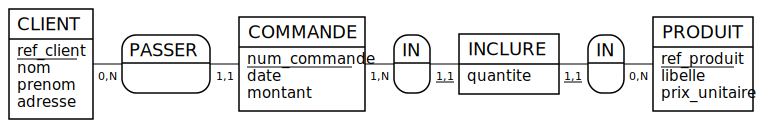

In [103]:
%%mocodo -r labels:ascii,snake drain split explode:arity=2.5,weak arrange:grid=7x1 quiet --seed 2
CLIENT: Réf. client [VARCHAR(8)], Nom [VARCHAR(255)], Prénom [VARCHAR(255)], Adresse [VARCHAR(255)]
PASSER, 0N CLIENT, 11 COMMANDE
COMMANDE: Num commande [VARCHAR(8)], Date [DATE], Montant [DECIMAL(10,2)]
INCLURE, 1N COMMANDE, 0N PRODUIT: Quantité [INTEGER]
PRODUIT: Réf. produit [VARCHAR(8)], Libellé [VARCHAR(255)], Prix unitaire [DECIMAL(10,2)]

- Les libellés des types sont ensuite réduits aux lettres ASCII, chiffres, soulignés, tirets, parenthèses et crochets. Les virgules n'étant malheureusement pas admises pour le moment (cf. [issue 1546 sur le dépôt de Mermaid](https://github.com/mermaid-js/mermaid/issues/1546)), nous les remplaçons par des tirets (ainsi `DECIMAL(10,2)` devient `DECIMAL(10-2)`).
- On permute les cardinalités de part et d'autre des associations (toutes binaires à ce stade), pour passer de la convention _look here_ (Merise) à la convention _look across_ (beaucoup plus répandue, malgré son inaptitude à la représentation des associations n-aires).
- On remplace les `0`, `1`, et `1N` des cardinalités par des signes cabalistiques, — qui ne le sont plus du tout quand on lit `o` comme _zéro_, `|` comme _un_, et `{` ou `}` comme _plusieurs_ (ce sont les pattes du fameux corbeau).
- On énumère ensuite les entités et les associations dans une syntaxe évidente. Seule subtilité : les pattes de renforcement des entités faibles (correspondant à un `_11` dans la syntaxe Mocodo) sont en traits pleins, les autres en pointillés.

#### ERD selon Chen

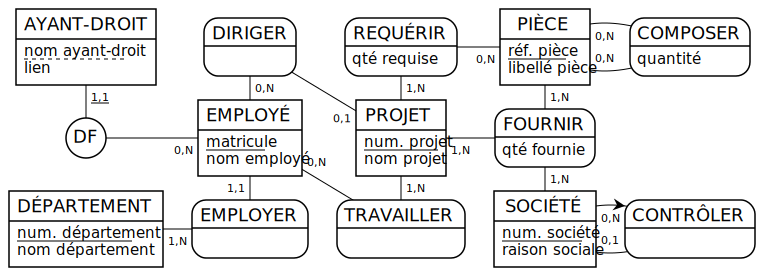

In [424]:
%%mocodo
AYANT-DROIT: nom ayant-droit, lien
DIRIGER, 0N EMPLOYÉ, 01 PROJET
REQUÉRIR, 1N PROJET, 0N PIÈCE: qté requise
PIÈCE: réf. pièce, libellé pièce
COMPOSER, 0N [composée] PIÈCE, 0N [composante] PIÈCE: quantité

DF, _11 AYANT-DROIT, 0N EMPLOYÉ
EMPLOYÉ: matricule, nom employé
PROJET: num. projet, nom projet
FOURNIR, 1N PROJET, 1N PIÈCE, 1N SOCIÉTÉ: qté fournie

DÉPARTEMENT: num. département, nom département
EMPLOYER, 11 EMPLOYÉ, 1N DÉPARTEMENT
TRAVAILLER, 0N EMPLOYÉ, 1N PROJET
SOCIÉTÉ: num. société, raison sociale
CONTRÔLER, 0N< [filiale] SOCIÉTÉ, 01 [mère] SOCIÉTÉ

In [425]:
%mocodo --input sandbox -c chen:attrs,layout=neato,overlap=prism defer --colors=ocean --seed=2

In [426]:
%mocodo --input sandbox -c chen:layout=neato,overlap=prism defer --colors=ocean --seed=4

# Réécriture automatique du texte-source d'un MCD

## Réorganiser les boîtes
### Mises en miroir
### Réarrangements

## Décomposition
### Drainage des attributs des DF
### Décomposition des DF n-aires
### Décomposition des associations n-aires non DF
### Décomposition des associations binaires non DF
### Décomposition avec création d'entités faibles
### Simplification de la décomposition
### Conclusion sur ces décompositions

## Réécriture de tokens
### Homogénéisation de la typographie
"ascii", "camel", "capitalize", "casefold", "lower", "snake", "swapcase", "title", "upper"
### Standardisation des cardinalités
### Obfuscation des libellés
### Randomisation des cardinalités
### Masquage des 

## Compléter un MCD
### Créer les entités manquantes
### Créer des types

# Annexes

## Besoins spécifiques à la pédagogie

## Notation de Chen

### Associations binaires

#### _Look Here_ vs. _Look Across_

Considérons un MCD Merise avec une association de dépendance fonctionnelle :

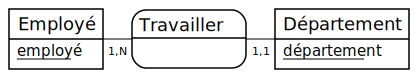

In [317]:
%%mocodo
Employé: employé
Travailler, 11 Département, 1N Employé
Département: département

Dans le formalisme graphique de Chen, cela donnera :

In [318]:
%mocodo --input sandbox -c chen:layout=circo defer

Le 1 et le N correspondent aux cardinalités maximales du MCD Merise. Comme on voit, elles sont permutées. La notation de Merise s'appelle _Look Here_ (LH) ; celle de Chen, _Look Across_ (LA). Comme cette dernière est la plus répandue dans le monde anglo-saxon, dans ce chapitre on parlera par commodité d'« ERD » (_Entity-relationship diagram_) pour les modèles conceptuels selon Chen, et de « MCD » pour ceux de Merise.

Considérons maintenant les deux versions d'une association avec des cardinalités minimales distinctes :

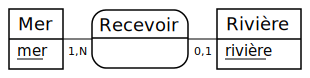

In [272]:
%%mocodo
Mer: mer
Recevoir, 01 Rivière, 1N Mer
Rivière: rivière

In [273]:
%mocodo --input sandbox -c chen:layout=circo defer

Les cardinalités maximales sont toujours permutées ; par contre, les cardinalités minimales ne le sont pas. Dans l'ERD, elles sont figurées par un trait simple (0) ou double (1). On les appelle aussi des « participations » : une rivière peut ne participer (directement) à l'alimentation d'aucune mer (ce n'est pas un fleuve) ; toute mer participe à la réception d'une rivière (un fleuve) minimum. Les conventions sont donc les suivantes :

| Cardinalités | MCD Merise | ERD Chen |
|:--|:--:|:--:|
| minimale | LH | LH |
| maximale | LH | LA |

La notation Merise a l'avantage de la cohérence ; celle de Chen en a d'autres, que nous verrons un peu plus loin, et qui expliquent peut-être en partie son succès.

Avant cela, voyons un dernier point de détail : lorsque deux cardinalités N se trouvent de part et d'autre d'une association binaire, l'une est remplacée par M.

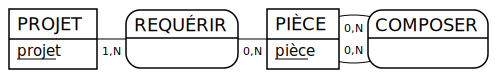

In [314]:
%%mocodo
PROJET: projet
REQUÉRIR, 1N PROJET, 0N PIÈCE
PIÈCE: pièce
COMPOSER, 0N PIÈCE, 0N PIÈCE

In [316]:
%mocodo --input sandbox -c chen:layout=circo defer

#### Entités faibles et entités associatives

Maintenant examinons le cas des entités faibles :

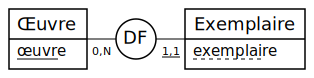

In [276]:
%%mocodo
Œuvre: œuvre
DF, 0N Œuvre, _11 Exemplaire
Exemplaire: exemplaire

In [277]:
%mocodo --input sandbox -c chen:layout=circo defer

L'entité faible, à l'instar de la DF « renforçante », sont entourées d'un double trait.

Le vocabulaire de Chen comporte encore un élément graphique, que Merise ne distingue pas spécialement. Nous avons vu que toute association non DF pouvait être décomposée de façon équivalente par l'insertion d'entités faibles :

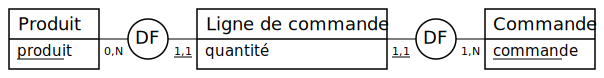

In [427]:
%%mocodo
Produit: produit
DF, _11 Ligne de commande, 0N Produit
Ligne de commande: _quantité
DF, _11 Ligne de commande, 1N Commande
Commande: commande

L'entité LIGNE DE COMMANDE peut être qualifiée d'« associative », et Chen la figure logiquement par un losange (association) inscrit dans un rectangle (entité), ce que Graphviz ne prend actuellement [pas](https://stackoverflow.com/questions/48046186/is-it-possible-to-have-nested-node-shapes-on-graphviz) en charge. Nous l'approximons donc ainsi :

In [279]:
%mocodo --input sandbox -c chen:layout=circo,mindist=2,scale=0.6 defer

### Associations n-aires

#### Triplet NNN

Jusqu'ici, la différence entre les deux notations était purement cosmétique. Qu'en est-il des associations n-aires, et que signifie _Look Across_ quand _across_ peut désigner plusieurs endroits ?

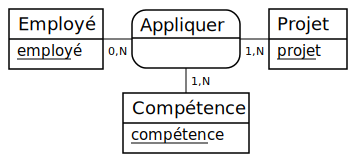

**Appliquer** (<ins>employé</ins>, <ins>projet</ins>, <ins>compétence</ins>)


In [319]:
%%mocodo --mld
Employé: employé
Appliquer, 0N Employé, 1N Projet, 1N Compétence
Projet: projet

Compétence: compétence

Dans ce cas (le plus usuel), la question ne se pose pas vraiment, ou du moins n'est pas tranchée de façon évidente :

In [320]:
%mocodo --input sandbox -c chen:layout=circo,mindist=1,scale=0.4 defer

Quels sont les autres cas ? Il ne s'agit pas de ceux où l'association n-aire est entourée d'une ou plusieurs cardinalités maximale 1, puisqu'on pourrait alors la décomposer en DF binaires (cf. sous-option `split`). En réalité, on touche ici aux limites de la notation _Look Here_, plus intuitive, mais moins puissante que _Look Across_, et que Merise n'a pu dépasser qu'avec sa version 2.

Pour répondre progressivement à notre question, procédons désormais dans l'ordre inverse, en présentant d'abord l'ERD, et ensuite seulement le MCD équivalent.

Les exemples qui suivent (ainsi d'ailleurs que le précédent), sont adaptés des pages 28 sqq. et 96 sqq. de l'ouvrage de Toby J. Teorey, Sam S. Lightstone, Tom Nadeau, H.V. Jagadish, _Database Modeling and Design - Logical Design_, 5th Edition - February 10, 2011 (Elsevier).

#### Triplet 1NN

Le premier ERD apportant véritablement quelque chose de nouveau a cette structure :

In [283]:
%mocodo --input ../LA_1NN.mcd -c chen:layout=circo,mindist=1,scale=0.45 defer

Les auteurs explicitent ainsi ses règles de gestion :

> _Chaque ingénieur travaillant sur un projet particulier a exactement un responsable, mais chaque responsable d'un projet peut gérer plusieurs ingénieurs, et chaque responsable d'un ingénieur peut gérer cet ingénieur sur plusieurs projets._

Reprenons ces trois assertions, et faisons-les correspondre au trois cardinalités dans le sens anti-horaire à partir du 1 :

- 1 : pour un couple (ingénieur, projet) donné, un seul responsable possible ;
- N : pour un couple (responsable, projet) donné, plusieurs ingénieurs possibles ;
- N : pour un couple (responsable, ingénieur) donné, plusieurs projets possibles.

Avec Merise, les assertions seraient plutôt du type : « pour un x donné, _tant_ de couples (y, z) possibles ». Il y a donc bien permutation, mais permutation des références au singleton et au $n-1$-uplet.

C'est la réponse à notre question initiale, et nous verrons avec plaisir qu'elle reste valable quel que soit le triplet de cardinalités de l'association ternaire.

Pour l'instant, résumons les règles de gestion par cette **unique** dépendance fonctionnelle :

- (Ingénieur, Projet) $\implies$ Responsable.

Pour exprimer cela en (dépit de) _Look Here_, on doit recourir à une CIF (figurée ci-dessous en notation simplifiée) :

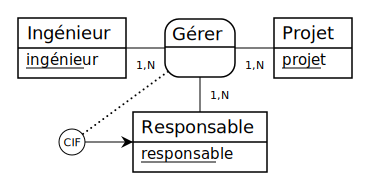

**Gérer** (<ins>ingénieur</ins>, <ins>projet</ins>, responsable)


In [380]:
%%mocodo --mld
Ingénieur: ingénieur
Gérer, /1N Responsable, 1N Ingénieur, 1N Projet
Projet: projet

Responsable: responsable
    
(CIF) ..Gérer, -> Responsable: Ingénieur, Responsable

.. ou à un agrégat :

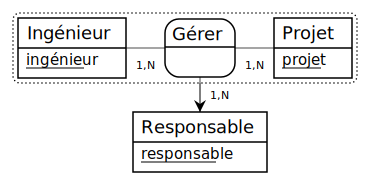

**Gérer** (<ins>ingénieur</ins>, <ins>projet</ins>, responsable)


In [381]:
%%mocodo --mld
Ingénieur: ingénieur
Gérer, /1N Responsable, 1N Ingénieur, 1N Projet
Projet: projet

Responsable: responsable

On constate que dans l'un et l'autre cas, le MLD produit respecte bien la dépendance fonctionnelle désirée : (Ingénieur, Projet) $\implies$ Responsable.

#### Triplet 11N

Passons à la deuxième combinaison intéressante :

In [248]:
%mocodo --input ../LA_11N.mcd -c chen:layout=circo,mindist=1,scale=0.45 defer

Règles de gestion :

> _Chaque employé affecté à un projet travaille sur un seul site pour ce projet, mais peut se trouver sur différents sites pour différents projets. Sur un site donné, un salarié ne travaille que sur un seul projet. Sur un site donné, il peut y avoir plusieurs employés affectés à un projet donné._

Autrement dit (en partant du bas et dans le sens anti-horaire) :

1 : pour un couple (projet, employé) donné, un seul site possible ;
1 : pour un couple (employé, site) donné, un seul projet possible ;
N : pour un couple (projet, site) donné, plusieurs employés possibles.

En résumé, **deux** dépendances fonctionnelles :

- (Projet, Employé) $\implies$ Site.
- (Employé, Site) $\implies$ Projet.

Voici le MCD correspondant, successivement avec des CIF et des agrégats :

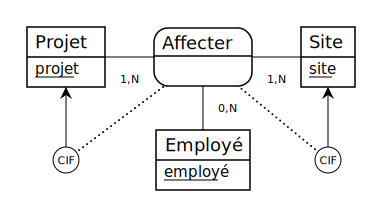

**Affecter** (<ins>projet</ins>, <ins>employé</ins> <sup>u1</sup>, site <sup>u1</sup>)


In [382]:
%%mocodo --mld
Projet: projet
Affecter, /1N Site, /1N Projet, 0N Employé
Site: site

Employé: employé
    
(CIF) ..Affecter, ->Site: Site, Employé
(CIF) ..Affecter, ->Projet: Projet, Employé

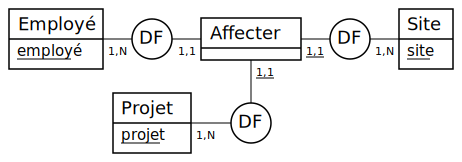

**Affecter** (<ins>projet</ins>, <ins>site</ins>, employé)


In [437]:
%%mocodo --mld
Employé: employé
DF, 1N Employé, 11 Affecter
Affecter:
DF, _11 Affecter, 1N Site
Site: site

Projet: projet
DF, _11 Affecter, 1N Projet
:

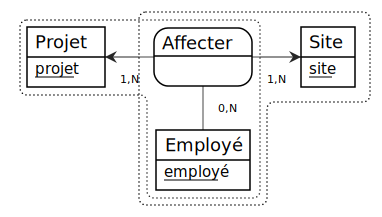

**Affecter** (<ins>projet</ins>, <ins>employé</ins> <sup>u1</sup>, site <sup>u1</sup>)


In [383]:
%%mocodo --mld
Projet: projet
Affecter, /1N Site, /1N Projet, 0N Employé
Site: site

Employé: employé

On voit apparaître dans le schéma relationnel un « u1 » en exposant qui signifie : contrainte d'unicité n°1. Il y a en effet deux clés candidates : (projet, employé) et (employé, site). Seule l'une des deux est devenue clé primaire, mais cela ne veut pas dire qu'on a perdu la contrainte de dépendance fonctionnelle induite par l'autre. On peut s'en convaincre en générant le DDL :

In [216]:
%mocodo --input sandbox -c rel:mysql --title="triplet_11N"

```sql
CREATE DATABASE IF NOT EXISTS `TRIPLET_11N`;
USE `TRIPLET_11N`;

CREATE TABLE `AFFECTER` (
  `projet` VARCHAR(42),
  `employé` VARCHAR(42),
  `site` VARCHAR(42),
  PRIMARY KEY (`projet`, `employé` )
) ENGINE=InnoDB DEFAULT CHARSET=UTF8MB4;

ALTER TABLE `AFFECTER` ADD CONSTRAINT `affecter_u1` UNIQUE (`employé`, `site`);

```

#### Triplet 111

La dernière combinaison obéit à la même logique :

In [249]:
%mocodo --input ../LA_111.mcd -c chen:layout=circo,mindist=1,scale=0.45 defer

Règles de gestion :

> _Un technicien utilise exactement un carnet pour chaque projet. Chaque carnet appartient à un technicien pour chaque projet. Notez qu'un technicien peut toujours travailler sur plusieurs projets et gérer différents carnets pour différents projets._

Autrement dit (en partant du haut et dans le sens horaire) :

- 1 : pour un couple (technicien, projet) donné, un seul carnet possible ;
- 1 : pour un couple (carnet, projet) donné, un seul technicien possible ;
- 1 : pour un couple (carnet, technicien) donné, un seul projet possible.

En résumé, **trois** dépendances fonctionnelles :

- (Technicien, Projet) $\implies$ Carnet.
- (Carnet, Technicien) $\implies$ Projet.
- (Carnet, Projet) $\implies$ Technicien.

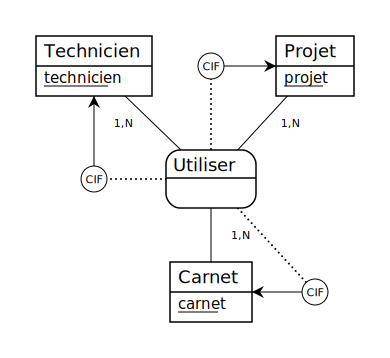

**Utiliser** (<ins>carnet</ins> <sup>u1</sup>, <ins>projet</ins> <sup>u2</sup>, technicien <sup>u1 u2</sup>)


In [384]:
%%mocodo --mld
Technicien: technicien
:
Projet: projet

Utiliser, /1N Technicien, /1N Carnet, /1N Projet
    
Carnet: carnet

(CIF) ..Utiliser, --> Technicien: Technicien, Utiliser
(CIF) ..Utiliser, --> Projet: Utiliser, Projet
(CIF) ..Utiliser, --> Carnet: Projet, Carnet

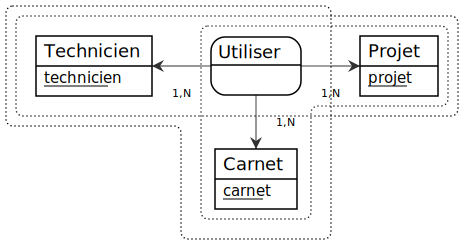

**Utiliser** (<ins>carnet</ins> <sup>u1</sup>, <ins>projet</ins> <sup>u2</sup>, technicien <sup>u1 u2</sup>)


In [414]:
%%mocodo --mld
Technicien: technicien
Utiliser, /1N Technicien, /1N Carnet, /1N Projet
Projet: projet

Carnet: carnet

Il y a maintenant trois clés candidates, correspondant à deux contraintes d'unicité.

In [386]:
%mocodo --input sandbox -c rel:mysql --title="triplet_111"

```sql
CREATE DATABASE IF NOT EXISTS `TRIPLET_111`;
USE `TRIPLET_111`;

CREATE TABLE `UTILISER` (
  `carnet` VARCHAR(42),
  `projet` VARCHAR(42),
  `technicien` VARCHAR(42),
  PRIMARY KEY (`carnet` `projet` )
) ENGINE=InnoDB DEFAULT CHARSET=UTF8MB4;

ALTER TABLE `UTILISER` ADD CONSTRAINT `utiliser_u1` UNIQUE (`carnet`, `technicien`);
ALTER TABLE `UTILISER` ADD CONSTRAINT `utiliser_u2` UNIQUE (`projet`, `technicien`);

```

### Discussion

Nous ne le savions pas en l'introduisant dans Mocodo 3, mais la syntaxe `/1N` pour les agrégats permet d'exprimer parfaitement (et simplement !) toutes les combinaisons possibles de cardinalités d'une association n-aire dans la notation de Chen : il suffit de mettre un `/1N` partout où se trouve un `1` ! Chacun créera une nouvelle dépendance fonctionnelle, autrement dit, une nouvelle clé candidate.

Plus rigoureusement : supposons une association $n$-aire $A$ exclusivement entourée de 1N (ou 0N). Soient $E_1$, $E_2$, ..., $E_n$ les entités mises en jeu, et $k_1, k_2$, ..., $k_n$ leurs identifiants respectifs. Alors, noter `/1N` (ou `/0N`) la cardinalité de la patte de $E_i$ dénote l'existence de la dépendance fonctionnelle suivante : $(k_1, ..., k_{i-1}, k_{i+1}, ..., k_n) \implies k_i$, autrement dit : que $(k_1, ..., k_{i-1}, k_{i+1}, ..., k_n)$ est une clé candidate de la table $A$.

Notez au passage que Mocodo permet de spécifier à coût zéro quelle clé candidate sera élue clé primaire. Il suffit pour cela de placer en tête de la liste des entités mises en jeu par $A$ celle dont l'identifiant ne doit **pas** entrer dans la clé primaire. Si c'est $E_1$, la clé primaire sera automatiquement $(k_2, ..., k_n)$.

Dans tous les cas, les clés alternatives se voient traduites aux niveaux relationnel et physique par des contraintes d'unicité.

Au terme de cette petite étude, je ne puis me défendre de l'impression que les associations ternaires représentent pour Merise une occasion manquée, consécutive au choix d'une notation LH. L'introduction de cet élément dans le vocabulaire graphique est sous-exploité : des quatre combinaisons de cardinalités maximales (NNN, 1NN, 11N, 111), les trois dernières sont honnies ; la première elle-même n'est souvent que tolérée. En notation LA, chacune a sa raison d'être et sa propre sémantique. La première (NNN) coïncide heureusement avec LH, mais c'est tout. Dommage ?

## Crédits

- **Auteur**
  - Aristide Grange, Université de Lorraine, Metz, [LCOMS](http://lcoms.univ-lorraine.fr).
- **Outils**
  - Aspect visuel
    - [Color Brewer](http://colorbrewer2.org) (Cynthia Brewer).
    - [Font Awesome](http://fortawesome.github.io/Font-Awesome/) (Dave Gandy).
    - [Fork me on GitHub Retina Ribbons](https://ar.al/scribbles/fork-me-on-github-retina-ribbons/) (Aral Balkan).
    - [Real Favicon Generator](http://realfavicongenerator.net) (Philippe Bernard).
    - [reset.css](http://meyerweb.com/eric/tools/css/reset/) (Eric Meyer).
    - [Source Code Pro](https://github.com/adobe-fonts/source-code-pro) (Paul D. Hunt).
  - JavaScript
    - [JQuery](http://jquery.com/) (John Resig).
    - [JS-Cookie](https://github.com/js-cookie/js-cookie) (Klaus Hartl).
  - Python
    - [Distance de Damerau-Levenshtein](http://mwh.geek.nz/2009/04/26/python-damerau-levenshtein-distance/) (Michael Homer).
- **[Localisation](https://www.transifex.com/aristide/mocodo/)**
  - Allemand: Pascal Fickert, Luis Willnat.
  - Chinois: Liu Jingjiao.
  - Français: Aristide Grange.
- **Sans oublier** 
  Abou-Sophiane Belhadj,
  Kamel Chelghoum,
  Rémi Da Costa,
  Benjamin Gannat,
  Thomas Giro,
  Michel Grandmougin,
  Alexandre Grison,
  David Lorge,
  Dorian Mahut,
  Sébastien Martin,
  Cyril Minette,
  Idris Neumann,
  Bryan Oakley,
  Georges Perec,
  Cédric Poinsaint,
  Zsuzsanna Róka,
  Florian Roméo,
  Tong Ji
  et d'innombrables contributeurs de [Stack Overflow](http://stackoverflow.com).